# Test model on reader-specific questions
We have previously determined that the reader-aware model does (slightly) better on divisive posts.

How well does the model do on questions that are highly associated with a specific reader group? E.g. if P(reader == EXPERT) is high (based on classification model or reader traits), does the generation model catch those questions better?

In [12]:
## load data
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas()
test_data.rename(columns={'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
print(test_data.shape)

(53080, 17)


In [5]:
## load data cleaning PCA models
import pickle
PCA_post_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=post_encoded.pkl', 'rb'))
PCA_question_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=question_encoded.pkl', 'rb'))

In [6]:
## load classification models
import os
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
reader_group_models = {}
model_dir = '../../data/reddit_data/group_classification_model/question_post_data/'
for reader_group_i in reader_groups:
    default_class_i = reader_group_default_class[reader_group_i]
    model_file_i = os.path.join(model_dir, f'MLP_prediction_group={reader_group_i}_class1={default_class_i}.pkl')
    reader_group_models[reader_group_i] = pickle.load(open(model_file_i, 'rb'))

In [18]:
## load embedding model
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import load_sentence_embed_model
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
embed_vars = ['question', 'post']
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(test_data.loc[:, embed_var_i].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    test_data = test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

In [76]:
## use PCA to compress data
import numpy as np
PCA_models = [PCA_question_embed_model, PCA_post_embed_model]
for embed_var_i, PCA_model_i in zip(embed_vars, PCA_models):
    encode_var_i = f'{embed_var_i}_encoded'
    mat_i = np.vstack(test_data.loc[:, encode_var_i].values)
    reduce_mat_i = PCA_model_i.fit_transform(mat_i)
    test_data = test_data.assign(**{
        f'PCA_{encode_var_i}': [reduce_mat_i[i, :] for i in range(reduce_mat_i.shape[0])]
    })

In [74]:
## assign labels
reader_group_category_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in reader_group_category_lookup.items() for v1 in v
}
test_data = test_data.assign(**{
    'reader_group' : test_data.loc[:, 'reader_token_str'].apply(lambda x: reader_group_category_lookup[x])
})
reader_group_default_class_str = {
    'relative_time_bin' : '<RESPONSE_TIME_0_AUTHOR>',
    'expert_pct_bin' : '<EXPERT_PCT_0_AUTHOR>',
    'location_region' : '<NONUS_AUTHOR>',
    'UNK' : 'UNK'
}
test_data = test_data.assign(**{
    'reader_group_class' : test_data.apply(lambda x: int(x.loc['reader_token_str']==reader_group_default_class_str[x.loc['reader_group']]), axis=1)
})

In [77]:
## predict class for all reader groups
import pandas as pd
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
pred_test_data = []
for reader_group_i in reader_groups:
    # clean data etc.
    test_data_i = test_data[test_data.loc[:, 'reader_group']==reader_group_i]
    question_post_text_i = np.hstack([np.vstack(test_data_i.loc[:, 'PCA_question_encoded'].values), np.vstack(test_data_i.loc[:, 'PCA_post_encoded'].values)])
    # do prediction!!
    reader_group_model_i = reader_group_models[reader_group_i]
    pred_prob_i = reader_group_model_i.predict_proba(question_post_text_i)
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred' : np.argmax(pred_prob_i, axis=1)
    })
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred_prob' : np.max(pred_prob_i, axis=1)
    })
    pred_test_data.append(test_data_i)
pred_test_data = pd.concat(pred_test_data, axis=0)

In [78]:
## let's check out accuracy
from sklearn.metrics import f1_score
for reader_group_i, data_i in pred_test_data.groupby('reader_group'):
    print(f'label dist =\n{data_i.loc[:, "reader_group_class"].value_counts()}')
    print(f'pred dist =\n{data_i.loc[:, "reader_group_class_pred"].value_counts()}')
    f1_i = f1_score(data_i.loc[:, 'reader_group_class'].values, data_i.loc[:, 'reader_group_class_pred'].values, average='macro')
    print(f'reader group = {reader_group_i} has F1={"{:.3f}".format(f1_i)}')

label dist =
1    10070
0     4254
Name: reader_group_class, dtype: int64
pred dist =
0    8242
1    6082
Name: reader_group_class_pred, dtype: int64
reader group = expert_pct_bin has F1=0.463
label dist =
0    1459
1    1189
Name: reader_group_class, dtype: int64
pred dist =
0    1377
1    1271
Name: reader_group_class_pred, dtype: int64
reader group = location_region has F1=0.504
label dist =
0    8245
1    6079
Name: reader_group_class, dtype: int64
pred dist =
0    13338
1      986
Name: reader_group_class_pred, dtype: int64
reader group = relative_time_bin has F1=0.412


This is bad! Maybe there's an issue with data shift?

Let's retrain and test the model on balanced data.

In [126]:
## get train data, re-clean etc, combine with test data
train_data = torch.load('../../data/reddit_data/combined_data_train_data.pt').data.to_pandas()
train_data.rename(columns={'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
## assign labels
reader_group_category_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in reader_group_category_lookup.items() for v1 in v
}
train_data = train_data.assign(**{
    'reader_group' : train_data.loc[:, 'reader_token_str'].apply(lambda x: reader_group_category_lookup[x])
})
reader_group_default_class_str = {
    'relative_time_bin' : '<RESPONSE_TIME_0_AUTHOR>',
    'expert_pct_bin' : '<EXPERT_PCT_0_AUTHOR>',
    'location_region' : '<NONUS_AUTHOR>',
    'UNK' : 'UNK'
}
train_data = train_data.assign(**{
    'reader_group_class' : train_data.apply(lambda x: int(x.loc['reader_token_str']==reader_group_default_class_str[x.loc['reader_group']]), axis=1)
})
train_test_data = pd.concat([train_data, test_data], axis=0)
## add subreddit data for later sampling
import pandas as pd
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', usecols=['id', 'subreddit'])
post_data.rename(columns={'id' : 'article_id'}, inplace=True)
train_test_data = pd.merge(train_test_data, post_data, on='article_id', how='left')

In [128]:
## recompute PCA etc.
trained_PCA_models = []
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
from sklearn.decomposition import PCA
embed_vars = ['question', 'post']
PCA_dim = 100
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(train_test_data.loc[:, embed_var_i].values, batch_size=32, device=torch.cuda.current_device(), show_progress_bar=True)
    train_test_data = train_test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })
    # PCA transform
    PCA_model_i = PCA(n_components=PCA_dim, random_state=123)
    PCA_embed_i = PCA_model_i.fit_transform(np.vstack(train_test_data.loc[:, encode_var_i].values))
    train_test_data = train_test_data.assign(**{
        f'PCA_{encode_var_i}' : [PCA_embed_i[j, :] for j in range(PCA_embed_i.shape[0])]
    })

Batches:   0%|          | 0/8133 [00:00<?, ?it/s]

Batches:   0%|          | 0/8133 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [121]:
# check question nearest neighbors
sample_data = train_test_data.iloc[200, :]
print(sample_data.loc['question'])
sample_question_embed = sample_data.loc['PCA_question_encoded']
from sklearn.metrics.pairwise import cosine_similarity
sample_question_embed_sim = cosine_similarity(sample_question_embed.reshape(1,-1), np.vstack(train_test_data.loc[:, 'PCA_question_encoded'].values))
top_k = 10
top_k_sim_data = train_test_data.iloc[np.argsort(sample_question_embed_sim[0])[::-1][1:(top_k+1)], :]
display(top_k_sim_data.loc[:, 'question'])

I'm just confused why she even knows what your documents are?


174807    I'm just confused why she even knows what your...
134572    Does she have *any* documents with her real ag...
164758    Is there somewhere her father kept most of his...
136346    Is there somewhere her father kept most of his...
157111                     Do you not have those documents?
191358                     Do you not have those documents?
105907    Is she just forgetful and/or lazy, or is she t...
11449     Though she isn't curious where your entire che...
44601     Though she isn't curious where your entire che...
117364                 Sp have you actually read her stuff?
Name: question, dtype: object

OK! These representations are actually meaningful.

In [135]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
k_folds = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
layer_size = PCA_dim * 2
sample_size = 10000
for reader_group_i in reader_groups:
    data_i = train_test_data[train_test_data.loc[:, 'reader_group']==reader_group_i]
    # tmp debug
#     sample_size_i = min(sample_size, data_i.shape[0])
#     data_i = data_i.sample(sample_size_i, replace=False, random_state=123)
    # sample by subreddit
    subreddit_sample_size_i = data_i.loc[:, 'subreddit'].value_counts().min()
    sample_data_i = data_i.groupby('subreddit').apply(lambda x: x.sample(subreddit_sample_size_i, replace=False, random_state=123)).reset_index(drop=True)
    X = np.hstack([np.vstack(sample_data_i.loc[:, 'PCA_question_encoded'].values), np.vstack(sample_data_i.loc[:, 'PCA_post_encoded'].values)])
    Y = sample_data_i.loc[:, 'reader_group_class'].values
    acc_scores_i = []
    for j, (train_idx, test_idx) in tqdm(enumerate(k_folds.split(X, Y))):
        X_train, X_test = X[train_idx, :], X[test_idx, :]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        model = MLPClassifier(hidden_layer_sizes=[layer_size,], activation='relu', solver='lbfgs', max_iter=1000, random_state=123)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        acc_score_j = (Y_pred==Y_test).sum() / len(Y_test)
        f1_score_j = f1_score(Y_test, Y_pred)
        print(f'iter {j} has acc={"{:.3f}".format(acc_score_j)} F1={"{:.3f}".format(f1_score_j)}')
        acc_scores_i.append([acc_score_j, f1_score_j])
    acc_scores_i = pd.DataFrame(acc_scores_i, columns=['acc', 'f1'])
    print(f'reader group {reader_group_i} has mean acc = {acc_scores_i.loc[:, "acc"].mean()}; F1={acc_scores_i.loc[:, "f1"].mean()}')

1it [02:03, 123.01s/it]

iter 0 has acc=0.523 F1=0.447


2it [03:50, 114.13s/it]

iter 1 has acc=0.540 F1=0.464


3it [05:39, 111.68s/it]

iter 2 has acc=0.512 F1=0.438


4it [07:21, 107.94s/it]

iter 3 has acc=0.528 F1=0.444


4it [07:48, 117.17s/it]


KeyboardInterrupt: 

This "train-from-scratch" approach isn't working out.

Why don't we just use the data that we used in the group classification model results? We balanced the data to have at least one question from each reader group per post.

In [1]:
# load sample data
import pandas as pd
import re
import numpy as np
arr_matcher = re.compile('[\[\]\n]')
embed_vars = ['question', 'post']
embed_var_converters = {
    f'PCA_{embed_var}_encoded': lambda x: np.fromstring(arr_matcher.sub('', x).strip(), sep=' ', dtype=float)
    for embed_var in embed_vars
}
post_question_data_file = '../../data/reddit_data/group_classification_model/sample_type=paired_post_question_data.gz'
post_question_data = pd.read_csv(post_question_data_file, sep='\t', compression='gzip', index_col=False,
                                 converters=embed_var_converters)
# fix author group
post_question_data = post_question_data.assign(**{
    'author_group' : post_question_data.loc[:, 'author_group'].apply(lambda x: str(x) if type(x) is not str else x)
})
# limit to test data
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas()
test_data.rename(columns={'article_id' : 'parent_id'}, inplace=True)
test_post_question_data = post_question_data[post_question_data.loc[:, 'parent_id'].isin(test_data.loc[:, 'parent_id'].unique())]
print(f'{test_post_question_data.shape[0]}/{post_question_data.shape[0]}')

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


41132/209884


In [47]:
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
def resample_by_class(data, class_var='author_group', class_count='min'):
    data_class_counts = data.loc[:, class_var].value_counts()
#     print(f'data class counts = {data_class_counts}')
    if(class_count == 'min'):
        data_class_count_base = data_class_counts.min()
        data_class = data_class_counts.sort_values(ascending=True).index[0]
    elif(class_count == 'max'):
        data_class_count_base = data_class_counts.max()
        data_class = data_class_counts.sort_values(ascending=False).index[0]
#     print(f'min class = {data_min_class}')
    data = pd.concat(
        [data[data.loc[:, class_var]==data_class], 
         data[data.loc[:, class_var]!=data_class].sample(data_class_count_base, replace=(class_count=='max'), random_state=123)],
    axis=0)
#     print(f'post-stratify data class counts = {data.loc[:, class_var].value_counts()}')
    return data
np.random.seed(123)
text_var = 'PCA_question_encoded'
post_var = 'PCA_post_encoded'
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
n_folds = 5
reader_group_model_scores = []
train_pct = 0.8
for group_category_i, data_i in test_post_question_data.groupby('group_category'):
    Y = data_i.loc[:, 'author_group'].values
    default_class_i = reader_group_default_class[group_category_i]
    non_default_class_i = list(set(Y) - {default_class_i})[0]
    X = np.hstack([np.vstack(data_i.loc[:, text_var].values), np.vstack(data_i.loc[:, post_var].values)])
#     X = np.vstack(data_i.loc[:, text_var].values)
    layer_size = X.shape[1]
    # convert to binary
    Y = (Y==default_class_i).astype(int)
    # fit models across all folds
    model_scores = []
    k_folds = StratifiedKFold(n_splits=n_folds, random_state=123, shuffle=True)
    subreddits = data_i.loc[:, 'subreddit'].unique()
    data_i = data_i.assign(**{'idx' : list(range(data_i.shape[0]))})
    parent_id_i = data_i.loc[:, 'parent_id'].unique()
    train_N_i = int(len(parent_id_i) * train_pct)
    # split by parent ID
    for j in tqdm(range(n_folds)):
        train_id_j = set(np.random.choice(parent_id_i, train_N_i, replace=False))
        test_id_j = list(set(parent_id_i) - train_id_j)
        train_idx = np.where(data_i.loc[:, 'parent_id'].isin(train_id_j))[0]
        test_idx = np.where(data_i.loc[:, 'parent_id'].isin(test_id_j))[0]
    # k-fold splitting => need to prevent shared info from shared posts
#     for j, (train_idx, test_idx) in tqdm(enumerate(k_folds.split(X, Y))):
        # remove shared posts from test data
#         train_id_j = set(data_i.iloc[train_idx, :].loc[:, 'parent_id'].unique())
#         test_idx = list(set(test_idx) - set(np.where(data_i.loc[:, 'parent_id'].isin(train_id_j))[0]))
#         print(len(test_idx))
        # resample data to avoid class distribution imbalance
        train_data_i = data_i.iloc[train_idx, :]
        train_data_i = resample_by_class(train_data_i, class_var='author_group', class_count='max')
        train_idx = train_data_i.loc[:, 'idx'].values
        test_data_i = data_i.iloc[test_idx, :]
        test_data_i = resample_by_class(test_data_i, class_var='author_group', class_count='max')
        test_idx = test_data_i.loc[:, 'idx'].values
#         X_train = np.hstack([np.vstack(train_data_i.loc[:, text_var].values), np.vstack(train_data_i.loc[:, post_var].values)])
#         X_test = np.hstack([np.vstack(test_data_i.loc[:, text_var].values), np.vstack(test_data_i.loc[:, post_var].values)])
#         Y_train = (train_data_i.loc[:, 'author_group'].values==default_class_i).astype(int)
#         Y_test = (test_data_i.loc[:, 'author_group'].values==default_class_i).astype(int)
#         print(train_data_i.loc[:, 'author_group'].value_counts())
#         print(test_data_i.loc[:, 'author_group'].value_counts())
#         break
#         train_data_i_class_counts = train_data_i.loc[:, 'author_group'].value_counts()
#         train_data_i_min_class = train_data_i_class_counts.sort_values().index[0]
#         train_data_i = pd.concat(
#             [train_data_i[train_data_i.loc[:, 'author_group']==train_data_i_min_class], 
#              train_data_i[train_data_i.loc[:, 'author_group']!=train_data_i_min_class].sample(train_data_i_class_counts.min(), replace=False, seed=123)]
#         )
#         train_idx = train_data_i.loc[:, 'idx'].values
        X_train, X_test = X[train_idx, :], X[test_idx, :]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
#         print(X_test.shape)
        
        # fit model
        model = MLPClassifier(hidden_layer_sizes=[layer_size,], activation='relu', max_iter=5000, random_state=123)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        Y_prob = model.predict_proba(X_test)
        model_acc = (Y_pred==Y_test).sum() / len(Y_test)
        # get F1 for both classes...there must be a better way to do this
        model_f1_class_1 = f1_score(Y_pred, Y_test)
        model_f1_class_0 = f1_score((1-Y_pred), (1-Y_test))
        model_f1_macro = f1_score(Y_pred, Y_test, average='macro')
        model_auc = roc_auc_score(Y_test, Y_prob[:, 1])
        model_scores_j = {
            'model_acc' : model_acc, 
            f'F1_{default_class_i}' : model_f1_class_1, 
            f'F1_{non_default_class_i}' : model_f1_class_0, 
            'F1_macro' : model_f1_macro,
            'AUC' : model_auc,
            'fold' : j}
        ## get scores per subreddit!!
        for subreddit_k in subreddits:
            idx_k = list(set(np.where(data_i.loc[:, 'subreddit']==subreddit_k)[0]) & set(test_idx))
            if(len(idx_k) > 0):
                Y_pred_k = model.predict(X[idx_k, :])
                model_acc_k = (Y[idx_k]==Y_pred_k).sum() / len(Y_pred_k)
                model_scores_j[f'model_acc_{subreddit_k}'] = model_acc_k
        model_scores_j['model_acc_subreddit_mean'] = np.mean([model_scores_j[f'model_acc_{subreddit_k}'] for subreddit_k in subreddits])
#         print(f'model scores = {model_scores_j}')
        model_scores.append(model_scores_j)
    model_scores = pd.DataFrame(model_scores)
    model_scores = model_scores.assign(**{'group_category' : group_category_i})
    print(f'reader group {group_category_i}')
    print(f'mean scores = {model_scores.loc[:, ["model_acc", "F1_macro", "model_acc_subreddit_mean"]].mean(axis=0)}')
    reader_group_model_scores.append(model_scores)
reader_group_model_scores = pd.concat(reader_group_model_scores, axis=0)

100%|██████████| 5/5 [01:45<00:00, 21.14s/it]


reader group expert_pct_bin
mean scores = model_acc                   0.499844
F1_macro                    0.450310
model_acc_subreddit_mean    0.555706
dtype: float64


100%|██████████| 5/5 [00:18<00:00,  3.76s/it]


reader group location_region
mean scores = model_acc                   0.516916
F1_macro                    0.503253
model_acc_subreddit_mean    0.526617
dtype: float64


100%|██████████| 5/5 [02:14<00:00, 26.96s/it]

reader group relative_time_bin
mean scores = model_acc                   0.506726
F1_macro                    0.502529
model_acc_subreddit_mean    0.505719
dtype: float64


### Label with trained models
Let's assume that the models are (slightly) more accurate for high-probability predictions. We will reload the trained models, recompute the representations for posts and questions, assign a reader group based on the model's prediction.

We will then cross-reference with the generated text from text-only and reader-aware models, and look at performance for the questions that were highly associated with a particular reader group.

In [1]:
## load data
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas()
test_data.rename(columns={'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
print(test_data.shape)

(53080, 17)


In [19]:
## load data cleaning PCA models
import pickle
PCA_post_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=post_encoded.pkl', 'rb'))
PCA_question_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=question_encoded.pkl', 'rb'))
## load classification models
import os
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
reader_group_models = {}
model_dir = '../../data/reddit_data/group_classification_model/question_post_data/'
for reader_group_i in reader_groups:
    default_class_i = reader_group_default_class[reader_group_i]
    model_file_i = os.path.join(model_dir, f'MLP_prediction_group={reader_group_i}_class1={default_class_i}.pkl')
    reader_group_models[reader_group_i] = pickle.load(open(model_file_i, 'rb'))
## load embedding model
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import load_sentence_embed_model
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
embed_vars = ['question', 'post']
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(test_data.loc[:, embed_var_i].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    test_data = test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })
## use PCA to compress data
import numpy as np
PCA_models = [PCA_question_embed_model, PCA_post_embed_model]
for embed_var_i, PCA_model_i in zip(embed_vars, PCA_models):
    encode_var_i = f'{embed_var_i}_encoded'
    mat_i = np.vstack(test_data.loc[:, encode_var_i].values)
    reduce_mat_i = PCA_model_i.fit_transform(mat_i)
    test_data = test_data.assign(**{
        f'PCA_{encode_var_i}': [reduce_mat_i[i, :] for i in range(reduce_mat_i.shape[0])]
    })
## assign labels
category_reader_group_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in category_reader_group_lookup.items() for v1 in v
}
test_data = test_data.assign(**{
    'reader_group' : test_data.loc[:, 'reader_token_str'].apply(lambda x: reader_group_category_lookup[x])
})
reader_group_default_class_str = {
    'relative_time_bin' : '<RESPONSE_TIME_0_AUTHOR>',
    'expert_pct_bin' : '<EXPERT_PCT_0_AUTHOR>',
    'location_region' : '<NONUS_AUTHOR>',
    'UNK' : 'UNK'
}
pred_val_reader_group_lookup = {
    'relative_time_bin' : {
        0 : '<RESPONSE_TIME_1_AUTHOR>',
        1 : '<RESPONSE_TIME_0_AUTHOR>',
    },
    'expert_pct_bin' : {
        0 : '<EXPERT_PCT_1_AUTHOR>',
        1 : '<EXPERT_PCT_0_AUTHOR>',
    },
    'location_region' : {
        0 : '<US_AUTHOR>',
        1 : '<NONUS_AUTHOR>',
    },
}
test_data = test_data.assign(**{
    'reader_group_class' : test_data.apply(lambda x: int(x.loc['reader_token_str']==reader_group_default_class_str[x.loc['reader_group']]), axis=1)
})
## predict class for all reader groups
import pandas as pd
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
pred_test_data = []
for reader_group_i in reader_groups:
    # clean data etc.
    test_data_i = test_data[test_data.loc[:, 'reader_group']==reader_group_i]
    question_post_text_i = np.hstack([np.vstack(test_data_i.loc[:, 'PCA_question_encoded'].values), np.vstack(test_data_i.loc[:, 'PCA_post_encoded'].values)])
    # do prediction!!
    reader_group_model_i = reader_group_models[reader_group_i]
    pred_prob_i = reader_group_model_i.predict_proba(question_post_text_i)
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred' : np.argmax(pred_prob_i, axis=1)
    })
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred_prob' : np.max(pred_prob_i, axis=1)
    })
    # convert to class str
    pred_val_lookup_i = pred_val_reader_group_lookup[reader_group_i]
    test_data_i = test_data_i.assign(**{
        'reader_group_class_pred_str' : test_data_i.loc[:, 'reader_group_class_pred'].apply(pred_val_lookup_i.get)
    })
    pred_test_data.append(test_data_i)
pred_test_data = pd.concat(pred_test_data, axis=0)

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

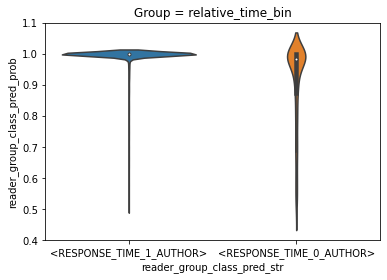

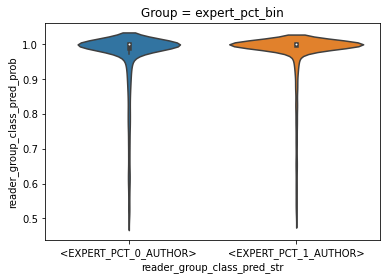

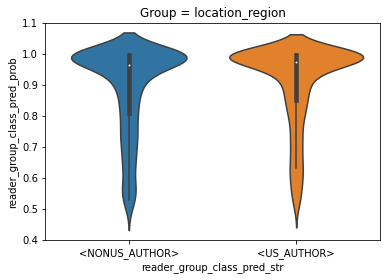

In [20]:
# show distribution of probability
# flatten data
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
for reader_group_i in reader_groups:
    data_i = pred_test_data[pred_test_data.loc[:, 'reader_group']==reader_group_i]
    sns.violinplot(data=data_i, x='reader_group_class_pred_str', y='reader_group_class_pred_prob')
    plt.title(f'Group = {reader_group_i}')
    plt.show()

Based on the skewed distributions, let's take the predictions with $P>=0.99$ and use those to filter the data.

In [23]:
pred_test_data.shape

(31296, 26)

In [24]:
prob_cutoff = 0.99
cutoff_test_data = pred_test_data[pred_test_data.loc[:, 'reader_group_class_pred_prob']>= prob_cutoff]
print(f'{cutoff_test_data.shape[0]}/{pred_test_data.shape[0]} data retained')

25101/31296 data retained


Will this data actually have different generation results, as compared to the full data? We will see!!

In [53]:
## load generated text data
import gzip
text_only_model_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rt')))
reader_token_model_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_output_text.gz', 'rt')))
reader_attention_model_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_attention_data/author_attention_layer=5_location=encoder_config=attnconcat/test_data_output_text.gz', 'rt')))
test_data = test_data.assign(**{
    'text_only_model' : text_only_model_output,
    'reader_token_model' : reader_token_model_output,
    'reader_attn_model' : reader_attention_model_output,
})
# add to cutoff data
pred_text_data = pd.concat([cutoff_test_data, test_data.loc[cutoff_test_data.index, ['text_only_model', 'reader_token_model', 'reader_attn_model']]], axis=1)
print(pred_text_data.shape)

(25101, 29)


In [66]:
## compute overlap metrics etc.
from test_question_generation import STOP_WORDS, test_question_overlap
# suppress BLEU error message
import warnings
warnings.filterwarnings('ignore')
word_embed_file = '../../data/embeddings/wiki-news-300d-1M.vec.gz'
model_output_types = [
    'text_only_model',
    'reader_token_model',
    'reader_attn_model'
]
from nlp.arrow_dataset import Dataset
pred_text_data_torch = Dataset.from_pandas(pred_text_data)
pred_text_data_torch.rename_column_('question', 'target_text')
text_overlap_score_data = []
for model_output_type_i in model_output_types:
    print(f'model={model_output_type_i}')
    overlap_score_data_i = test_question_overlap(
        pred_text_data.loc[:, model_output_type_i].values,
        pred_text_data_torch,
        word_embed_file=word_embed_file,
        stop_words=STOP_WORDS,
    )
    # fix column names
    overlap_score_data_i.rename(columns={
        c : f'{c}_model={model_output_type_i.replace("_model","")}'
        for c in overlap_score_data_i.columns
    }, inplace=True)
    text_overlap_score_data.append(overlap_score_data_i)
text_overlap_score_data = pd.concat(text_overlap_score_data, axis=1)

What is the overall distribution of scores for the different model types?

BLEU-1_model=text_only              0.163296
ROUGE-L_model=text_only             0.130945
sentence_dist_model=text_only       0.725070
WMD_model=text_only                 0.235829
BLEU-1_model=reader_token           0.162543
ROUGE-L_model=reader_token          0.131450
sentence_dist_model=reader_token    0.728466
WMD_model=reader_token              0.236606
BLEU-1_model=reader_attn            0.159031
ROUGE-L_model=reader_attn           0.128210
sentence_dist_model=reader_attn     0.751031
WMD_model=reader_attn               0.245252
dtype: float64

,score_type,score,model_type
0,BLEU-1,0.104834,text_only
1,BLEU-1,0.133009,text_only
2,BLEU-1,0.210756,text_only
3,BLEU-1,0.105108,text_only
4,BLEU-1,0.242022,text_only


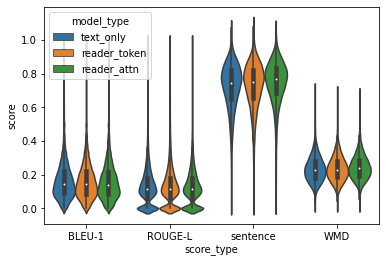

In [83]:
## print aggregate median vals
display(text_overlap_score_data.mean(axis=0))
## display distributions
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
flat_text_overlap_score_data = pd.melt(text_overlap_score_data, value_vars=text_overlap_score_data.columns, var_name='score_type', value_name='score')
flat_text_overlap_score_data = flat_text_overlap_score_data.assign(**{
    'model_type' : flat_text_overlap_score_data.loc[:, 'score_type'].apply(lambda x: x.split('=')[-1]),
    'score_type' : flat_text_overlap_score_data.loc[:, 'score_type'].apply(lambda x: x.split('_')[0]),
})
display(flat_text_overlap_score_data.head())
sns.violinplot(data=flat_text_overlap_score_data, x='score_type', y='score', hue='model_type')
plt.show()

Not great! What does this look like for different reader groups?

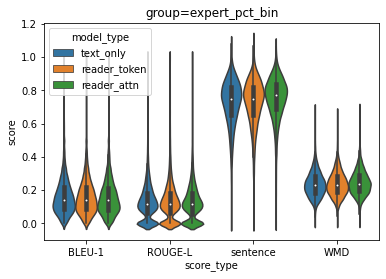

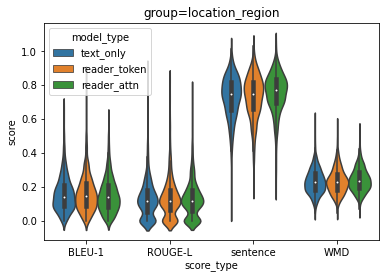

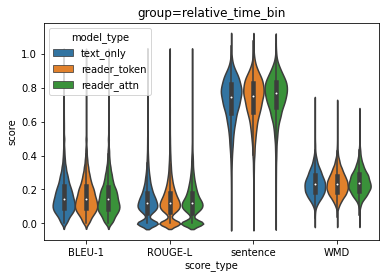

In [82]:
text_overlap_score_data.index = pred_text_data.index
pred_score_text_data = pd.concat([pred_text_data, text_overlap_score_data], axis=1)
## flatten etc
flat_pred_score_text_data = pd.melt(pred_score_text_data, id_vars=['reader_group'], value_vars=text_overlap_score_data.columns, var_name='score_type', value_name='score')
flat_pred_score_text_data = flat_pred_score_text_data.assign(**{
    'model_type' : flat_pred_score_text_data.loc[:, 'score_type'].apply(lambda x: x.split('=')[-1]),
    'score_type' : flat_pred_score_text_data.loc[:, 'score_type'].apply(lambda x: x.split('_')[0]),
})
# display(flat_pred_score_text_data.head())
for group_i, data_i in flat_pred_score_text_data.groupby('reader_group'):
    sns.violinplot(data=data_i, x='score_type', y='score', hue='model_type')
    plt.title(f'group={group_i}')
    plt.show()

### Train reader prediction model: per-subreddit
An "expert" user may look very different in one subreddit versus another. Let's try to address this by training a separate model for each reader group for each subreddit. $G*S=15$ models total...fun.

In [4]:
## load data
import torch
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas()
test_data.rename(columns={'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
print(test_data.shape)
## add subreddit info
import pandas as pd
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', usecols=['id', 'subreddit']).rename(columns={'id' : 'article_id'})
test_data = pd.merge(test_data, post_data, on='article_id')
print(test_data.loc[:, 'subreddit'].value_counts())

(53080, 17)
AmItheAsshole      22531
personalfinance    11798
legaladvice         7424
Advice              7215
pcmasterrace        4112
Name: subreddit, dtype: int64


In [22]:
## load data cleaning PCA models
import pickle
PCA_post_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=post_encoded.pkl', 'rb'))
PCA_question_embed_model = pickle.load(open('../../data/reddit_data/group_classification_model/PCA_model_embed=question_encoded.pkl', 'rb'))
## load classification models
import os
reader_groups = ['relative_time_bin', 'expert_pct_bin', 'location_region']
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
reader_group_models = {}
model_dir = '../../data/reddit_data/group_classification_model/question_post_data/'
for reader_group_i in reader_groups:
    default_class_i = reader_group_default_class[reader_group_i]
    model_file_i = os.path.join(model_dir, f'MLP_prediction_group={reader_group_i}_class1={default_class_i}.pkl')
    reader_group_models[reader_group_i] = pickle.load(open(model_file_i, 'rb'))
## load embedding model
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import load_sentence_embed_model
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
embed_vars = ['question', 'post']
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(test_data.loc[:, embed_var_i].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    test_data = test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })
## use PCA to compress data
import numpy as np
PCA_models = [PCA_question_embed_model, PCA_post_embed_model]
for embed_var_i, PCA_model_i in zip(embed_vars, PCA_models):
    encode_var_i = f'{embed_var_i}_encoded'
    mat_i = np.vstack(test_data.loc[:, encode_var_i].values)
    reduce_mat_i = PCA_model_i.transform(mat_i)
    test_data = test_data.assign(**{
        f'PCA_{encode_var_i}': [reduce_mat_i[i, :] for i in range(reduce_mat_i.shape[0])]
    })
## assign labels
category_reader_group_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in category_reader_group_lookup.items() for v1 in v
}
test_data = test_data.assign(**{
    'reader_group' : test_data.loc[:, 'reader_token_str'].apply(lambda x: reader_group_category_lookup[x])
})
reader_group_default_class_str = {
    'relative_time_bin' : '<RESPONSE_TIME_0_AUTHOR>',
    'expert_pct_bin' : '<EXPERT_PCT_0_AUTHOR>',
    'location_region' : '<NONUS_AUTHOR>',
    'UNK' : 'UNK'
}
pred_val_reader_group_lookup = {
    'relative_time_bin' : {
        0 : '<RESPONSE_TIME_1_AUTHOR>',
        1 : '<RESPONSE_TIME_0_AUTHOR>',
    },
    'expert_pct_bin' : {
        0 : '<EXPERT_PCT_1_AUTHOR>',
        1 : '<EXPERT_PCT_0_AUTHOR>',
    },
    'location_region' : {
        0 : '<US_AUTHOR>',
        1 : '<NONUS_AUTHOR>',
    },
}
# test_data = test_data.assign(**{
#     'reader_group_class' : test_data.apply(lambda x: int(x.loc['reader_token_str']==reader_group_default_class_str[x.loc['reader_group']]), axis=1)
# })
# fix reader var name
test_data.rename(columns={'reader_token_str' : 'author_group', 'article_id' : 'parent_id'}, inplace=True)
# fix reader var values
test_data = test_data.assign(**{'author_group' : })

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

Batches:   0%|          | 0/3318 [00:00<?, ?it/s]

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import train_test_reader_group_classification
np.random.seed(123)
question_data_combined_model_scores = []
reader_group_default_class = {
    'relative_time_bin' : '0.0',
    'expert_pct_bin' : '0.0',
    'location_region' : 'NONUS',
}
text_var = 'PCA_question_encoded'
post_var = 'PCA_post_encoded'
reader_groups = set(test_data.loc[:, 'reader_group'].unique()) - {'UNK'}
reader_group_test_data = test_data[test_data.loc[:, 'reader_group'].isin(reader_groups)]
for subreddit_i, data_i in reader_group_test_data.groupby('subreddit'):
    print(f'testing subreddit = {subreddit_i}')
    for reader_group_j, data_j in data_i.groupby('reader_group'):
        print(f'testing reader group = {reader_group_j}')
        default_group_class_j = reader_group_default_class[reader_group_j]
        model_scores_j = train_test_reader_group_classification(data_j, text_var=text_var, post_var=post_var)
        model_scores_j = model_scores_j.assign(**{
            'reader_group' : reader_group_j,
            'subreddit' : subreddit_i,
        })
        combined_model_scores.append(model_scores_j)
combined_model_scores = pd.concat(combined_model_scores, axis=0)

testing subreddit = Advice
testing reader group = expert_pct_bin


100%|██████████| 10/10 [01:17<00:00,  7.72s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [01:19<00:00,  7.92s/it]


testing subreddit = AmItheAsshole
testing reader group = expert_pct_bin


100%|██████████| 10/10 [02:58<00:00, 17.88s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [02:17<00:00, 13.71s/it]


testing subreddit = legaladvice
testing reader group = expert_pct_bin


100%|██████████| 10/10 [01:45<00:00, 10.51s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [01:26<00:00,  8.67s/it]


testing subreddit = pcmasterrace
testing reader group = expert_pct_bin


100%|██████████| 10/10 [00:53<00:00,  5.36s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:14<00:00,  1.50s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [00:57<00:00,  5.78s/it]


testing subreddit = personalfinance
testing reader group = expert_pct_bin


100%|██████████| 10/10 [01:19<00:00,  7.94s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [01:29<00:00,  8.95s/it]


In [36]:
score_vars = ['model_acc', 'F1_class=1', 'F1_class=0', 'F1_macro', 'AUC']
per_subreddit_mean_combined_model_scores = combined_model_scores.groupby(['reader_group', 'subreddit']).apply(lambda x: x.loc[:, score_vars].mean(axis=0)).reset_index()
display(per_subreddit_mean_combined_model_scores)
# mean on all subreddits
mean_combined_model_scores = combined_model_scores.groupby('reader_group').apply(lambda x: x.loc[:, score_vars].mean(axis=0)).reset_index()
display(mean_combined_model_scores)

,reader_group,subreddit,model_acc,F1_class=1,F1_class=0,F1_macro,AUC
0,expert_pct_bin,Advice,0.498092,0.628729,0.224563,0.426646,0.502582
1,expert_pct_bin,AmItheAsshole,0.507100,0.620284,0.296443,0.458363,0.509524
2,expert_pct_bin,legaladvice,0.495956,0.602346,0.310876,0.456611,0.504757
3,expert_pct_bin,pcmasterrace,0.547577,0.631915,0.411572,0.521743,0.558143
4,expert_pct_bin,personalfinance,0.507897,0.626955,0.275558,0.451256,0.523585
5,location_region,Advice,0.498292,0.567337,0.396329,0.481833,0.500927
6,location_region,AmItheAsshole,0.510898,0.540417,0.459347,0.499882,0.506991
7,location_region,legaladvice,0.537581,0.393540,0.624653,0.509097,0.541916
8,location_region,pcmasterrace,0.532260,0.656421,0.260376,0.458399,0.749610
9,location_region,personalfinance,0.528611,0.303534,0.642648,0.473091,0.552832


,reader_group,model_acc,F1_class=1,F1_class=0,F1_macro,AUC
0,expert_pct_bin,0.511324,0.622046,0.303802,0.462924,0.519718
1,location_region,0.521528,0.492250,0.476671,0.484460,0.570455
2,relative_time_bin,0.508309,0.392619,0.584767,0.488693,0.515105


Let's compare this with question-only prediction.

In [37]:
question_data_combined_model_scores = []
for subreddit_i, data_i in reader_group_test_data.groupby('subreddit'):
    print(f'testing subreddit = {subreddit_i}')
    for reader_group_j, data_j in data_i.groupby('reader_group'):
        print(f'testing reader group = {reader_group_j}')
        default_group_class_j = reader_group_default_class[reader_group_j]
        model_scores_j = train_test_reader_group_classification(data_j, text_var=text_var, post_var=None)
        model_scores_j = model_scores_j.assign(**{
            'reader_group' : reader_group_j,
            'subreddit' : subreddit_i,
        })
        question_data_combined_model_scores.append(model_scores_j)
question_data_combined_model_scores = pd.concat(question_data_combined_model_scores, axis=0)

testing subreddit = Advice
testing reader group = expert_pct_bin


100%|██████████| 10/10 [03:51<00:00, 23.10s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [03:38<00:00, 21.82s/it]


testing subreddit = AmItheAsshole
testing reader group = expert_pct_bin


100%|██████████| 10/10 [06:00<00:00, 36.03s/it]


testing reader group = location_region


100%|██████████| 10/10 [01:22<00:00,  8.23s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [06:55<00:00, 41.51s/it]


testing subreddit = legaladvice
testing reader group = expert_pct_bin


100%|██████████| 10/10 [03:51<00:00, 23.12s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:49<00:00,  4.91s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [03:46<00:00, 22.62s/it]


testing subreddit = pcmasterrace
testing reader group = expert_pct_bin


100%|██████████| 10/10 [03:08<00:00, 18.87s/it]


testing reader group = location_region


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [02:44<00:00, 16.46s/it]


testing subreddit = personalfinance
testing reader group = expert_pct_bin


100%|██████████| 10/10 [04:31<00:00, 27.12s/it]


testing reader group = location_region


100%|██████████| 10/10 [01:12<00:00,  7.28s/it]


testing reader group = relative_time_bin


100%|██████████| 10/10 [04:28<00:00, 26.81s/it]


In [38]:
score_vars = ['model_acc', 'F1_class=1', 'F1_class=0', 'F1_macro', 'AUC']
per_subreddit_mean_question_model_scores = question_data_combined_model_scores.groupby(['reader_group', 'subreddit']).apply(lambda x: x.loc[:, score_vars].mean(axis=0)).reset_index()
display(per_subreddit_mean_question_model_scores)
# mean on all subreddits
mean_question_model_scores = question_data_combined_model_scores.groupby('reader_group').apply(lambda x: x.loc[:, score_vars].mean(axis=0)).reset_index()
display(mean_question_model_scores)

,reader_group,subreddit,model_acc,F1_class=1,F1_class=0,F1_macro,AUC
0,expert_pct_bin,Advice,0.502788,0.619986,0.279057,0.449521,0.499977
1,expert_pct_bin,AmItheAsshole,0.516033,0.620268,0.331692,0.475980,0.523996
2,expert_pct_bin,legaladvice,0.507368,0.600827,0.354950,0.477888,0.523969
3,expert_pct_bin,pcmasterrace,0.579136,0.651391,0.468271,0.559831,0.589624
4,expert_pct_bin,personalfinance,0.502795,0.605367,0.327679,0.466523,0.510674
5,location_region,Advice,0.518171,0.587308,0.414926,0.501117,0.512395
6,location_region,AmItheAsshole,0.532392,0.577740,0.465840,0.521790,0.536454
7,location_region,legaladvice,0.523686,0.404276,0.600232,0.502254,0.511205
8,location_region,pcmasterrace,0.566329,0.682255,0.306767,0.494511,0.750971
9,location_region,personalfinance,0.529801,0.334111,0.634924,0.484518,0.561600


,reader_group,model_acc,F1_class=1,F1_class=0,F1_macro,AUC
0,expert_pct_bin,0.521624,0.619568,0.352330,0.485949,0.529648
1,location_region,0.534076,0.517138,0.484538,0.500838,0.574525
2,relative_time_bin,0.509501,0.425495,0.566503,0.495999,0.514016


The scores for the question-only model are slightly higher than the scores for the question + post model...this could indicate overfitting for the question + post model.

In [ ]:
## TODO: test model on different thresholds for "expert" vs. "novice", "fast" vs. "slow" readers

### Test model on "extreme" readers
We previously defined "experts" and "novices" based on a binary cutoff at 75% per-subreddit, and "fast" and "slow" responses at 50% per-subreddit. What if we restrict these categories to the most extreme members and look at the remaining questions? E.g. only look at "extreme" experts and novices.

In [1]:
## load original author data
import pandas as pd
from datetime import datetime
author_data = pd.read_csv('../../data/reddit_data/author_data/combined_author_prior_comment_data.gz', sep='\t', compression='gzip', converters={'date_day' : lambda x: datetime.strptime(x, '%Y-%m-%d') if x!='' else None})
display(author_data.head())
print(author_data.shape[0])

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,8,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,author,date_day,subreddit,expert_pct,relative_time,expert_pct_bin,relative_time_bin,age,location_self_id,location,location_region,subreddit_country,date_day_bin,text_embed,subreddit_embed
0,talosguideu,2019-06-05,Advice,0.010000,6.247118,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."
1,talosguideu,2019-03-02,Advice,0.010101,6.265348,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."
2,talosguideu,2019-03-30,Advice,0.010000,6.247118,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."
3,talosguideu,2019-05-18,Advice,0.010000,6.247118,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."
4,talosguideu,2019-05-24,Advice,0.010000,6.247118,0.0,0.0,-1.0,us,us,US,UNK,2019-01-01,"[0.22358277440071106, 0.28246960043907166, -0....","[16.383529609746823, 11.534988324393423, 4.245..."


325229


Combine with question and post data, which we will use for classification.

In [12]:
## load question + post data
from datetime import datetime
question_data = pd.read_csv('../../data/reddit_data/combined_data_clean_question_data.gz', sep='\t', compression='gzip')
comment_data = pd.read_csv('../../data/reddit_data/advice_subreddit_filter_comment_question_data.gz', sep='\t', usecols=['id', 'created_utc'], converters={'created_utc' : lambda x: datetime.fromtimestamp(int(x))}).drop_duplicates('id')
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip').rename(columns={'id' : 'article_id'})
question_data = pd.merge(question_data, comment_data, on='id', how='left')
question_post_data = pd.merge(question_data, post_data.loc[:, ['article_id', 'selftext']], on='article_id').rename(columns={'selftext' : 'post'})
## convert question date => day
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_helpers import round_date_to_day
question_post_data = question_post_data.assign(**{
    'date_day' : question_post_data.loc[:, 'created_utc'].apply(lambda x: round_date_to_day(int(x.timestamp())))
})
## join with author data
question_author_data = pd.merge(question_post_data, 
                                author_data.loc[:, ['author', 'subreddit', 'date_day', 'expert_pct', 'relative_time']],
                                on=['author', 'subreddit', 'date_day'])
print(question_author_data.shape)
# fix column names
question_author_data.rename(columns={'source_text' : 'post', 'target_text' : 'question', 'article_id' : 'parent_id'}, inplace=True)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(144445, 22)


In [14]:
## compute sentence representations for post + question
from model_helpers import load_sentence_embed_model
from sklearn.decomposition import PCA
import numpy as np
import torch
sentence_embed_model = load_sentence_embed_model()
text_vars = ['question', 'post']
dim = 100
for text_var in text_vars:
    encoding_i = sentence_embed_model.encode(question_author_data.loc[:, text_var].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    question_author_data = question_author_data.assign(**{
        f'{text_var}_encoded' : [encoding_i[i, :] for i in range(encoding_i.shape[0])] 
    })
    ## compress via PCA
    PCA_model = PCA(n_components=dim)
    PCA_encoding_i = PCA_model.fit_transform(np.vstack(question_author_data.loc[:, f'{text_var}_encoded'].values))
    question_author_data = question_author_data.assign(**{
        f'PCA_{text_var}_encoded' : [PCA_encoding_i[i, :] for i in range(PCA_encoding_i.shape[0])]
    })

Batches:   0%|          | 0/9028 [00:00<?, ?it/s]

Batches:   0%|          | 0/9028 [00:00<?, ?it/s]

In [16]:
## combine encodings for prediction later
from tqdm import tqdm
tqdm.pandas()
question_author_data = question_author_data.assign(**{
    'PCA_question_post_encoded' : question_author_data.progress_apply(lambda x: np.hstack([x.loc['PCA_question_encoded'], x.loc['PCA_post_encoded']]), axis=1)
})

100%|██████████| 144445/144445 [00:31<00:00, 4569.39it/s]


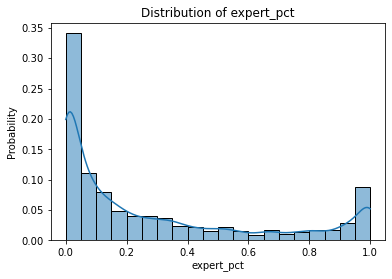

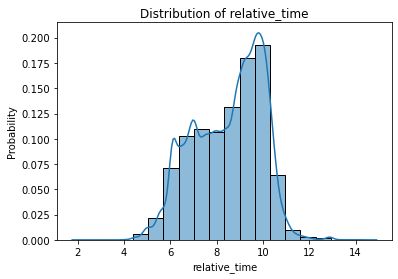

In [17]:
## look at data distributions for expert_pct and relative_time
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
author_vars = ['expert_pct', 'relative_time']
for author_var_i in author_vars:
    sns.histplot(data=question_author_data, x=author_var_i, stat='probability', bins=20, kde=True)
    plt.title(f'Distribution of {author_var_i}')
    plt.show()

Let's experiment with some different cutoff values to determine how to identify groups with maximally different questions.

In [68]:
import numpy as np
pct_cutoffs = [10, 25, 50, 75, 90]
author_var_cutoff_data = []
for subreddit_i, data_i in question_author_data.groupby('subreddit'):
    for pct_cutoff_j in pct_cutoffs:
        for author_var_k in author_vars:
            cutoff_k = np.percentile(data_i.loc[:, author_var_k], pct_cutoff_j)
            cutoff_var_name_k = f'{author_var_k}>{pct_cutoff_j}'
            data_i = data_i.assign(**{
                cutoff_var_name_k : np.digitize(data_i.loc[:, author_var_k].values, [cutoff_k])
            })
    author_var_cutoff_data.append(data_i)
author_var_cutoff_data = pd.concat(author_var_cutoff_data, axis=0)

In [81]:
## save data to reboot GPU
author_var_cutoff_data.to_csv('../../data/reddit_data/group_classification_model/author_var_cutoff_data.gz', sep='\t', compression='gzip', index=False)

In [82]:
!ls -halt ../../data/reddit_data/group_classification_model/author_var_cutoff_data.gz

-rw-rw-r-- 1 ianbstew ianbstew 1.9G Oct 20 23:25 ../../data/reddit_data/group_classification_model/author_var_cutoff_data.gz


How easily can a classifier differentiate the author groups for the different groups?

We'll try an aggregate approach first and then per-subreddit if that doesn't work.

In [2]:
# reload data
import pandas as pd
author_var_cutoff_data = pd.read_csv('../../data/reddit_data/group_classification_model/author_var_cutoff_data.gz', sep='\t', compression='gzip')

In [51]:
## train, test
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import train_test_reader_group_classification
combined_text_var = 'PCA_question_post_encoded'
author_vars = ['expert_pct', 'relative_time']
cutoff_var_scores = []
acc_score_vars = ['model_acc', 'F1_macro', 'AUC']
for author_var_i in author_vars:
    print(f'testing author var = {author_var_i}')
    pct_cutoff_vars_i = list(filter(lambda x: x.startswith(author_var_i+'>'), author_var_cutoff_data.columns))
    for pct_cutoff_var_j in pct_cutoff_vars_i:
        ## train/test classifier
        print(f'testing cutoff var = {pct_cutoff_var_j}')
        cutoff_var_scores_j = train_test_reader_group_classification(author_var_cutoff_data, class_var=pct_cutoff_var_j,
                                                                     text_var=combined_text_var, post_var=None,
                                                                     subgroup_var=None)
        # compute means
        mean_cutoff_var_scores_j = cutoff_var_scores_j.loc[:, acc_score_vars].mean(axis=0)
        mean_cutoff_var_scores_j.loc['author_var_cutoff'] = pct_cutoff_var_j
        mean_cutoff_var_scores_j.loc['author_var'] = author_var_i
        cutoff_var_scores.append(mean_cutoff_var_scores_j)
cutoff_var_scores = pd.concat(cutoff_var_scores, axis=1).transpose()
display(cutoff_var_scores)

testing author var = expert_pct
testing cutoff var = expert_pct>10


100%|██████████| 10/10 [12:34<00:00, 75.44s/it]


testing cutoff var = expert_pct>25


100%|██████████| 10/10 [35:49<00:00, 214.93s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [1:02:27<00:00, 374.75s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [1:04:28<00:00, 386.83s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [1:04:11<00:00, 385.14s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [1:09:52<00:00, 419.24s/it]


,model_acc,F1_macro,AUC,author_var_cutoff,author_var
0,0.540275,0.419688,0.933436,expert_pct>10,expert_pct
1,0.535432,0.485231,0.602746,expert_pct>25,expert_pct
2,0.509309,0.508313,0.51421,expert_pct>50,expert_pct
3,0.508455,0.481266,0.514149,relative_time>10,relative_time
4,0.505772,0.478452,0.510212,relative_time>25,relative_time
5,0.505752,0.478838,0.512573,relative_time>50,relative_time


In [64]:
## train/test per subreddit
min_class_cutoff = 1000
subreddit_pred_scores = []
for subreddit_i, data_i in author_var_cutoff_data.groupby('subreddit'):
    print(f'testing subreddit = {subreddit_i}')
    for author_var_j in author_vars:
        print(f'testing author var = {author_var_j}')
        pct_cutoff_vars_j = list(filter(lambda x: x.startswith(author_var_j+'>'), data_i.columns))
        for pct_cutoff_var_k in pct_cutoff_vars_j:
            ## train/test classifier
            if(data_i.loc[:, pct_cutoff_var_k].nunique() > 1 and data_i.loc[:, pct_cutoff_var_k].value_counts().min() > min_class_cutoff):
                print(f'testing cutoff var = {pct_cutoff_var_k}')
                cutoff_var_scores_k = train_test_reader_group_classification(data_i, class_var=pct_cutoff_var_k,
                                                                             text_var=combined_text_var, post_var=None,
                                                                             subgroup_var=None)
                # compute means
                mean_cutoff_var_scores_k = cutoff_var_scores_k.loc[:, acc_score_vars].mean(axis=0)
                mean_cutoff_var_scores_k.loc['author_var_cutoff'] = pct_cutoff_var_k
                mean_cutoff_var_scores_k.loc['author_var'] = author_var_j
                mean_cutoff_var_scores_k.loc['subreddit'] = subreddit_i
                subreddit_pred_scores.append(mean_cutoff_var_scores_k)
subreddit_pred_scores = pd.concat(subreddit_pred_scores, axis=1).transpose()

testing subreddit = Advice
testing author var = expert_pct
testing cutoff var = expert_pct>25


100%|██████████| 10/10 [05:22<00:00, 32.28s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [04:12<00:00, 25.26s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [04:29<00:00, 26.96s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [04:40<00:00, 28.03s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [04:36<00:00, 27.63s/it]


testing subreddit = AmItheAsshole
testing author var = expert_pct
testing cutoff var = expert_pct>50


100%|██████████| 10/10 [10:27<00:00, 62.71s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [10:22<00:00, 62.30s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [09:52<00:00, 59.30s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [10:12<00:00, 61.26s/it]


testing subreddit = legaladvice
testing author var = expert_pct
testing cutoff var = expert_pct>25


100%|██████████| 10/10 [05:17<00:00, 31.78s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [04:54<00:00, 29.47s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [04:50<00:00, 29.02s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [04:47<00:00, 28.76s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [04:47<00:00, 28.74s/it]


testing subreddit = pcmasterrace
testing author var = expert_pct
testing cutoff var = expert_pct>10


100%|██████████| 10/10 [02:33<00:00, 15.31s/it]


testing cutoff var = expert_pct>25


100%|██████████| 10/10 [02:59<00:00, 17.94s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [02:44<00:00, 16.48s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [02:46<00:00, 16.64s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [02:42<00:00, 16.28s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [02:45<00:00, 16.50s/it]


testing subreddit = personalfinance
testing author var = expert_pct
testing cutoff var = expert_pct>25


100%|██████████| 10/10 [05:17<00:00, 31.78s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [05:16<00:00, 31.63s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [05:28<00:00, 32.80s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [05:28<00:00, 32.90s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [05:30<00:00, 33.01s/it]


In [65]:
display(subreddit_pred_scores)

,model_acc,F1_macro,AUC,author_var_cutoff,author_var,subreddit
0,0.499739,0.443067,0.497541,expert_pct>25,expert_pct,Advice
1,0.518798,0.517028,0.524537,expert_pct>50,expert_pct,Advice
2,0.503592,0.452851,0.506605,relative_time>10,relative_time,Advice
3,0.498933,0.446414,0.50712,relative_time>25,relative_time,Advice
4,0.504838,0.454001,0.508914,relative_time>50,relative_time,Advice
5,0.504051,0.501617,0.505157,expert_pct>50,expert_pct,AmItheAsshole
6,0.496346,0.469584,0.490269,relative_time>10,relative_time,AmItheAsshole
7,0.494976,0.468008,0.493963,relative_time>25,relative_time,AmItheAsshole
8,0.496742,0.466796,0.49276,relative_time>50,relative_time,AmItheAsshole
9,0.51189,0.462141,0.523749,expert_pct>25,expert_pct,legaladvice


In [66]:
## just questions
## TODO: rerun with [75, 90]
min_class_cutoff = 1000
question_text_var = 'PCA_question_encoded'
subreddit_question_pred_scores = []
for subreddit_i, data_i in author_var_cutoff_data.groupby('subreddit'):
    print(f'testing subreddit = {subreddit_i}')
    for author_var_j in author_vars:
        print(f'testing author var = {author_var_j}')
        pct_cutoff_vars_j = list(filter(lambda x: x.startswith(author_var_j+'>'), data_i.columns))
        for pct_cutoff_var_k in pct_cutoff_vars_j:
            ## train/test classifier
            if(data_i.loc[:, pct_cutoff_var_k].nunique() > 1 and data_i.loc[:, pct_cutoff_var_k].value_counts().min() > min_class_cutoff):
                print(f'testing cutoff var = {pct_cutoff_var_k}')
                cutoff_var_scores_k = train_test_reader_group_classification(data_i, class_var=pct_cutoff_var_k,
                                                                             text_var=question_text_var, post_var=None,
                                                                             subgroup_var=None)
                # compute means
                mean_cutoff_var_scores_k = cutoff_var_scores_k.loc[:, acc_score_vars].mean(axis=0)
                mean_cutoff_var_scores_k.loc['author_var_cutoff'] = pct_cutoff_var_k
                mean_cutoff_var_scores_k.loc['author_var'] = author_var_j
                mean_cutoff_var_scores_k.loc['subreddit'] = subreddit_i
                subreddit_question_pred_scores.append(mean_cutoff_var_scores_k)
subreddit_question_pred_scores = pd.concat(subreddit_question_pred_scores, axis=1).transpose()

testing subreddit = Advice
testing author var = expert_pct
testing cutoff var = expert_pct>25


100%|██████████| 10/10 [08:39<00:00, 51.98s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [08:36<00:00, 51.64s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [08:48<00:00, 52.85s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [09:02<00:00, 54.21s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [09:02<00:00, 54.29s/it]


testing subreddit = AmItheAsshole
testing author var = expert_pct
testing cutoff var = expert_pct>50


100%|██████████| 10/10 [41:08<00:00, 246.84s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [41:58<00:00, 251.81s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [42:30<00:00, 255.06s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [42:06<00:00, 252.66s/it]


testing subreddit = legaladvice
testing author var = expert_pct
testing cutoff var = expert_pct>25


100%|██████████| 10/10 [10:17<00:00, 61.75s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [09:33<00:00, 57.36s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [09:01<00:00, 54.17s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [09:05<00:00, 54.53s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [10:17<00:00, 61.80s/it]


testing subreddit = pcmasterrace
testing author var = expert_pct
testing cutoff var = expert_pct>10


100%|██████████| 10/10 [03:40<00:00, 22.07s/it]


testing cutoff var = expert_pct>25


100%|██████████| 10/10 [05:03<00:00, 30.38s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [04:53<00:00, 29.38s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [04:20<00:00, 26.07s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [04:43<00:00, 28.31s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [04:34<00:00, 27.41s/it]


testing subreddit = personalfinance
testing author var = expert_pct
testing cutoff var = expert_pct>25


100%|██████████| 10/10 [12:05<00:00, 72.56s/it]


testing cutoff var = expert_pct>50


100%|██████████| 10/10 [12:29<00:00, 74.91s/it]


testing author var = relative_time
testing cutoff var = relative_time>10


100%|██████████| 10/10 [13:45<00:00, 82.57s/it]


testing cutoff var = relative_time>25


100%|██████████| 10/10 [13:25<00:00, 80.55s/it]


testing cutoff var = relative_time>50


100%|██████████| 10/10 [13:16<00:00, 79.61s/it]


In [67]:
display(subreddit_question_pred_scores)

,model_acc,F1_macro,AUC,author_var_cutoff,author_var,subreddit
0,0.498153,0.466133,0.499057,expert_pct>25,expert_pct,Advice
1,0.511217,0.509677,0.517154,expert_pct>50,expert_pct,Advice
2,0.504475,0.476548,0.497513,relative_time>10,relative_time,Advice
3,0.500024,0.471722,0.49854,relative_time>25,relative_time,Advice
4,0.501922,0.47312,0.498504,relative_time>50,relative_time,Advice
5,0.502294,0.501711,0.502501,expert_pct>50,expert_pct,AmItheAsshole
6,0.495032,0.477975,0.490585,relative_time>10,relative_time,AmItheAsshole
7,0.494389,0.476841,0.492198,relative_time>25,relative_time,AmItheAsshole
8,0.497816,0.480937,0.495301,relative_time>50,relative_time,AmItheAsshole
9,0.512524,0.483496,0.518569,expert_pct>25,expert_pct,legaladvice


These scores are pretty low! Let's try using a regular BOW representation to see if we can get stronger signals from the training data.

In [4]:
## TODO: use BoW + SVM
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WordPunctTokenizer
from stop_words import get_stop_words
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
def train_test_BOW_model(data, text_var, class_var):
    tokenizer = WordPunctTokenizer()
    en_stops = get_stop_words('en')
    cv = CountVectorizer(min_df=0.001, max_df=0.5, stop_words=en_stops, tokenizer=tokenizer.tokenize)
    dtm = cv.fit_transform(data.loc[:, text_var].values)
    vocab = list(sorted(cv.vocabulary_, key=cv.vocabulary_.get))
    n_folds = 10
    k_fold = StratifiedKFold(n_folds)
    Y = data.loc[:, class_var].values
    model_scores = []
    for train_idx, test_idx in k_fold.split(dtm, Y):
        X_train, X_test = dtm[train_idx, :], dtm[test_idx, :]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        model = SVC(C=1., kernel='rbf', probability=True)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        Y_prob = model.predict_proba(X_test)
        acc = (Y_test==Y_pred).sum() / len(Y_test)
        f1 = f1_score(Y_test, Y_pred, average='macro')
        auc = roc_auc_score(Y_test, Y_prob[:, 1])
        model_scores.append([acc, f1, auc])
    model_scores = pd.DataFrame(model_scores, columns=['acc', 'F1', 'AUC'])
    mean_model_scores = model_scores.mean(axis=0)
    return mean_model_scores

In [10]:
text_var = 'question'
per_subreddit_bow_model_scores = []
author_vars = ['expert_pct', 'relative_time']
min_class_cutoff = 1000
for subreddit_i, data_i in author_var_cutoff_data.groupby('subreddit'):
    print(f'subreddit = {subreddit_i}')
    for author_var_j in author_vars:
        print(f'testing author var = {author_var_j}')
        pct_cutoff_vars_j = list(filter(lambda x: x.startswith(author_var_j+'>'), data_i.columns))
        for pct_cutoff_var_k in pct_cutoff_vars_j:
            if(data_i.loc[:, pct_cutoff_var_k].nunique() > 1 and data_i.loc[:, pct_cutoff_var_k].value_counts().min() > min_class_cutoff):
                print(f'cutoff = {pct_cutoff_var_k}')
                model_scores_i = train_test_BOW_model(data_i, text_var, pct_cutoff_var_k)
                model_scores_i.loc['subreddit'] = subreddit_i
                model_scores_i.loc['author_var_cutoff'] = pct_cutoff_var_k
                model_scores_i.loc['author_var'] = author_var_j
                print(model_scores_i)
                per_subreddit_bow_model_scores.append(model_scores_i)
per_subreddit_bow_model_scores = pd.concat(per_subreddit_bow_model_scores, axis=1).transpose()

subreddit = Advice
testing author var = expert_pct
cutoff = expert_pct>25


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                       0.744441
F1                        0.433846
AUC                       0.505892
subreddit                   Advice
author_var_cutoff    expert_pct>25
author_var              expert_pct
dtype: object
cutoff = expert_pct>50


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                       0.509929
F1                        0.504267
AUC                       0.517511
subreddit                   Advice
author_var_cutoff    expert_pct>50
author_var              expert_pct
dtype: object
cutoff = expert_pct>75


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                       0.748494
F1                        0.454521
AUC                       0.524711
subreddit                   Advice
author_var_cutoff    expert_pct>75
author_var              expert_pct
dtype: object
cutoff = expert_pct>90


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                          0.744155
F1                           0.433137
AUC                          0.504682
subreddit                      Advice
author_var_cutoff    relative_time>10
author_var              relative_time
dtype: object
cutoff = relative_time>25


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                          0.744155
F1                           0.433137
AUC                          0.504686
subreddit                      Advice
author_var_cutoff    relative_time>25
author_var              relative_time
dtype: object
cutoff = relative_time>50


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                          0.744155
F1                           0.433137
AUC                          0.504688
subreddit                      Advice
author_var_cutoff    relative_time>50
author_var              relative_time
dtype: object
cutoff = relative_time>75


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


acc                          0.744155
F1                           0.433137
AUC                          0.504686
subreddit                      Advice
author_var_cutoff    relative_time>75
author_var              relative_time
dtype: object
cutoff = relative_time>90


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


KeyboardInterrupt: 

In [79]:
display(per_subreddit_bow_model_scores)

acc    0.898407
F1     0.480710
AUC    0.509580
dtype: float64
Advice


In [ ]:
## TODO: use buffers e.g. expert_pct < 50-10 => "novice" and expert_pct > 50+10 => "expert"

In [ ]:
## TODO: increase min post count for inferring expert, relative time info

### Test models on reader-specific questions: per-subreddit models
We have updated the reader group classification task to generate a separate model for every subreddit.

Let's see if these models do a better job at identifying questions with high likelihood of being written by specific reader groups!

Note: we will have to load $M$ subreddits * $G$ reader groups = $15$ models to get this to work. Yikes!!

In [41]:
## load test data, subreddits, etc.
import torch
import pandas as pd
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas().drop(['source_ids', 'target_ids', 'attention_mask', 'subreddit_embed', 'text_embed', 'source_ids_reader_token', 'source_text_reader_token'], axis=1)
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', usecols=['id', 'subreddit']).rename(columns={'id' : 'article_id'})
test_data = pd.merge(test_data, post_data, on='article_id')
## add reader group categories
reader_group_category_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in reader_group_category_lookup.items() for v1 in v
}
# fix column names
test_data.rename(columns={'reader_token_str' : 'reader_group', 'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
test_data = test_data.assign(**{
    'group_category' : test_data.loc[:, 'reader_group'].apply(reader_group_category_lookup.get)
})
print(test_data.loc[:, 'subreddit'].value_counts())
print(test_data.loc[:, ['subreddit', 'group_category']].value_counts().sort_index())

AmItheAsshole      22531
personalfinance    11798
legaladvice         7424
Advice              7215
pcmasterrace        4112
Name: subreddit, dtype: int64
subreddit        group_category   
Advice           UNK                   1625
                 expert_pct_bin        2583
                 location_region        424
                 relative_time_bin     2583
AmItheAsshole    UNK                  12072
                 expert_pct_bin        4747
                 location_region        965
                 relative_time_bin     4747
legaladvice      UNK                   1789
                 expert_pct_bin        2597
                 location_region        441
                 relative_time_bin     2597
pcmasterrace     UNK                    833
                 expert_pct_bin        1516
                 location_region        247
                 relative_time_bin     1516
personalfinance  UNK                   5465
                 expert_pct_bin        2881
                 l

In [44]:
## compute sentence embeddings, compress via PCA, etc.
from model_helpers import load_sentence_embed_model
sentence_embed_model = load_sentence_embed_model()
# encode data
import torch
embed_vars = ['question', 'post']
for embed_var_i in embed_vars:
    encode_var_i = f'{embed_var_i}_encoded'
    encoding_i = sentence_embed_model.encode(test_data.loc[:, embed_var_i].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    test_data = test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })
## use PCA to compress data
import numpy as np
model_home_dir = '../../data/reddit_data/group_classification_model/'
PCA_question_embed_model = pickle.load(open(os.path.join(model_home_dir, 'PCA_model_embed=question_encoded.pkl'), 'rb'))
PCA_post_embed_model = pickle.load(open(os.path.join(model_home_dir, 'PCA_model_embed=post_encoded.pkl'), 'rb'))
PCA_models = [PCA_question_embed_model, PCA_post_embed_model]
for embed_var_i, PCA_model_i in zip(embed_vars, PCA_models):
    encode_var_i = f'{embed_var_i}_encoded'
    mat_i = np.vstack(test_data.loc[:, encode_var_i].values)
    reduce_mat_i = PCA_model_i.transform(mat_i)
    test_data = test_data.assign(**{
        f'PCA_{encode_var_i}': [reduce_mat_i[i, :] for i in range(reduce_mat_i.shape[0])]
    })
# combine representations
import numpy as np
test_data = test_data.assign(**{
    'PCA_question_post_encoded' : test_data.apply(lambda x: np.hstack([x.loc['PCA_question_encoded'], x.loc['PCA_post_encoded']]), axis=1)
})

In [50]:
## save data, reboot notebook, reload
test_data.to_csv('../../data/reddit_data/combined_data_test_data_encoding.gz', sep='\t', compression='gzip', index=False)

In [29]:
##
import pandas as pd
test_data = pd.read_csv('../../data/reddit_data/combined_data_test_data_encoding.gz', sep='\t', compression='gzip')
# fix format for post/question encoding
import numpy as np
from ast import literal_eval
import re
def str2array(s):
    # Remove space after [
    s=re.sub('\[ +', '[', s.strip())
    # Replace commas and spaces
    s=re.sub('[,\s]+', ', ', s)
    return np.array(literal_eval(s))
text_encode_var = 'PCA_question_post_encoded'
test_data = test_data.assign(**{
    text_encode_var : test_data.loc[:, text_encode_var].apply(str2array)
})
# fix class name for classification UGH
reader_group_category_class_lookup = {
    'expert_pct_bin' : {
        '<EXPERT_PCT_0_AUTHOR>' : 0,
        '<EXPERT_PCT_1_AUTHOR>' : 1,
    },
    'relative_time_bin' : {
        '<RESPONSE_TIME_0_AUTHOR>' : 0,
        '<RESPONSE_TIME_1_AUTHOR>' : 1,
    },
    'location_region' : {
        '<NONUS_AUTHOR>' : 'NONUS',
        '<US_AUTHOR>' : 'US',
    },
    'UNK' : {
        'UNK' : 'UNK'
    }
}
test_data = test_data.assign(**{
    'reader_group_class' : test_data.apply(lambda x: reader_group_category_class_lookup[x.loc['group_category']][x.loc['reader_group']], axis=1)
})
print(test_data.loc[:, ['group_category', 'reader_group_class']].value_counts().sort_index())

group_category     reader_group_class
UNK                UNK                   21784
expert_pct_bin     0                     10070
                   1                      4254
location_region    NONUS                  1189
                   US                     1459
relative_time_bin  0                      6079
                   1                      8245
dtype: int64


In [21]:
import os
import re
import pickle
from ast import literal_eval
model_dir = '../../data/reddit_data/group_classification_model/question_post_data/'
subreddits = test_data.loc[:, 'subreddit'].unique()
group_vars = list(set(test_data.loc[:, 'group_category'].unique()) - {'UNK'})
subreddit_group_model_lookup = {}
default_class_matcher = re.compile('(?<=class1\=).*(?=\.pkl)')
for subreddit_i in subreddits:
    model_dir_i = os.path.join(model_dir, subreddit_i)
    # load model
    for group_var_j in group_vars:
        model_file_matcher_i = re.compile(f'.*group={group_var_j}.*\.pkl')
        model_file_i = list(filter(lambda x: model_file_matcher_i.match(x) is not None, os.listdir(model_dir_i)))
        if(len(model_file_i) > 0):
            model_file_i = model_file_i[0]
            model_file_i = os.path.join(model_dir_i, model_file_i)
            # get default class
            default_class_i = default_class_matcher.search(model_file_i).group(0)
            if(default_class_i.isdigit()):
                default_class_i = literal_eval(default_class_i)
            model_i = pickle.load(open(model_file_i, 'rb'))
            subreddit_group_model_lookup[f'{subreddit_i};{group_var_j}'] = (model_i, default_class_i)

Now that we've loaded the data, for each question/answer pair written by reader group $G$ let's get (1) the highest-predicted category in $G$; (2) the probability $p$ of that prediction.

In [52]:
from itertools import product
reader_group_other_class_lookup = test_data.groupby('group_category').apply(lambda x: dict([(z[0], z[1]) for z in product(x.loc[:, 'reader_group_class'].unique(), x.loc[:, 'reader_group_class'].unique()) if z[0]!=z[1]]))
def get_model_class_prob(data, model_lookup, pred_var='PCA_question_post_encoded'):
    subreddit = data.loc["subreddit"]
    group_category = data.loc["group_category"]
    model, default_class = model_lookup[f'{subreddit};{group_category}']
    model_prob = model.predict_proba(data.loc[pred_var].reshape(1,-1))[0, :]
    max_class_idx = model_prob.argmax()
    max_class_prob = model_prob.max()
    if(max_class_idx == 1):
        max_class = default_class
    else:
        max_class = reader_group_other_class_lookup.loc[group_category][default_class]
    return max_class, max_class_prob

In [49]:
reader_group_test_data = test_data[test_data.loc[:, 'group_category']!='UNK']
print(reader_group_test_data.shape[0])

31296


In [58]:
get_model_class_prob(reader_group_test_data.iloc[2500, :], subreddit_group_model_lookup, pred_var='PCA_question_post_encoded')

(1, 0.9997098025185109)

In [61]:
from tqdm import tqdm
tqdm.pandas()
pred_var = 'PCA_question_post_encoded'
pred_class_prob_data = reader_group_test_data.progress_apply(lambda x: get_model_class_prob(x, subreddit_group_model_lookup, pred_var=pred_var), axis=1)
# fix variables etc.
reader_group_test_data = reader_group_test_data.assign(**{
    'pred_class' : list(map(lambda x: x[0], pred_class_prob_data)),
    'pred_class_prob' : list(map(lambda x: x[1], pred_class_prob_data)),
})

100%|██████████| 31296/31296 [00:11<00:00, 2837.25it/s]


Are the models' predictions generally accurate? I sure hope so!

In [88]:
from sklearn.metrics import f1_score
reader_group_pred_acc = (reader_group_test_data.loc[:, 'reader_group_class']==reader_group_test_data.loc[:, 'pred_class']).sum() / reader_group_test_data.shape[0]
print(f'pred acc = {reader_group_pred_acc:.3f}')
# check per-subreddit, per-group
subreddit_group_pred_acc = []
for (subreddit_i, group_i), data_i in reader_group_test_data.groupby(['subreddit', 'group_category']):
    class_vals_i = data_i.loc[:, 'reader_group_class'].values
    pred_vals_i = data_i.loc[:, 'pred_class'].values
    if(type(class_vals_i[0]) is int):
        class_vals_i = class_vals_i.astype(int)
        pred_vals_i = pred_vals_i.astype(int)
    f1_i = f1_score(class_vals_i, pred_vals_i, average='macro')
    subreddit_group_pred_acc.append([subreddit_i, group_i, f1_i])
subreddit_group_pred_acc = pd.DataFrame(subreddit_group_pred_acc, columns=['subreddit', 'group_category', 'F1'])
display(subreddit_group_pred_acc)
display(subreddit_group_pred_acc.groupby('group_category').apply(lambda x: x.loc[:, 'F1'].mean()))

pred acc = 0.604


,subreddit,group_category,F1
0,Advice,expert_pct_bin,0.527481
1,Advice,location_region,0.564684
2,Advice,relative_time_bin,0.513941
3,AmItheAsshole,expert_pct_bin,0.619168
4,AmItheAsshole,location_region,0.607193
5,AmItheAsshole,relative_time_bin,0.658012
6,legaladvice,expert_pct_bin,0.533633
7,legaladvice,location_region,0.460410
8,legaladvice,relative_time_bin,0.517634
9,pcmasterrace,expert_pct_bin,0.564523


group_category
expert_pct_bin       0.559652
location_region      0.501098
relative_time_bin    0.549990
dtype: float64

OK! Some of these results are worse than chance but that is likely due to data sparsity in training data, e.g. with `location_region` where location is not always a factor in questions on `pcmasterrace`.

What is the distribution of probabilities associated with the predictions, and can we restrict our data to questions with high probability of a reader class?

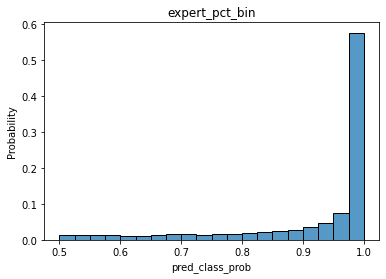

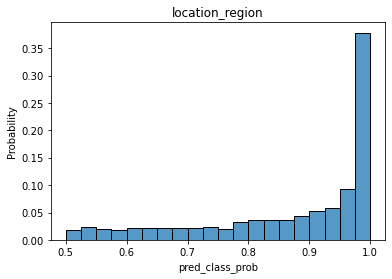

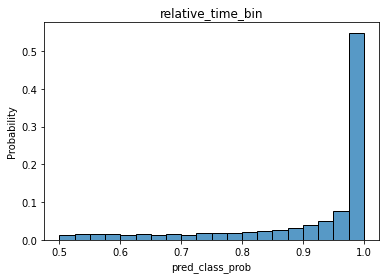

In [110]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
for group_i, data_i in reader_group_test_data.groupby('group_category'):
    sns.histplot(data=data_i, x='pred_class_prob', stat='probability', bins=20)
    plt.title(group_i)
    # plt.xlim([0.9, 1.0])
    plt.show()

Let's restrict to $p>0.95$ for each subgroup and see how the question generation models do on this subset of questions! Probably won't make a big difference.

In [127]:
import torch
full_test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas().drop(['source_ids', 'target_ids', 'attention_mask', 'subreddit_embed', 'text_embed', 'source_ids_reader_token', 'source_text_reader_token'], axis=1)
full_test_data.rename(columns={'reader_token_str' : 'reader_group', 'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
## add reader group categories
reader_group_category_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in reader_group_category_lookup.items() for v1 in v
}
full_test_data = full_test_data.assign(**{
    'group_category' : full_test_data.loc[:, 'reader_group'].apply(reader_group_category_lookup.get)
})

In [139]:
reader_attn_output[0]

'Did you file your 2017 federal tax return this year?'

In [140]:
## load generated text data
import gzip
text_only_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rt')))
reader_token_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_output_text.gz', 'rt')))
reader_attn_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_attention_data/author_attention_layer=5_location=encoder_config=attnconcat/test_data_output_text.gz', 'rt')))
model_output_types = ['text_only_model', 'reader_token_model', 'reader_attn_model']
model_output_data = [text_only_output, reader_token_output, reader_attn_output]
full_test_data = full_test_data.assign(**{
    x : y
    for x,y in zip(model_output_types, model_output_data)
})
reader_full_test_data = full_test_data[full_test_data.loc[:, 'reader_group']!='UNK']

In [141]:
# rejoin data
author_id_vars = ['author', 'id', 'group_category', 'question_id']
reader_pred_test_data = pd.merge(
    reader_group_test_data, 
    reader_full_test_data.loc[:, author_id_vars + model_output_types],
    on=author_id_vars,
    how='inner',
)
print(reader_pred_test_data.shape)

(31296, 21)


In [143]:
%%capture text_overlap_output
## compute overlap scores for all model types
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import test_question_overlap
from test_question_generation import STOP_WORDS
# suppress BLEU error message
import warnings
warnings.filterwarnings('ignore')
word_embed_file = '../../data/embeddings/wiki-news-300d-1M.vec.gz'
model_output_types = [
    'text_only_model',
    'reader_token_model',
    'reader_attn_model'
]
from nlp.arrow_dataset import Dataset
extra_test_cols = ['reader_group_class', 'pred_class']
reader_pred_test_data_torch = Dataset.from_pandas(reader_pred_test_data.drop(extra_test_cols, axis=1))
reader_pred_test_data_torch.rename_column_('question', 'target_text')
text_overlap_score_data = []
for model_output_type_i in model_output_types:
    print(f'model={model_output_type_i}')
    overlap_score_data_i = test_question_overlap(
        reader_pred_test_data.loc[:, model_output_type_i].values,
        reader_pred_test_data_torch,
        word_embed_file=word_embed_file,
        stop_words=STOP_WORDS,
    )
    # fix column names
    overlap_score_data_i.rename(columns={
        c : f'{c}_model={model_output_type_i.replace("_model","")}'
        for c in overlap_score_data_i.columns
    }, inplace=True)
    text_overlap_score_data.append(overlap_score_data_i)
text_overlap_score_data = pd.concat(text_overlap_score_data, axis=1)

In [144]:
text_overlap_output.show()

model=text_only_model
model=reader_token_model
missing tokens: pred tokens=['?!?!?']; test tokens=['how', 'old', 'are', 'you', '?']
model=reader_attn_model


31296it [07:14, 72.09it/s]
31296it [07:10, 72.69it/s]
31296it [07:14, 72.05it/s]


In [146]:
## add overlap data to reader pred data
reader_pred_text_overlap_data = pd.concat([
    reader_pred_test_data,
    text_overlap_score_data,
], axis=1)
print(reader_pred_text_overlap_data.shape)

(31296, 33)


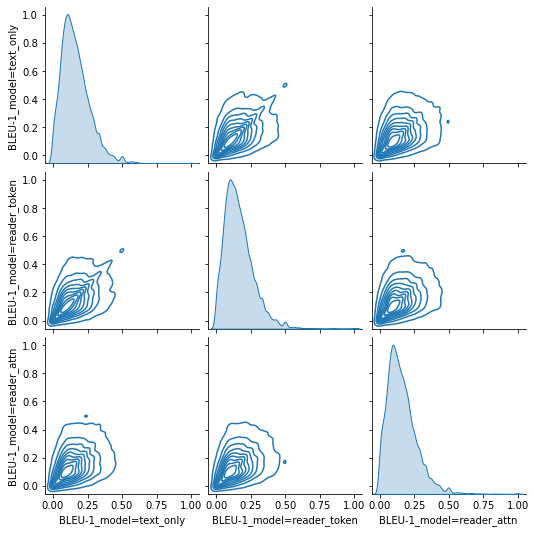

In [160]:
## look at overall score distributions
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_score_vars = list(filter(lambda x: x.startswith('BLEU-1'), reader_pred_text_overlap_data.columns))
sns.pairplot(data=reader_pred_text_overlap_data, vars=plot_score_vars, diag_kind='kde', kind='kde')
plt.show()

Let's look for possible correlations between $p$ (reader group probability) and overlap scores.

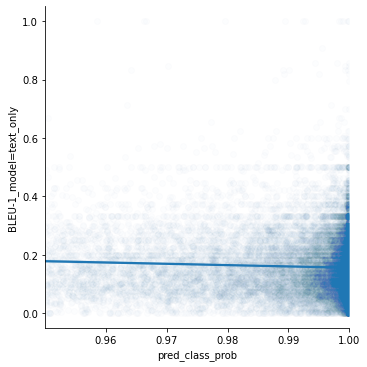

pred_class_prob vs. BLEU-1_model=text_only has correl=-0.073 (p=1.015E-24)


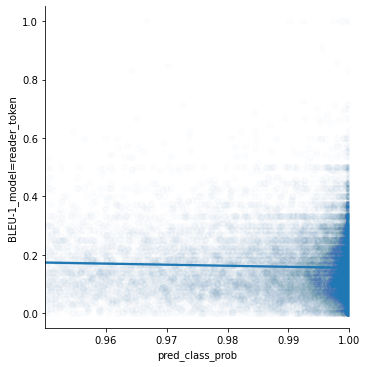

pred_class_prob vs. BLEU-1_model=reader_token has correl=-0.060 (p=4.725E-17)


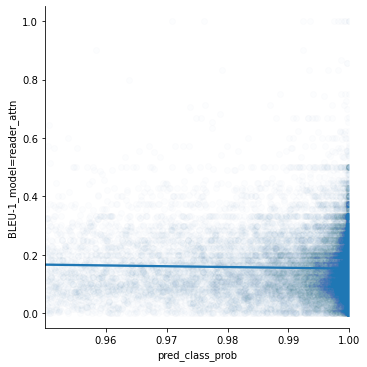

pred_class_prob vs. BLEU-1_model=reader_attn has correl=-0.053 (p=8.490E-14)


In [192]:
from scipy.stats import spearmanr
model_output_types = [
    'text_only_model',
    'reader_token_model',
    'reader_attn_model'
]
prob_cutoff = 0.95
prob_var = 'pred_class_prob'
prob_cutoff_text_overlap_data = reader_pred_text_overlap_data[reader_pred_text_overlap_data.loc[:, prob_var]>=prob_cutoff]
for model_i in model_output_types:
    model_name_i = model_i.replace("_model", "")
    score_var_i = f'BLEU-1_model={model_name_i}'
    sns.lmplot(data=prob_cutoff_text_overlap_data, x=prob_var, y=score_var_i, scatter_kws={'alpha':0.01})
    plt.show()
    # compute correlation
    correl, p_val = spearmanr(prob_cutoff_text_overlap_data.loc[:, prob_var].values,
                              prob_cutoff_text_overlap_data.loc[:, score_var_i].values)
    print(f'{prob_var} vs. {score_var_i} has correl={correl:.3f} (p={p_val:.3E})')

All models do worse for high reader class $p$, but the reader-aware models may have less of a problem? This could also mean that the reader-aware models have a lower "starting point."

Let's compare the models directly now.

BLEU-1_model=text_only       0.162843
BLEU-1_model=reader_token    0.162080
BLEU-1_model=reader_attn     0.158698
dtype: float64


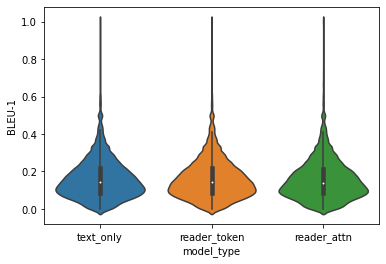

BLEU-1_model=text_only       0.158627
BLEU-1_model=reader_token    0.157515
BLEU-1_model=reader_attn     0.153738
dtype: float64


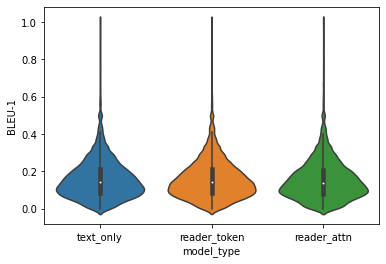

In [269]:
## flatten data for plots
overlap_var = 'BLEU-1'
plot_score_vars = list(filter(lambda x: x.startswith(overlap_var), reader_pred_text_overlap_data.columns))
flat_overlap_data = pd.melt(reader_pred_text_overlap_data, id_vars=['id', 'question_id', 'author', 'group_category', 'reader_group', 'pred_class_prob'], value_vars=plot_score_vars, value_name=overlap_var, var_name='model_type')
flat_overlap_data = flat_overlap_data.assign(**{
    'model_type' : flat_overlap_data.loc[:, 'model_type'].apply(lambda x: x.split('=')[-1])
})
## plot all overlap scores
print(reader_pred_text_overlap_data.loc[:, plot_score_vars].mean(axis=0))
sns.violinplot(data=flat_overlap_data, x='model_type', y=overlap_var)
plt.show()
## plot overlap scores for cutoff data
prob_cutoff = 0.95
pred_cutoff_flat_overlap_data = flat_overlap_data[flat_overlap_data.loc[:, 'pred_class_prob'] >= prob_cutoff]
print(reader_pred_text_overlap_data[(reader_pred_text_overlap_data.loc[:, 'pred_class_prob'] >= prob_cutoff) & (reader_pred_text_overlap_data.loc[:, 'reader_group_class']==reader_pred_text_overlap_data.loc[:, 'pred_class'])].loc[:, plot_score_vars].mean(axis=0))
sns.violinplot(data=pred_cutoff_flat_overlap_data, x='model_type', y=overlap_var)
plt.show()

Let's do the same thing, but for multiple cutoff percentiles.

overlap var = BLEU-1
      group_category  BLEU-1_model=text_only  BLEU-1_model=reader_token  \
0     expert_pct_bin                0.142857                   0.142857   
1    location_region                0.142857                   0.142857   
2  relative_time_bin                0.142857                   0.142857   

   BLEU-1_model=reader_attn  
0                   0.14108  
1                   0.13394  
2                   0.14108  


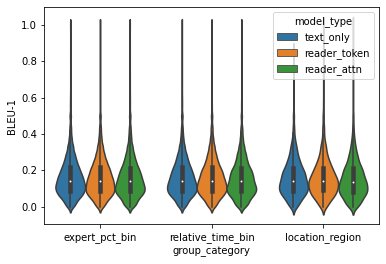

scores for cutoff pct >= 0


,group_category,subreddit,BLEU-1_model=text_only,BLEU-1_model=reader_token,BLEU-1_model=reader_attn,count
0,expert_pct_bin,Advice,0.174974,0.167953,0.173373,1637
1,expert_pct_bin,AmItheAsshole,0.145481,0.147405,0.141884,3336
2,expert_pct_bin,legaladvice,0.169288,0.164856,0.157667,1551
3,expert_pct_bin,pcmasterrace,0.186937,0.188616,0.181269,922
4,expert_pct_bin,personalfinance,0.163504,0.167100,0.167139,1814
5,location_region,Advice,0.167622,0.168946,0.165075,243
6,location_region,AmItheAsshole,0.145714,0.144087,0.139748,592
7,location_region,legaladvice,0.158712,0.166986,0.155703,204
8,location_region,pcmasterrace,0.185456,0.191586,0.157149,134
9,location_region,personalfinance,0.158140,0.157197,0.158427,261


,BLEU-1_model=text_only,BLEU-1_model=reader_token,BLEU-1_model=reader_attn
group_category,,,
expert_pct_bin,0.168037,0.167186,0.164266
location_region,0.163129,0.165761,0.155221
relative_time_bin,0.169495,0.167099,0.162111


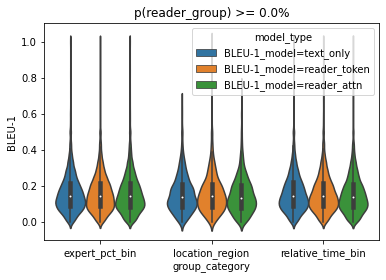

scores for cutoff pct >= 75


,group_category,subreddit,BLEU-1_model=text_only,BLEU-1_model=reader_token,BLEU-1_model=reader_attn,count
0,expert_pct_bin,Advice,0.174395,0.175565,0.178460,472
1,expert_pct_bin,AmItheAsshole,0.142611,0.140066,0.137600,882
2,expert_pct_bin,legaladvice,0.160425,0.157510,0.148032,447
3,expert_pct_bin,pcmasterrace,0.183113,0.188882,0.179588,273
4,expert_pct_bin,personalfinance,0.155530,0.156618,0.157286,515
5,location_region,Advice,0.157308,0.136510,0.140080,62
6,location_region,AmItheAsshole,0.134658,0.132577,0.130240,194
7,location_region,legaladvice,0.130736,0.169320,0.141718,54
8,location_region,pcmasterrace,0.152793,0.169861,0.139116,40
9,location_region,personalfinance,0.158898,0.157397,0.155522,68


,BLEU-1_model=text_only,BLEU-1_model=reader_token,BLEU-1_model=reader_attn
group_category,,,
expert_pct_bin,0.163215,0.163728,0.160193
location_region,0.146878,0.153133,0.141335
relative_time_bin,0.167618,0.167554,0.163797


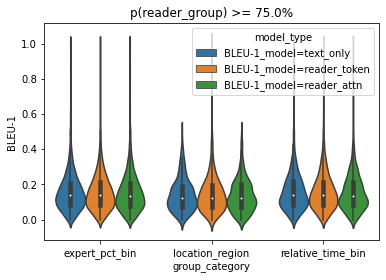

scores for cutoff pct >= 90


,group_category,subreddit,BLEU-1_model=text_only,BLEU-1_model=reader_token,BLEU-1_model=reader_attn,count
0,expert_pct_bin,Advice,0.167508,0.175230,0.173451,188
1,expert_pct_bin,AmItheAsshole,0.140580,0.129490,0.131693,362
2,expert_pct_bin,legaladvice,0.143136,0.148933,0.149045,182
3,expert_pct_bin,pcmasterrace,0.173688,0.178868,0.176463,109
4,expert_pct_bin,personalfinance,0.156776,0.156169,0.153721,199
5,location_region,Advice,0.141313,0.143692,0.125288,29
6,location_region,AmItheAsshole,0.133631,0.134546,0.121159,73
7,location_region,legaladvice,0.102677,0.163126,0.131397,22
8,location_region,pcmasterrace,0.141027,0.184497,0.128891,15
9,location_region,personalfinance,0.148787,0.123219,0.153597,22


,BLEU-1_model=text_only,BLEU-1_model=reader_token,BLEU-1_model=reader_attn
group_category,,,
expert_pct_bin,0.156338,0.157738,0.156875
location_region,0.133487,0.149816,0.132066
relative_time_bin,0.167461,0.166043,0.163320


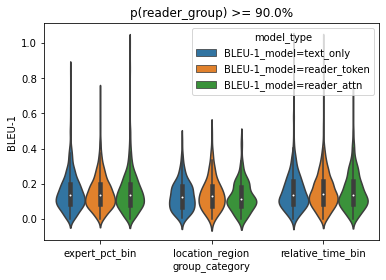

scores for cutoff pct >= 95


,group_category,subreddit,BLEU-1_model=text_only,BLEU-1_model=reader_token,BLEU-1_model=reader_attn,count
0,expert_pct_bin,Advice,0.179122,0.171333,0.175418,96
1,expert_pct_bin,AmItheAsshole,0.140628,0.127345,0.133372,184
2,expert_pct_bin,legaladvice,0.135406,0.147592,0.145292,95
3,expert_pct_bin,pcmasterrace,0.167552,0.195851,0.186003,53
4,expert_pct_bin,personalfinance,0.152566,0.139506,0.157641,96
5,location_region,Advice,0.157030,0.136618,0.120795,14
6,location_region,AmItheAsshole,0.119546,0.122655,0.104760,32
7,location_region,legaladvice,0.117274,0.169793,0.153404,12
8,location_region,pcmasterrace,0.136432,0.180843,0.128930,8
9,location_region,personalfinance,0.151843,0.144236,0.137181,11


,BLEU-1_model=text_only,BLEU-1_model=reader_token,BLEU-1_model=reader_attn
group_category,,,
expert_pct_bin,0.155055,0.156325,0.159545
location_region,0.136425,0.150829,0.129014
relative_time_bin,0.168768,0.174539,0.164562


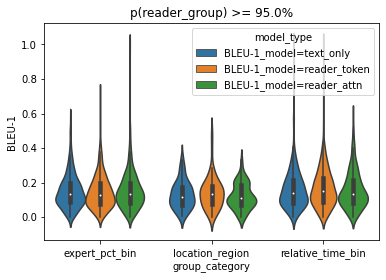

scores for cutoff pct >= 99


,group_category,subreddit,BLEU-1_model=text_only,BLEU-1_model=reader_token,BLEU-1_model=reader_attn,count
0,expert_pct_bin,Advice,0.226813,0.235251,0.203013,18
1,expert_pct_bin,AmItheAsshole,0.144331,0.141620,0.144119,37
2,expert_pct_bin,legaladvice,0.153393,0.160403,0.130672,18
3,expert_pct_bin,pcmasterrace,0.183960,0.230879,0.125471,12
4,expert_pct_bin,personalfinance,0.143236,0.128408,0.132256,22
5,location_region,Advice,0.147682,0.185691,0.084684,4
6,location_region,AmItheAsshole,0.112846,0.116861,0.099495,8
7,location_region,legaladvice,0.134397,0.175676,0.197477,4
8,location_region,pcmasterrace,0.247679,0.500000,0.250000,1
9,location_region,personalfinance,0.060653,0.133333,0.052108,1


,BLEU-1_model=text_only,BLEU-1_model=reader_token,BLEU-1_model=reader_attn
group_category,,,
expert_pct_bin,0.170347,0.179312,0.147106
location_region,0.140652,0.222312,0.136753
relative_time_bin,0.164239,0.164838,0.150574


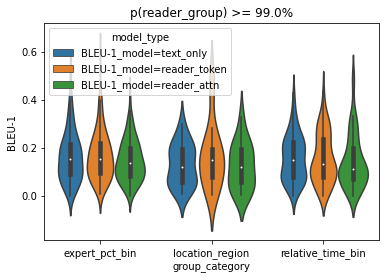

overlap var = ROUGE-L
      group_category  ROUGE-L_model=text_only  ROUGE-L_model=reader_token  \
0     expert_pct_bin                 0.117647                    0.117647   
1    location_region                 0.117647                    0.117647   
2  relative_time_bin                 0.117647                    0.117647   

   ROUGE-L_model=reader_attn  
0                   0.117647  
1                   0.117647  
2                   0.117647  


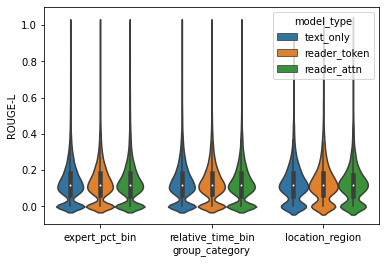

scores for cutoff pct >= 0


,group_category,subreddit,ROUGE-L_model=text_only,ROUGE-L_model=reader_token,ROUGE-L_model=reader_attn,count
0,expert_pct_bin,Advice,0.139077,0.133951,0.142306,1637
1,expert_pct_bin,AmItheAsshole,0.117229,0.118283,0.115488,3336
2,expert_pct_bin,legaladvice,0.136485,0.136220,0.125178,1551
3,expert_pct_bin,pcmasterrace,0.146078,0.148254,0.141808,922
4,expert_pct_bin,personalfinance,0.130805,0.133012,0.135766,1814
5,location_region,Advice,0.138597,0.136826,0.142068,243
6,location_region,AmItheAsshole,0.115121,0.113010,0.113707,592
7,location_region,legaladvice,0.124623,0.140458,0.127900,204
8,location_region,pcmasterrace,0.146908,0.157201,0.121418,134
9,location_region,personalfinance,0.123046,0.126694,0.130689,261


,ROUGE-L_model=text_only,ROUGE-L_model=reader_token,ROUGE-L_model=reader_attn
group_category,,,
expert_pct_bin,0.133935,0.133944,0.132109
location_region,0.129659,0.134838,0.127156
relative_time_bin,0.136171,0.135397,0.130125


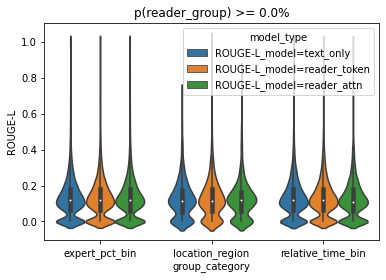

scores for cutoff pct >= 75


,group_category,subreddit,ROUGE-L_model=text_only,ROUGE-L_model=reader_token,ROUGE-L_model=reader_attn,count
0,expert_pct_bin,Advice,0.133718,0.138905,0.143943,472
1,expert_pct_bin,AmItheAsshole,0.115628,0.114417,0.113012,882
2,expert_pct_bin,legaladvice,0.125949,0.127074,0.109167,447
3,expert_pct_bin,pcmasterrace,0.127358,0.135832,0.133499,273
4,expert_pct_bin,personalfinance,0.126199,0.124804,0.126744,515
5,location_region,Advice,0.136254,0.122814,0.137664,62
6,location_region,AmItheAsshole,0.109071,0.105284,0.114155,194
7,location_region,legaladvice,0.102500,0.143089,0.111228,54
8,location_region,pcmasterrace,0.119841,0.145378,0.108320,40
9,location_region,personalfinance,0.118136,0.134650,0.138425,68


,ROUGE-L_model=text_only,ROUGE-L_model=reader_token,ROUGE-L_model=reader_attn
group_category,,,
expert_pct_bin,0.125771,0.128206,0.125273
location_region,0.117160,0.130243,0.121958
relative_time_bin,0.129015,0.132374,0.129613


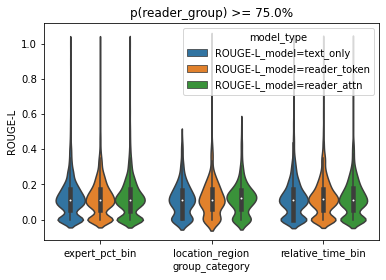

scores for cutoff pct >= 90


,group_category,subreddit,ROUGE-L_model=text_only,ROUGE-L_model=reader_token,ROUGE-L_model=reader_attn,count
0,expert_pct_bin,Advice,0.129201,0.139497,0.134275,188
1,expert_pct_bin,AmItheAsshole,0.115718,0.102949,0.103793,362
2,expert_pct_bin,legaladvice,0.107493,0.117751,0.110011,182
3,expert_pct_bin,pcmasterrace,0.111558,0.112328,0.120401,109
4,expert_pct_bin,personalfinance,0.119375,0.116441,0.119942,199
5,location_region,Advice,0.126375,0.135828,0.130467,29
6,location_region,AmItheAsshole,0.115171,0.117400,0.114744,73
7,location_region,legaladvice,0.091292,0.145409,0.106858,22
8,location_region,pcmasterrace,0.100728,0.182211,0.088982,15
9,location_region,personalfinance,0.097842,0.082868,0.132673,22


,ROUGE-L_model=text_only,ROUGE-L_model=reader_token,ROUGE-L_model=reader_attn
group_category,,,
expert_pct_bin,0.116669,0.117793,0.117684
location_region,0.106282,0.132743,0.114745
relative_time_bin,0.130497,0.130626,0.128138


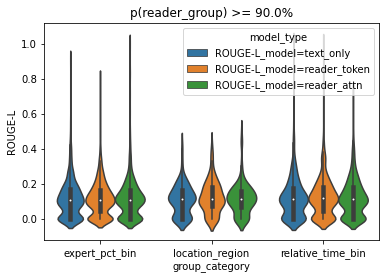

scores for cutoff pct >= 95


,group_category,subreddit,ROUGE-L_model=text_only,ROUGE-L_model=reader_token,ROUGE-L_model=reader_attn,count
0,expert_pct_bin,Advice,0.139875,0.132663,0.135705,96
1,expert_pct_bin,AmItheAsshole,0.115646,0.100959,0.107797,184
2,expert_pct_bin,legaladvice,0.095107,0.112830,0.096116,95
3,expert_pct_bin,pcmasterrace,0.103543,0.124106,0.130317,53
4,expert_pct_bin,personalfinance,0.111888,0.098057,0.128270,96
5,location_region,Advice,0.157015,0.143621,0.119796,14
6,location_region,AmItheAsshole,0.112965,0.114425,0.111510,32
7,location_region,legaladvice,0.093261,0.141920,0.112679,12
8,location_region,pcmasterrace,0.089850,0.171013,0.065035,8
9,location_region,personalfinance,0.071869,0.071670,0.122908,11


,ROUGE-L_model=text_only,ROUGE-L_model=reader_token,ROUGE-L_model=reader_attn
group_category,,,
expert_pct_bin,0.113212,0.113723,0.119641
location_region,0.104992,0.128530,0.106386
relative_time_bin,0.132098,0.136578,0.125434


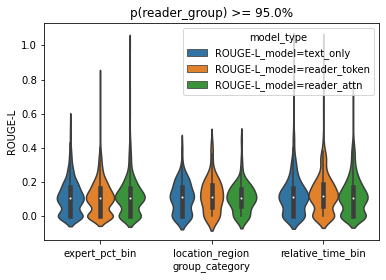

scores for cutoff pct >= 99


,group_category,subreddit,ROUGE-L_model=text_only,ROUGE-L_model=reader_token,ROUGE-L_model=reader_attn,count
0,expert_pct_bin,Advice,0.164758,0.172657,0.128591,18
1,expert_pct_bin,AmItheAsshole,0.116566,0.115294,0.113631,37
2,expert_pct_bin,legaladvice,0.099373,0.105946,0.053573,18
3,expert_pct_bin,pcmasterrace,0.117466,0.161899,0.074260,12
4,expert_pct_bin,personalfinance,0.120588,0.103136,0.119299,22
5,location_region,Advice,0.152946,0.179365,0.069794,4
6,location_region,AmItheAsshole,0.110142,0.130368,0.126393,8
7,location_region,legaladvice,0.090126,0.140278,0.166288,4
8,location_region,pcmasterrace,0.307692,0.428571,0.142857,1
9,location_region,personalfinance,0.000000,0.076923,0.000000,1


,ROUGE-L_model=text_only,ROUGE-L_model=reader_token,ROUGE-L_model=reader_attn
group_category,,,
expert_pct_bin,0.123750,0.131786,0.097871
location_region,0.132181,0.191101,0.101066
relative_time_bin,0.131410,0.127979,0.116171


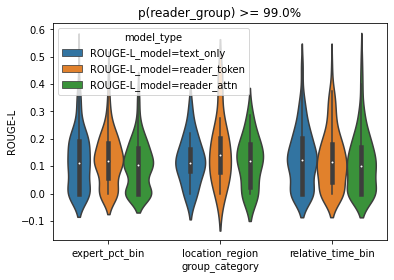

In [259]:
overlap_vars = ['BLEU-1', 'ROUGE-L']
for overlap_var in overlap_vars:
    print(f'overlap var = {overlap_var}')
    plot_score_vars = list(filter(lambda x: x.startswith(overlap_var), reader_pred_text_overlap_data.columns))
    flat_overlap_data = pd.melt(reader_pred_text_overlap_data, id_vars=['id', 'question_id', 'author', 'group_category', 'reader_group', 'pred_class_prob'], value_vars=plot_score_vars, value_name=overlap_var, var_name='model_type')
    flat_overlap_data = flat_overlap_data.assign(**{
        'model_type' : flat_overlap_data.loc[:, 'model_type'].apply(lambda x: x.split('=')[-1])
    })
    ## plot overlap scores per reader group
    print(reader_pred_text_overlap_data.groupby('group_category').apply(lambda x: x.loc[:, plot_score_vars].median(axis=0)).reset_index())
    sns.violinplot(data=flat_overlap_data, x='group_category', hue='model_type', y=overlap_var)
    plt.show()
    ## plot overlap scores for different cutoff points
    prob_cutoff_val_pcts = [0, 75, 90, 95, 99]
    for prob_cutoff_val_pct_i in prob_cutoff_val_pcts:
        # get cutoff for each group category
        reader_pred_text_overlap_data_i = []
        for (group_j, subreddit_j), data_j in reader_pred_text_overlap_data.groupby(['group_category', 'subreddit']):
            prob_cutoff_val_j = np.percentile(data_j.loc[:, 'pred_class_prob'], prob_cutoff_val_pct_i)
    #         print(f'cutoff_pct={prob_cutoff_val_pct_i}; group={group_j}; cutoff={prob_cutoff_val_j}')
            reader_pred_text_overlap_data_j = data_j[(data_j.loc[:, 'pred_class_prob']>=prob_cutoff_val_j) & 
                                                     (data_j.loc[:, 'reader_group_class']==data_j.loc[:, 'pred_class'])]

            reader_pred_text_overlap_data_i.append(reader_pred_text_overlap_data_j)
        reader_pred_text_overlap_data_i = pd.concat(reader_pred_text_overlap_data_i, axis=0)
        pred_cutoff_flat_overlap_data_i = pd.melt(reader_pred_text_overlap_data_i, id_vars=['id', 'question_id', 'author', 'group_category', 'reader_group', 'pred_class_prob'], value_vars=plot_score_vars, value_name=overlap_var, var_name='model_type')
        score_per_group_i = reader_pred_text_overlap_data_i.groupby(['group_category', 'subreddit']).apply(lambda x: x.loc[:, plot_score_vars].mean(axis=0)).reset_index()
        # add counts lol
        score_per_group_i = score_per_group_i.assign(**{
            'count' : reader_pred_text_overlap_data_i.groupby(['group_category', 'subreddit']).apply(lambda x: x.shape[0]).values
        })
        print(f'scores for cutoff pct >= {prob_cutoff_val_pct_i}')
        # scores per subreddit
        display(score_per_group_i)
        # aggregate scores
        display(score_per_group_i.groupby("group_category").apply(lambda x: x.loc[:, plot_score_vars].mean(axis=0)))
        sns.violinplot(data=pred_cutoff_flat_overlap_data_i, x='group_category', hue='model_type', y=overlap_var)
        plt.title(f'p(reader_group) >= {prob_cutoff_val_pct_i:.1f}%')
        plt.show()

OK! We have our answer: all models do worse for high-$p$ data, and the reader-token model does better than the text-only model for the extreme cases of `expert_pct` and `location_region`. 



### Test reader group probability on generated text
Now, let's see whether the reader-aware models tend to generate text that the classifier believes to be written by the given reader group.

In [1]:
## load test data, subreddits, etc.
import torch
import pandas as pd
test_data = torch.load('../../data/reddit_data/combined_data_test_data.pt').data.to_pandas().drop(['source_ids', 'target_ids', 'attention_mask', 'subreddit_embed', 'text_embed', 'source_ids_reader_token', 'source_text_reader_token'], axis=1)
post_data = pd.read_csv('../../data/reddit_data/subreddit_submissions_2018-01_2019-12.gz', sep='\t', compression='gzip', usecols=['id', 'subreddit']).rename(columns={'id' : 'article_id'})
test_data = pd.merge(test_data, post_data, on='article_id')
## add reader group categories
reader_group_category_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in reader_group_category_lookup.items() for v1 in v
}
# fix column names
test_data.rename(columns={'reader_token_str' : 'reader_group', 'source_text' : 'post', 'target_text' : 'question'}, inplace=True)
test_data = test_data.assign(**{
    'group_category' : test_data.loc[:, 'reader_group'].apply(reader_group_category_lookup.get)
})
## add reader group categories
reader_group_category_lookup = {
    'expert_pct_bin' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
    'relative_time_bin' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
    'location_region' : ['<NONUS_AUTHOR>', '<US_AUTHOR>'],
    'UNK' : ['UNK']
}
reader_group_category_lookup = {
    v1 : k for k, v in reader_group_category_lookup.items() for v1 in v
}
test_data = test_data.assign(**{
    'group_category' : test_data.loc[:, 'reader_group'].apply(reader_group_category_lookup.get)
})
## load generated text data
import gzip
text_only_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/text_only_model/test_data_output_text.gz', 'rt')))
reader_token_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/test_data_output_text.gz', 'rt')))
reader_attn_output = list(map(lambda x: x.strip(), gzip.open('../../data/reddit_data/author_text_data/author_attention_data/author_attention_layer=5_location=encoder_config=attnconcat/test_data_output_text.gz', 'rt')))
model_output_types = ['text_only_model', 'reader_token_model', 'reader_attn_model']
model_output_data = [text_only_output, reader_token_output, reader_attn_output]
test_data = test_data.assign(**{
    x : y
    for x,y in zip(model_output_types, model_output_data)
})
reader_test_data = test_data[test_data.loc[:, 'reader_group']!='UNK']

In [5]:
## reload test data
## compute sentence embeddings, compress via PCA, etc.
from model_helpers import load_sentence_embed_model
sentence_embed_model = load_sentence_embed_model()
## encode data
import torch
embed_vars = ['question', 'post']
# get post embed
post_encoding = sentence_embed_model.encode(reader_test_data.loc[:, 'post'].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
reader_test_data = reader_test_data.assign(**{
    'post_encoded' : [post_encoding[i, :] for i in range(post_encoding.shape[0])]
})
# get question embeds
for model_type_i in model_output_types:
    encode_var_i = f'question_encoded_model={model_type_i}'
    encoding_i = sentence_embed_model.encode(reader_test_data.loc[:, model_type_i].values, batch_size=16, device=torch.cuda.current_device(), show_progress_bar=True)
    reader_test_data = reader_test_data.assign(**{
        encode_var_i : [encoding_i[i, :] for i in range(encoding_i.shape[0])],
    })
## use PCA to compress data
import numpy as np
model_home_dir = '../../data/reddit_data/group_classification_model/'
PCA_question_embed_model = pickle.load(open(os.path.join(model_home_dir, 'PCA_model_embed=question_encoded.pkl'), 'rb'))
PCA_post_embed_model = pickle.load(open(os.path.join(model_home_dir, 'PCA_model_embed=post_encoded.pkl'), 'rb'))
# get post embed
post_embed_mat = np.vstack(reader_test_data.loc[:, 'post_encoded'].values)
post_reduce_embed_mat = PCA_post_embed_model.transform(post_embed_mat)
reader_test_data = reader_test_data.assign(**{
    'PCA_post_encoded' : [post_reduce_embed_mat[i, :] for i in range(post_reduce_embed_mat.shape[0])]
})
# get question embeds
for model_type_i in model_output_types:
    encode_var_i = f'question_encoded_model={model_type_i}'
    mat_i = np.vstack(reader_test_data.loc[:, encode_var_i].values)
    reduce_mat_i = PCA_question_embed_model.transform(mat_i)
    reader_test_data = reader_test_data.assign(**{
        f'PCA_question_encoded_model={model_type_i}': [reduce_mat_i[j, :] for j in range(reduce_mat_i.shape[0])]
    })
# combine representations
import numpy as np
for model_type_i in model_output_types:
    reader_test_data = reader_test_data.assign(**{
        f'PCA_question_post_encoded_model={model_type_i}' : reader_test_data.apply(lambda x: np.hstack([x.loc[f'PCA_question_encoded_model={model_type_i}'], x.loc[f'PCA_post_encoded']]), axis=1)
    })

Batches:   0%|          | 0/1956 [00:00<?, ?it/s]

Batches:   0%|          | 0/1956 [00:00<?, ?it/s]

Batches:   0%|          | 0/1956 [00:00<?, ?it/s]

Batches:   0%|          | 0/1956 [00:00<?, ?it/s]

In [6]:
## save to file, reboot notebook to clear GPU memory
reader_test_data.to_csv('../../data/reddit_data/combined_data_test_data_model_output_encoded.gz', sep='\t', compression='gzip')

In [5]:
## reload
import pandas as pd
reader_test_data = pd.read_csv('../../data/reddit_data/combined_data_test_data_model_output_encoded.gz', sep='\t', compression='gzip')
## clean up encoding data
import sys
if('../data_processing/' not in sys.path):
    sys.path.append('../data_processing/')
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import str2array
model_output_types = ['text_only_model', 'reader_token_model', 'reader_attn_model']
for model_i in model_output_types:
    encode_var_i = f'PCA_question_post_encoded_model={model_i}'
    reader_test_data = reader_test_data.assign(**{
        encode_var_i : reader_test_data.loc[:, encode_var_i].apply(str2array)
    })
# fix class name for classification UGH
reader_group_category_class_lookup = {
    'expert_pct_bin' : {
        '<EXPERT_PCT_0_AUTHOR>' : 0,
        '<EXPERT_PCT_1_AUTHOR>' : 1,
    },
    'relative_time_bin' : {
        '<RESPONSE_TIME_0_AUTHOR>' : 0,
        '<RESPONSE_TIME_1_AUTHOR>' : 1,
    },
    'location_region' : {
        '<NONUS_AUTHOR>' : 'NONUS',
        '<US_AUTHOR>' : 'US',
    },
    'UNK' : {
        'UNK' : 'UNK'
    }
}
reader_test_data = reader_test_data.assign(**{
    'reader_group_class' : reader_test_data.apply(lambda x: reader_group_category_class_lookup[x.loc['group_category']][x.loc['reader_group']], axis=1)
})

In [15]:
## predict P(reader_group)
import os
import re
import pickle
from ast import literal_eval
from itertools import product
from model_helpers import load_reader_group_classifiers, get_model_class_prob
from tqdm import tqdm
tqdm.pandas()
model_dir = '../../data/reddit_data/group_classification_model/question_post_data/'
subreddits = reader_test_data.loc[:, 'subreddit'].unique()
group_vars = list(set(reader_test_data.loc[:, 'group_category'].unique()) - {'UNK'})
subreddit_group_model_lookup = load_reader_group_classifiers(model_dir, group_vars, subreddits)
reader_group_other_class_lookup = reader_test_data.groupby('group_category').apply(lambda x: dict([(z[0], z[1]) for z in product(x.loc[:, 'reader_group_class'].unique(), x.loc[:, 'reader_group_class'].unique()) if z[0]!=z[1]]))
for model_type_i in model_output_types:
    pred_var_i = f'PCA_question_post_encoded_model={model_type_i}'
    pred_class_prob_data_i = reader_test_data.progress_apply(lambda x: get_model_class_prob(x, subreddit_group_model_lookup, reader_group_other_class_lookup, pred_var=pred_var_i), axis=1)
    # fix variables etc.
    reader_test_data = reader_test_data.assign(**{
        f'pred_class_model={model_type_i}' : list(map(lambda x: x[0], pred_class_prob_data_i)),
        f'pred_class_prob_model={model_type_i}' : list(map(lambda x: x[1], pred_class_prob_data_i)),
    })
    # get stat for correct/false prediction
    reader_test_data = reader_test_data.assign(**{
        f'pred_correct_model={model_type_i}' : reader_test_data.loc[:, f'pred_class_model={model_type_i}']==reader_test_data.loc[:, 'reader_group_class']
    })

100%|██████████| 31296/31296 [00:11<00:00, 2677.10it/s]


For each model's generated questions, what is the aggregate accuracy of the prediction model?

In [25]:
reader_test_data.columns

Index(['Unnamed: 0', 'post', 'question', 'article_id', 'id', 'author',
       'question_id', 'author_has_subreddit_embed', 'author_has_text_embed',
       'reader_token', 'reader_group', 'subreddit', 'group_category',
       'text_only_model', 'reader_token_model', 'reader_attn_model',
       'post_encoded', 'question_encoded_model=text_only_model',
       'question_encoded_model=reader_token_model',
       'question_encoded_model=reader_attn_model', 'PCA_post_encoded',
       'PCA_question_encoded_model=text_only_model',
       'PCA_question_encoded_model=reader_token_model',
       'PCA_question_encoded_model=reader_attn_model',
       'PCA_question_post_encoded_model=text_only_model',
       'PCA_question_post_encoded_model=reader_token_model',
       'PCA_question_post_encoded_model=reader_attn_model',
       'reader_group_class', 'pred_class_model=text_only_model',
       'pred_class_prob_model=text_only_model',
       'pred_class_model=reader_token_model',
       'pred_class_prob

In [36]:
## flatten data for plot
# data format: post | question | group category | reader group |  generated question | model type | argmax P(reader group) | max P(reader group) | predicted reader group matches actual reader group
per_question_vars = ['article_id', 'id', 'question_id', 'group_category', 'reader_group', 'reader_group_class', 'subreddit']
pred_output_vars = ['pred_class', 'pred_class_prob', 'pred_correct']
flat_test_data = []
for model_type_i in model_output_types:
    model_vars_i = [f'{x}_model={model_type_i}' for x in pred_output_vars]
    data_i = reader_test_data.loc[:, per_question_vars + model_vars_i]
    data_i.rename(columns={
        x : x.replace(f'_model={model_type_i}', '')
        for x in model_vars_i
    }, inplace=True)
    data_i = data_i.assign(**{
        'model_output' : reader_test_data.loc[:, model_type_i].values,
        'model_type' : model_type_i,
    })
    flat_test_data.append(data_i)
flat_test_data = pd.concat(flat_test_data, axis=0)
display(flat_test_data.head())

,article_id,id,question_id,group_category,reader_group,reader_group_class,subreddit,pred_class,pred_class_prob,pred_correct,model_output,model_type
0,9mfdhu,e7eccty,5611240271288375952,expert_pct_bin,<EXPERT_PCT_0_AUTHOR>,0,AmItheAsshole,0,0.689491,True,INFO: did your friend know it was a $1 bottle ...,text_only_model
1,9mfdhu,e7eccty,-6315946683377263482,expert_pct_bin,<EXPERT_PCT_0_AUTHOR>,0,AmItheAsshole,0,0.681575,True,Did you tell your friend that you were coming ...,text_only_model
2,9mfdhu,e7eccty,5611240271288375952,relative_time_bin,<RESPONSE_TIME_1_AUTHOR>,1,AmItheAsshole,0,0.999986,False,How long has the baby been in Ireland?,text_only_model
3,9mfdhu,e7ebxcx,-6534817090412940032,expert_pct_bin,<EXPERT_PCT_0_AUTHOR>,0,AmItheAsshole,1,0.999999,False,Do you have photos of the ladder from the time...,text_only_model
4,9mfdhu,e7eccty,-6315946683377263482,relative_time_bin,<RESPONSE_TIME_1_AUTHOR>,1,AmItheAsshole,0,0.880862,False,How do you save 15% of your take home pay?,text_only_model


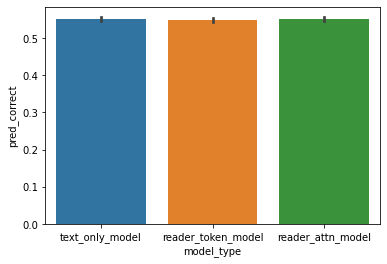

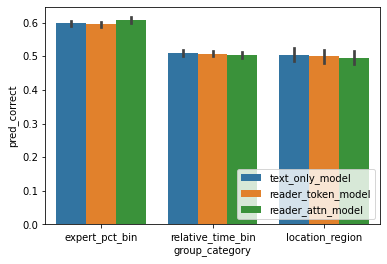

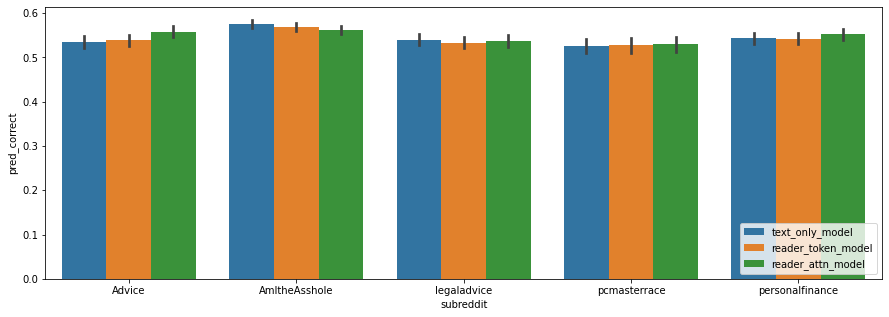

,subreddit,group_category,text_only_model,reader_token_model,reader_attn_model
0,Advice,expert_pct_bin,0.488405,0.492099,0.515828
1,Advice,location_region,0.462738,0.481686,0.481686
2,Advice,relative_time_bin,0.469729,0.476979,0.485039
3,AmItheAsshole,expert_pct_bin,0.517986,0.519886,0.514544
4,AmItheAsshole,location_region,0.519913,0.510799,0.483898
5,AmItheAsshole,relative_time_bin,0.529822,0.516428,0.514457
6,legaladvice,expert_pct_bin,0.490317,0.482328,0.511353
7,legaladvice,location_region,0.469812,0.460711,0.434783
8,legaladvice,relative_time_bin,0.508417,0.499726,0.490546
9,pcmasterrace,expert_pct_bin,0.487782,0.496634,0.496108


,subreddit,text_only_model,reader_token_model,reader_attn_model
0,Advice,0.473624,0.483588,0.494184
1,AmItheAsshole,0.522574,0.515704,0.504300
2,legaladvice,0.489516,0.480921,0.478894
3,pcmasterrace,0.480633,0.472889,0.495373
4,personalfinance,0.476100,0.477518,0.489219


,group_category,text_only_model,reader_token_model,reader_attn_model
0,expert_pct_bin,0.494283,0.493564,0.509493
1,location_region,0.474616,0.468793,0.474882
2,relative_time_bin,0.496568,0.496016,0.492808


In [72]:
## plot
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# accuracy combined
sns.barplot(data=flat_test_data, x='model_type', y='pred_correct')
plt.show()
# accuracy per-group
sns.barplot(data=flat_test_data, x='group_category', y='pred_correct', hue='model_type')
plt.legend(loc='lower right')
plt.show()
# accuracy per-subreddit
subreddit_ordered = list(sorted(flat_test_data.loc[:, 'subreddit'].unique()))
plt.figure(figsize=(len(subreddit_ordered) * 3, 5))
sns.barplot(data=flat_test_data, x='subreddit', y='pred_correct', hue='model_type', order=subreddit_ordered)
plt.legend(loc='lower right')
plt.show()
## compute numbers per-subreddit, per-group
from sklearn.metrics import f1_score
model_output_pred_scores = []
for (subreddit_i, group_i, model_i), data_i in flat_test_data.groupby(['subreddit', 'group_category', 'model_type']):
    if(type(data_i.loc[:, 'pred_class'].iloc[0]) is int):
        data_i = data_i.assign(**{
            'pred_class' : data_i.loc[:, 'pred_class'].astype(int),
            'reader_group_class' : data_i.loc[:, 'reader_group_class'].astype(int),
        })
    f1_i = f1_score(data_i.loc[:, 'reader_group_class'], data_i.loc[:, 'pred_class'].values, average='macro')
    model_output_pred_scores.append([subreddit_i, group_i, model_i, f1_i])
model_output_pred_scores = pd.DataFrame(model_output_pred_scores, columns=['subreddit', 'group_category', 'model', 'F1'])
# reshape to make it easier to compare
model_output_pred_scores = pd.pivot(model_output_pred_scores, index=['subreddit', 'group_category'], columns=['model'], values=['F1']).reset_index()
model_output_pred_scores.columns = list(map(lambda x: x[0] if x[1]=='' else x[1], model_output_pred_scores.columns))
# fix column order
model_output_pred_scores = model_output_pred_scores.loc[:, ['subreddit', 'group_category', 'text_only_model', 'reader_token_model', 'reader_attn_model']]
display(model_output_pred_scores)
display(model_output_pred_scores.groupby('subreddit').apply(lambda x: x.loc[:, model_output_types].mean(axis=0)).reset_index())
display(model_output_pred_scores.groupby('group_category').apply(lambda x: x.loc[:, model_output_types].mean(axis=0)).reset_index())

- `reader_group`
    - `expert_pct_bin`: `reader_attn` > `text_only` ~ `reader_token`
    - `relative_time_bin`: `text_only` > `reader_token` > `reader_attn`
- `subreddit`
    - `Advice`: `reader_attn` > `reader_token` > `text_only`
    - `AmItheAsshole`: `text_only` > `reader_token` > `reader_attn`
    - `personalfinance`: `reader_attn` > `reader_token` ~ `text_only`

What is the distribution of probability for the correct predictions?

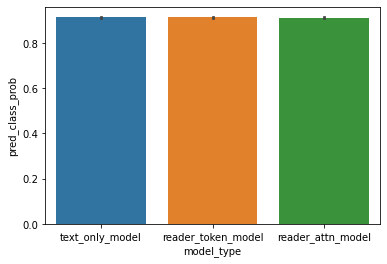

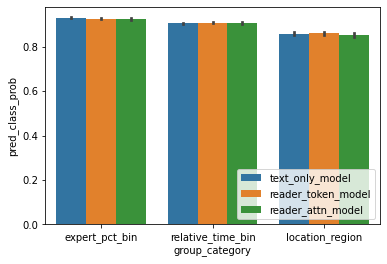

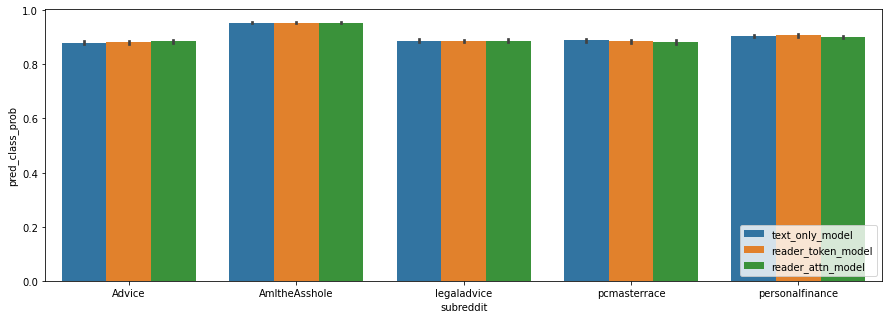

In [44]:
correct_pred_flat_test_data = flat_test_data[flat_test_data.loc[:, 'pred_correct']]
## probability overall
sns.barplot(data=correct_pred_flat_test_data, x='model_type', y='pred_class_prob')
plt.show()
# probability per-group
sns.barplot(data=correct_pred_flat_test_data, x='group_category', y='pred_class_prob', hue='model_type')
plt.legend(loc='lower right')
plt.show()
# probability per-subreddit
subreddit_ordered = list(sorted(correct_pred_flat_test_data.loc[:, 'subreddit'].unique()))
plt.figure(figsize=(len(subreddit_ordered) * 3, 5))
sns.barplot(data=correct_pred_flat_test_data, x='subreddit', y='pred_class_prob', hue='model_type', order=subreddit_ordered)
plt.legend(loc='lower right')
plt.show()

- `group_category`
    - `expert_pct_bin`: `text_only` > `reader_token` ~ `reader_attn`
    - `location_region`: `reader_token` > `text_model` > `reader_attn`
- `subreddit`
    - `Advice`: `reader_attn` > `reader_token` > `text_only`
    - `pcmasterrace`: `text_only` > `reader_token` > `reader_attn`
    - `personalfinance`: `reader_token` > `text_only` > `reader_attn`

What about the incorrect predictions?

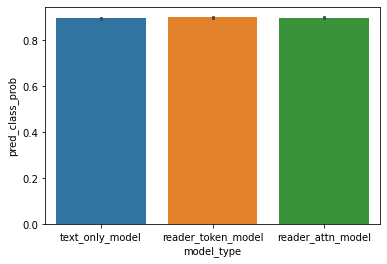

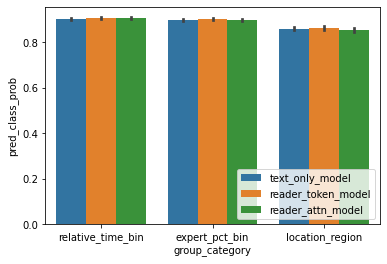

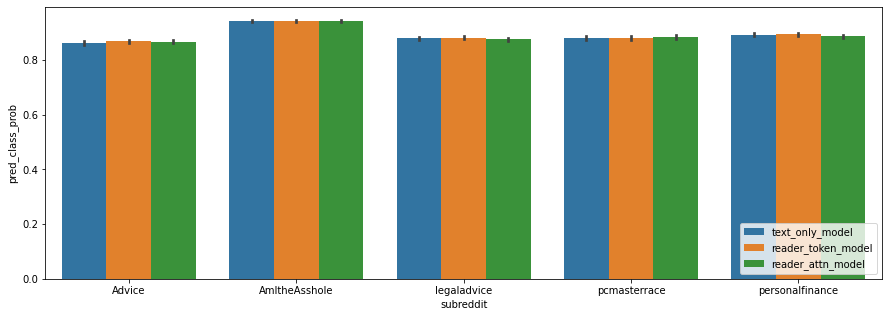

In [45]:
incorrect_pred_flat_test_data = flat_test_data[~flat_test_data.loc[:, 'pred_correct']]
## probability overall
sns.barplot(data=incorrect_pred_flat_test_data, x='model_type', y='pred_class_prob')
plt.show()
# probability per-group
sns.barplot(data=incorrect_pred_flat_test_data, x='group_category', y='pred_class_prob', hue='model_type')
plt.legend(loc='lower right')
plt.show()
# probability per-subreddit
subreddit_ordered = list(sorted(incorrect_pred_flat_test_data.loc[:, 'subreddit'].unique()))
plt.figure(figsize=(len(subreddit_ordered) * 3, 5))
sns.barplot(data=incorrect_pred_flat_test_data, x='subreddit', y='pred_class_prob', hue='model_type', order=subreddit_ordered)
plt.legend(loc='lower right')
plt.show()

Nothing remarkable here.

### Investigate annotation data
We have generated test questions for a subset of the high-difference questions [here](get_sample_questions_for_annotation_qualtrics.py), now let's see if the reader groups' differences are reproduced in the generated questions.

In [1]:
import os
import pandas as pd
data_dir = '../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output_round_2/'
combined_data = []
for f in os.listdir(data_dir):
    if(f.endswith('.tsv')):
        d = pd.read_csv(os.path.join(data_dir, f), sep='\t')
        combined_data.append(d)
combined_data = pd.concat(combined_data, axis=0)
print(combined_data.loc[:, ['Q2.1.type', 'Q2.2.type']].value_counts().sort_index())
print(combined_data.loc[:, ['subreddit', 'group_category']].value_counts().sort_index())

Q2.1.type                 Q2.2.type               
<EXPERT_PCT_0_AUTHOR>     <EXPERT_PCT_1_AUTHOR>       20
<EXPERT_PCT_1_AUTHOR>     <EXPERT_PCT_0_AUTHOR>       30
<NONUS_AUTHOR>            <US_AUTHOR>                 24
<RESPONSE_TIME_0_AUTHOR>  <RESPONSE_TIME_1_AUTHOR>    20
<RESPONSE_TIME_1_AUTHOR>  <RESPONSE_TIME_0_AUTHOR>    30
<US_AUTHOR>               <NONUS_AUTHOR>              19
dtype: int64
subreddit        group_category
Advice           expert            10
                 location           7
                 time              10
AmItheAsshole    expert            10
                 location          10
                 time              10
legaladvice      expert            10
                 location          10
                 time              10
pcmasterrace     expert            10
                 location           6
                 time              10
personalfinance  expert            10
                 location          10
                 time         

In [3]:
## raw data
pd.set_option('display.max_colwidth', 1500)
for (s_i, g_i), data_i in combined_data.groupby(['subreddit', 'group_category']):
    print(f'subreddit={s_i}; group={g_i}')
    display(data_i.loc[:, ['post_text', 'Q2.1', 'Q2.2']].head())

subreddit=Advice; group=expert


,post_text,Q2.1,Q2.2
0,"I have become a very emotional person. I take things overly personal and have a hard time letting go. My mind often feels clouded by negativity; it’s getting more difficult to control each day. I bet this all stems from my anxiety, or maybe I’m bipolar?... but I’m not sure what to do anymore. How do you let go of the built up anger you feel? And if you say, “by being more forgiving”, then elaborate on that too please.",What do you hope to gain by doing that?,What do you think is the best way to get back at them?
1,"So I have a job where I have to monitor an activity, and to do so I have to spend around 5-8 days constantly around strange men (I am female) including sleeping in the same room as them. On the third day of one of these sessions I woke up to one of the guys very aggressively beating his meat about 3 feet away from me, not at all subtle, but he wasn't looking at me or anything (and I don't think he realized I woke up). He never made any inappropriate comments to me before or after that (though another guy on the site did). What I'm trying to figure out is if this is beyond the pale, or just a thing thats inevitably going to happen. I don't know if I should report it, or if I'll look like a baby if I do. &amp;#x200B;Guys, is this just a thing that happens and isn't related to me personally?Girls, how would you feel if this happened to you? Would you report it?",Do you have a gym membership?,Is there any way you can appeal the decision?
2,"Like the title says I can't eat in front of anyone and it's becoming somewhat of an issue. I just moved back in with my parents to save money and they're awesome but when it comes to mental health they have a ""get over it"" attitude. Anxiety KILLS me when the idea of eating in front of anyone pops into my head so I tend to only eat cold left overs in the fridge at about 11 pm once everyone is asleep. I do not know if this is an eating disorder or a symptom of a larger problem but I feel like I am going crazy! Please any advice I can get would be RAD!",Do you have a job?,Do you have a car?
3,"I am a 17 year old high school graduate in the United states. Lately I've been wanting to go to college and move out, although I am not in any rush to move out.Ever since I got my 1st job at 16, I've been paying my share of Bills and rent (33% of rent) at the beginning I also wasnt smart with my money, maybe the 1st 3 months if working. Now I have a decent paying jobs. But the more money I make, my dad makes me pay more and more bills. It's gotten to the point where I'm making about close to nothing toward being able to move out and go out in my own life. I want to go to college and pursue architecture but have no way of being able to get to school, as public transport isnt reliable in my area. Do not have a car if my own and have a family preventing me financially, from going forward. I barely afford food to pay my bills at the same time and do not wish to get into any legal troubles.How can I confront the situation to my parents, I've tried talking to my father and he always says I'm having to figure it out on my own, and due to my age, I am limited to very little, low paying jobs and as of now, using my free time to practice BIM design so that I may get a better job once I am 18.",Do you have a school counselor at school?,Do you have a car?
4,"My car battery was dead this morning and I had to call triple A. It looks them about a hour and a half to get to me. I informed my boss the second I knew my battery was dead. He said it was fine and thanked me for letting him know. When I got into the office, he said he needed proof that was battery was dead. Is this something I have to provide him?","Did you take it to him, or did you assume it was his fault?",Did you take it on a roadtrip?


subreddit=Advice; group=location


,post_text,Q2.1,Q2.2
0,"My girlfriend went to a friend's house where there was a small gathering of males and females. At the end of the night, she was very drunk and so was the guy and apparently they kissed once for about a second.She and him were the only people in the room, my girlfriend knows this guy has a thing for her and she was very drunk as she hadn't drank for over a year. She claims he came onto her quick and straight away she pushed him away and was apparently sick. I'm very sceptical because I've heard being drunk doesn't make you do things you usually wouldn't, so why would she put herself into this situation? Even if the kiss was forced, she still willingly stayed in a room, Alone, with this boy who does like her.She woke up very early the next morning and called me to explain. She says the kiss was about a second long, which I still believe is quite long without someone reacting.",How did she react when you told her how she felt?,How old is she?
1,I'm getting married this year. We have a few lifelong friends (20+ years) who have given some lame excuses for not attending the stag/hen and wedding.As an example one promised their own partner that they wouldn't go abroad (??) whilst another is busy that weekend despite having 6 months notice (??).I always feel people will find time and money for things they really want to do and choose not too either through disinterest or by having other higher priorities.For a life event such as a wedding I think it's unreasonable for lifelong friends to simply blow it off without explaining themselves as it does nothing but question the entire friendship.What's a good approach to get genuine answers from people or put on some pressure without coming across as confrontational or unsympathetic?,Did you miss the news?,INFO: did you know you were going to the wedding after the wedding?
2,"Hi, I'm having a tough time choosing my career path for college. I'm in my senior year at high school and only have two options for college, attend the local community college or attend UCSC (University of California Santa Cruz.) The biggest thing that's concerning me in attending UCSC is that it has a reputation for being very liberal and kinda having a hippy vibe, and while I'm not super political, in my experience I tend to clash with those types, of course I haven't actually experienced the world a whole lot, but I worry it might be tough to fit in. The biggest reason I want to attend UCSC is because I'm fairly introverted and I feel like the 4 year university experience away from home on my own (~ 6 hour drive) might help me become more socially adept via trial by fire. If I choose to go to community college and were to do well in my first two years, then I would presumably have a wider selection for universities.So what do you guys think? Are my fears of UCSC crowd unwarranted, what should I do? Thanks. Also posting on mobile, please forgive formatting errors.Tl;drAttend 4 year university to be more social, or go to community college to get better school selection",Have you applied to any jobs since you started school?,Do you have a job?
3,"This is not really a question as you can tell but I really need to talk about this so Im starting a thread; I'm 17 and Ive never kissed anyone, held anyones hand, hell Ive barely flirted with someone (via text). I know that Im still young but all my friends have experienced at leat one of these things whilist I am stuck with my tired imagination. I really wish I could experience any kind of teenage fling or anything before Im not even a teenager anymore, and its not because of social acceptance, I used to think it is, but its more than that, Im honestly longing for physical interaction or just feeling like someome cares about me in more than a friendly/family way but I seem to be invisible to everyone around me. A month ago I gathered the courage to confront my crush who apparently ""wasnt looking for a relationship"". So Im either really horrible lookin

subreddit=Advice; group=time


,post_text,Q2.1,Q2.2
0,"My mum passed away 3 days ago so now we are starting to make arrangements for the funeral. I was close to my Mum, and the thought of giving a eulogy in front of everybody is just too much for me to think about. I honestly don’t think I’ll be able to do it on the day. I know it’s my decision, and I should be allowed to grieve however I wish. However a couple of people have said that I should speak and it’s what she would’ve wanted. I’m feeling pressured and guilt-tripped into doing it. My sister and uncle have words they wish to say on the day, so it’s not like there’ll be no one giving a eulogy. And on the day of her death, i said all the words I wished to say to her then, just me and her. I feel like I’ve said my piece and I want to leave it at that. Is it wrong of me to not speak at her funeral?",How will you feel then?,Are you ready to throw her away over this?
1,"We've been dating for two months. A week ago, I learned she had a plan and I called 911. The police arrived in the middle of her attempt and she was taken in an ambulance to the hospital. She recovered quickly there and now wishes to make further progress on her mental health as she continues treatment.I realized during this time that I love her and it definitely brought us closer. But as elated as I am that she's safe and striving to get better, I am still struggling with the intensity of this experience. I have spoken with my therapist about it already, who assured me that I did the right thing and brought me some clarity. But I still have so much confusion, anger, and fear.I would like to confide in my parents, with whom I have a very close relationship, and my best friend who has always been there for me through everything for over twenty years. But, as the title says, they haven't met her yet. I want to be respectful of her privacy, and I don't want them to judge my girlfriend before I can introduce her to them. I believe she is worried about this also.Should I keep my mouth shut and rely only on my therapist for support? Or is it reasonable for me to share this with my family and my best friend?",Have you told her how you feel?,How old are you?
2,"I’m in a serious relationship with my boyfriend of 6 months, I love him with all my heart. I have an old friend who recently was diagnosed with cancer, I hadn’t seen him since before his diagnosis but keep in touch by messaging.My friend asked me to hang out as we haven’t seen eachother in a long time and he’s feeling really down lately about his situation. Although it’s completely platonic and I have no attraction to this friend whatsoever, because he’s a guy I asked my bf for permission and told him I would be hanging out at my friends house. Of course he said yes, he’s been encouraging me to visit this friend since the diagnosis.So I go to his house and we talk about our lives over the last year, just catching up on all the things we’ve missed in each others lives. We put on the tv and he seems a little emotional at the show. I put my head on his chest and tell him it will all be okay. We lie like this, him telling me about the darker parts of his life and me comforting him. We end up falling asleep this way.It’s the next day now and I’m just curious as to whether I did anything wrong? I don’t have any attraction to this friend and just wanted to comfort him in a very dark time. And just for the record I had no intention of falling asleep with him.Did I do anything wrong?",How old are you guys?,How old are you?
3,"I am 72, a woman living alone after being deserted by my husband of 50 years marriage. I have disabilities that make it impossible for me to lift anything heavy, to walk more than a block, to kneel and get up, and difficulty concentrating. I have never had to do these things alone before. I can't have a house mate. I have almost no money. Every day there is a new problem such as: how to operate the new TV; malfunctions of the dishwasher or washing machine; malfunctions of the ca

subreddit=AmItheAsshole; group=expert


,post_text,Q2.1,Q2.2
0,"so a few weeks ago my daughter (17f) found those tumblr genders, I apologize for any fuck ups I'm currently learning about this. she came out as demigender aceflux? I believe. I asked what that was and after some explanation I knew that it was fake and a fad. I told her I would not accept her and would not use her new pronouns (xe xm) I have no clue how you even use them. she then locked herself in her room for 5 hours crying. this was last week and she is now not talking to me unless I use her xe xm pronouns.I found a camp for kids with mental health problems and thought I would sign her up. my parents are against it and my ex husband agrees with them. WIBTA if I took her?it's a no phone camp so it might be good for her. i have provided the best life I could for her and I'm kinda confused by all of this. if you want to be just as confused as me just look up mogai on tumblr.",What do you think will happen when she finds out?,Why do you even have to ask?
1,"Long story short, my mil is toxic and judgmental. My husband (we are both 20 M/F) is currently stationed within driving distance of his hometown, so we see mil a lot. Last month, I dyed my hair seafoam green, and she told me it looked like shit. I left my dirtbike at her place a few months ago, and she sold it on FB marketplace and pocketed the money. She has used my juul without permission, which was pretty gross, especially since I’m a germaphobe. Finally, she always comment on my body, and she always grabs a handful of my belly when I see her and says something like “you should stay sexy for my son.” I was a bit thinner when we married, but I have a thyroid disorder, and my weight tends to yo-yo.Anyway, here’s what I did. Last month, I made a FB group called “Exposing (my mil’s name)”. I invited a shit ton of people from our extended family, and I also put a few of her co workers and church friends. I posted all the nasty things she’s said/ done. Whenever she does a new awful thing, I post it to the group. She’s pissed, and she wants me to take it down, but I won’t do it until she stops being toxic to me. She’s losing face with her church friends, and our family is pretty divided on the whole thing. AITA?",How would you feel if someone did this to you?,"YTA, you know how many times I have had to have a child and not a child?"
2,SIL called to ask why only one of the nephews (the 15 year old) got a christmas present. I told her the older one was 18 and that's the cutoff. She got upset (and definitely thinks ITA). These are my only 2 nephews if that context helps at all. It's almost that time of year again and I'm not sure what to do this year.,What the fuck is wrong with you?,Did he even ask what he was or how would you feel about it?
3,"I noticed my girlfriend was watching something over and over on her tablet. I went over and saw that she was watching a scene where a teenage character from one of the shows she watches dies. The character collapses into her boyfriend’s arms, there’s blood everywhere, all of her friends and family look on in horror. I told her it was fucked up watching a horrible scene like that over and over, asked why she would ever do that. She says that’s her favorite character from the show and she likes seeing how concerned everyone is for her and how much they like her. I asked why she’d want to see her favorite character die so many times and said it seemed really psycho. She got a little teary and just said it’s not about the blood or anything, but I don’t see why she would want to watch a scene like that repeatedly if she doesn’t enjoy blood and death. AITA?",What are you afraid of?,"YTA, wtf are you talking about?"
4,"So, my boyfriend says that mental hospitals, therapists, and depression medications are all shit, and he says it's a fact that they don't help anyone. Because I completely disagree and know that these things helped me, I get mad and start saying a bunch of angry sarcastic stuff in response, essentially mockin

subreddit=AmItheAsshole; group=location


,post_text,Q2.1,Q2.2
0,"My roommate and I are going to a party tomorrow, and it is my turn to be the designated driver. I haven’t been out in a while and I would like to drink too, so I said that I would get us (pay for) an uber to and from the party so I was still responsible for the ride, but I could drink too. When I told my roommate this they were livid. They think that if it’s my turn to drive than I have to drive, and getting us a different ride doesn’t count. I think as long as I get us a safe ride, I’m doing what I need to do. AITA?",INFO - how long were you gone?,INFO: how long have you been roommates?
1,We were driving back from a music concert and one of her guy friends needed a ride back home. It's a 10 hour drive back so we made reservations before the trip at a nice hotel in downtown Chicago to enjoy the evening and ourselves. I was very irritated when she offered to give him a ride back because this was going to be our night. I told him he needed to get his own room because we reserved a room with one bed. Well we get there and he says he has no money or job and my gf says he can sleep in the king with us. I said no he can sleep his ass on the bathroom floor. She got really upset and he ended up getting his brother who lives in chicago to pick him up. He called me a ass. Aita?,Does he have a history of smoking up with other people?,INFO: Is he a child?
2,"Without giving too much detail (all numbers here are fudged a little), it is customary for the industry im in for employer s to ask how much you made at your previous position. They can never verify it though unless they see your checks because of the nature of the industry and the bonus structure/capital gains/ etc. &amp;#x200B;I currently make $175k at company A and want to make at least $225k at company B. company B asked me how much i make and i said $200k + 20k bonus and im looking for $225k company B asked me to provide proof (this is unheard of, so is company B asking company A becuaee company A would never give that info). &amp;#x200B;I gave them my bonus which was actually $20k but then they asked for a paystub of my biweekly . i then used photoshop to put in the amount corresponding to $200k/yr on my $175k and company B came back with $210k base and bonus on similar scale as company A.&amp;#x200B;AITA??",Do you think you will need to support yourself in the next few years?,Do you plan on going back to the company after you hit the program?
3,"This just happened today:I was riding my bike across the driveway for a local grocery store. There was one person there going in, but I assumed she saw me. I continued crossing, when she pulls forward and hits me on my bike. She gives me a death stare, and I get back up. There was a dent in my bike, but that was it. Nothing happened to her car, either, but she still insisted on taking my insurance info. Am I the asshole for cutting her off?",INFO: Did you ask her to stop driving?,What were you supposed to do?
4,"My roommate and I are going to a party tomorrow, and it is my turn to be the designated driver. I haven’t been out in a while and I would like to drink too, so I said that I would get us (pay for) an uber to and from the party so I was still responsible for the ride, but I could drink too. When I told my roommate this they were livid. They think that if it’s my turn to drive than I have to drive, and getting us a different ride doesn’t count. I think as long as I get us a safe ride, I’m doing what I need to do. AITA?",INFO: Did you tell them you were leaving in for the first place?,INFO: What time of day did you get out of the apartment?


subreddit=AmItheAsshole; group=time


,post_text,Q2.1,Q2.2
0,"We live with our mom, and when she isn’t around, I’m in charge of my brother. I’m 17 and he’s 15, and he’s a total brat. My mom isn’t nearly hard enough on him which is why he’s the way he is. But I don’t let him get away with anything when I’m in charge.Last night both of us sat down to eat dinner. Maybe five minutes after we started eating, my brother just farts right there at the dinner table. He knows by now that when I’m in charge the rule about farting is he needs to go to the bathroom and sit on the toilet to fart, and then flush it down.But no, he decided he could just fart all over our dinner that I had just spent over an hour making. After he did that, I told him how disgusting he was and I grabbed his plate and dumped the rest of his food in the trash and told him to go to bed. He tried lying to me, saying he was sorry and that it was an accident, but I know that it was definitely on purpose and he did it to be rude.He’s been acting upset ever since and he told me what I did was mean, and that I’m too strict on him but I don’t think that I am. AITA?",How old are you?,"NTA, is there some reason you can’t take him to the shower?"
1,"unsure how to word the title. so I'm the principal at a high school and we have run into a issue between the Muslim community. last year during the big exams 4 Muslim girls got caught with wireless headphones, they had them so they could have the answers on repeat. they hid them in their headscarves. this year I told people that wore headscarves that you would have to pull the sides back to show nothing is in your ears, some of the girls went home and complained and now I have parents who are calling me rude and how its incredibly insensitive.they did not have to take the headscarf off just show their ears. was I wrong in this or not.","NTA, are you male or female?",Are you sure they're gay?
2,"Long story short, my brother and I grew up hard. Not that our family didn’t have money, my dad is a CEO and my mom is a SAHM. But even then we never got all the things we wanted, plus our Dad never gave us the attention we were looking for. This led to a strong bond between us. I’m 26 and he just turned 20 and is about to start college after taking a gap year to experience Europe. I went to college and have been blessed to get an amazing job. I’m a VP at the same company as my Dad, although my Dad didn’t get me the job I had to do it in my own. My mom said for Christmas I should pay my bros tuition as a gift, which I can easily afford but I feel college wasn’t really needed for me so I encouraged my bro to skip it and apply for an open senior manager position at the company. That way he can start earning big time like I do. AITA for trying to help him get a head start on his career?",INFO: Do you have any plans for the wedding?,INFO: Do you have a job where you can take a few more hours?
3,"My gf is really obsessed with anything she can pop or pick at. Her own skin is clear and amazing but for some reason I have dry ass legs and a lot of ingrowns there but also on my beard and neck. Occasionally I get a pimple and EVERYTIME I do she makes grabby hands at it. I don’t really mind them, they’re a little irritating but whatever. She is ALWAYS trying to pick at my face or arms or legs and it’s really starting to piss me off. It hurts, I don’t want my skin touched, and it’s just gross. I’ve told her so many times and she doesn’t seem to care, plus she LOVES doing it so normally I just shut up and accept it.I’ve had a bad toothache lately and so I keep telling her to leave my beard alone. Sadly that’s her favorite part and last night she ended up grabbing me because she saw in her words ‘a really juicy pimple’ I was really mad because she hurt me but I just sat there til she was done because I didn’t wanna throw her off me and then I told her she was an asshole for continuously disrespecting my wishes. She got so mad she ended up sleeping on the couch. This morning I was expecting a

subreddit=legaladvice; group=expert


,post_text,Q2.1,Q2.2
0,"About two years ago my husband and I lent my sister in law roughly 2500. She swore up and down when she got her disability money she’d pay us back. We had no contract so assumed we’d never get it. Fast forward to last year, she DID get her money so we asked for it back and she said several times that she was paying us back bc we had helped her. She even lent us an extra 1500 which we paid back promptly at tax time this year.She became verbally abusive via text message and nonstop harassing so we ended communication. She was threatening to call CPS to have our kids taken away etc and it was just so excessive so we never replied. Fast forward to November, we get a summons to court bc she’s suing us for 3500.Does she have a case? We had no contract with her but we assumed she did the right thing when she paid us back. She did lend us 1500 but we paid her back and have receipts. She sent all money through PayPal. I have all the receipts from that as well, some of which say ‘GIFT’ in the comment box. We also have several harassing and threatening text messages. This is small claims court so no lawyers. I’ve never been in this situation before and I’m super stressed about it.",Did she pay her medical card?,Did she not pay in cash?
1,"Do I have the right to sue someone if I'm infected by someone who won't go home when they're sick? I literally sit 5' from this guy and he's hacking up chunks of his lungs. I don't want to get sick, dammit!","Do you have a yard, front or back?",What do you mean you don't have a dash cam?
2,"Need help getting money back from a vacation scheme. My elderly parents signed a contract (""First Choice Travel"" in Aruba) for a large sum after hearing a presentation for a ""Reservation Services License Agreement"" promising 1.huge discounts on travel and 2.elimination of their 7 timeshare-week contracts.They put the entire amount on their credit card. When I found out about this (the next day), I immediately had them begin the cancellation process (including registered and certified mail, both from the US and from Aruba to the travel company). I showed them the reports online of others being scammed and then, as a test, we tried their service and, sure enough, they were not able to get ANY discounts above that which we could get on our own. We were within 3 days, but I'm not sure what laws will govern this transaction. It is important to note that the Contract my parents signed included a clause that said that they could NOT cancel.I think somewhere I read that clauses containing this language are illegal in that they violate other local law, but I'm still searching for evidence of this. We've had the credit card (Citibank) do a chargeback on the basis of our displeasure with the services rendered and they are investigating now. FRAUD IN THE INDUCEMENT, FAILURE TO PERFORM, etc",Are you an employee or a contractor?,Do you have a USAAAA or Ditech ID?
3,So my elderly mother got scammed out of $35000 on an online dating site. The scammer got her personal info and took out a few credit cards and maxed them all out. If something were to happen to my mom would I be on the hook for this? Thanks in advance.,Did your dad write a check at all?,How old are you?
4,"I am a green card holder (since mid-2013), currently based in India. As of today, in the past 5 years, I have spent the 784 days (26 months) in the United States. For the past 5 years I have had an active bank account, credit card account, have been owning property and collecting rent from it in Virginia, have filed taxes every year. I have a few questions, I was hoping you could help answer. 1. Do I need to spend another 4 months in the US before I can apply for citizenship? 2. Where do you suggest I apply from? (My sister, a US citizen, lives in NYC, my property is in Virginia, and I have spent most of my time in Atlanta &amp; Houston)3. I would like to get citizenship as soon as possible. What is the quickest route for me at this point?4

subreddit=legaladvice; group=location


,post_text,Q2.1,Q2.2
0,"My girlfriend recently bought a jacket from a large department store in CA for a trip to Chicago. After flying to Chicago, she greeted an old friend with a hug. The old friend felt something strange in GF’s jacket when they embraced. They then took the jacket off to figure out what it was. Come to find out whatever it was was stuck between the lining of the jacket and outer layer (sewed in). They then cut open the lining and pulled out extremely sharp metal sheers. They have this all on video and hung on to the sheers. My question is do we have any legal grounds to sue? What would “suing” entail? I’ve never really dealt with lawyers and don’t know much about the law here but this could’ve seriously injured or killed someone. These things are super sharp. She also somehow made it through TSA with these super sharp sheers so we’re really just trying to teach a lesson to this company. Thanks for reading. Normally I wouldn’t try to harm a small business or anything but because this is a huge department store I don’t really care.",Have you tried calling the department department of law enforcement?,What do you mean by this?
1,"I have been using this company as my cloud storage solution since 2011. I was able to secure about 50 GBs of free storage in the early days of the service by referring to my friends and colleagues.A few days ago, I suddenly realize that I am unable to login to my account. After contacting support, I was told that my account has been irrevocably deleted together with all my data. Reason? Apparently, I was automatically switched to a different (paid) plan some months ago. Since I was now subscribed to a paid plan, but did not pay for using it, my account has been deleted a few months later. However, I was never notified a) that my plan has changed, b) that I am supposed to pay something. Support says that e-mail notices have been sent asking me to pay. I never got any. I am registered with a Gmail account and I check my spam folder every single day. Double checked my inbox too. Nope, not a single notice.This is a complete tragedy for me. A lifetime of my work is gone in an instant. I simply can not understand that the company did not bother communicating this with me. Like, ""we know you have a ton of data and we would like to let you know that we are about to delete it"". Is legal action against the company an option at this moment? They are a US-based company. I am not a US citizen.Thank you.",Do you have a copy of their cancellation policy?,Do you have a written contract with them?
2,"I am currently a university student and part of my program involves doing a project with *very* specific formatting and submission rules. I am creating a program to automate this formatting and take the guess work out of complying with the rules. Ideally, I would like to license this software back to my university or sell it to future students, but at the bare minimum I’d like to retain full control of my IP. What steps can I take to prevent my university from swooping in and saying they own my project? They’re already doing a lot of shady stuff and I absolutely would not put it past them to try and force me to give them my work for free. Aside from the obvious stuff, like I can’t use their computers or WiFi to work on my side project, and I also probably should not physically be on university property. I’m in Rhode Island, if that helps. Thanks so much for the advice!",Are you a member of a union?,Are you an employee or a contractor?
3,"My girlfriends crazy ex-boyfriend (presumably) slashed 8 of my parents tires and poured sugar in their gas tanks causing about $10,000 in damage. He also slashed the tires on a few other cars in my neighborhood to make it look like my family wasn’t targeted, but no other house got sugar in the gas tanks. He has a history of this, he once threw a rock through my girlfriends back window. He also has a few prior run ins with police. My family wants to press charges and is g

subreddit=legaladvice; group=time


,post_text,Q2.1,Q2.2
0,"My lawyer sent me an invoice for $0 as all my fees were covered already, but then added the price of a postage stamp to the invoice. They are now saying I need to pay $0.47 for the privilege to be told I owe them nothing. Is this something I actually need to pay? I know it's very little money but the principle of it seems wrong to me.",Did you call them and ask?,Did you check your credit report to see if anything can be done?
1,"My wife's ex-husband assaulted and battered me a little over a year ago. A ""no contact"" protective order was placed until we went before a judge. In court, I asked the order to be changed to a ""no *hostile* contact"" order, but the judge refused and it now remains a ""no contact"" order. For the last year, the ex-husband has ostensibly used the protective order to prevent me from attending school/extracurriculars (as I let him have first dibs in attending). I know the ex-husband wouldn't agree with my attempts to dissolve the order ""cold turkey""-- he would ask the judge to let it remain. With that in mind, I was wondering if having my wife send the ex a message indicating my desire to attend an event, how I wouldn't interact with him, etc, would be a good move? Obviously if he declined/refused, I would not attend and leave it at at that.I can see positives/negatives of this maneuver, but would love to know if I'd be exposing myself to possible legal actions by doing so. I honestly just want the three of us to be able to effectively co-parent as quickly as possible, and would love to speed up our return to ""normal"" interactions without having to wait another year if at all possible. Thanks in advance for any input!",Have you contacted social services at any point?,What state are you in?
2,"I'm posting for a friend, she was discriminated against during the interview process for being deaf. The hiring manager literally told her she didn't get hired due to her disability. She has since filed a lawsuit on her own, and the business counter her with the job offer that she was denied for. She has since taken a job somewhere else in the same field but in a different town.&amp;#x200B;WITHOUT advising her to get a lawyer, i'm wondering what she should counter sue for. I've seen similar cases be awarded upward of a million dollars. Or if someone can point me to a similar case, i've done some googling but haven't turned up much.&amp;#x200B;Edit: In minnesota",What was she served with?,Did she request a mailed check in writing?
3,"First off, sorry for the format since I'm on mobile. Backstory: I turned 18 recently (not even a year ago) and I start college this fall. Our family car needed a lot of work done so my parents decided to take out a loan and just purchase a new car. Here's the issue: When they took out the loan I was not with them. I actually didn't know they were taking out a loan until AFTER they bought the car. The loan isn't the problem, it's how my name was put as a cosigner even though I didn't agree to anything nor did I even sign any document. So now if something happened to my parents apparently I will ""inherit"" their loan/debt. Just because I'm their child (now legal adult) am I forced to be a cosigner even though I never agreed to anything? Can my signature be put on any documents they sign without my permission? I took out the contracts and looked at them myself and I am indeed a cosigner. Any advice is very helpful since I am new to any of this.Thanks!",Do you have the title in your name?,Have you talked to your parents about this?
4,I'm from Arkansas. The pictures of me were taken in Texas. This website has also recently published a book based on these images but I'm unsure if I'm in that book. I haven't found a copy of it yet.,What do you think you're going to do?,Do you have a union rep?


subreddit=pcmasterrace; group=expert


,post_text,Q2.1,Q2.2
0,"Even though I have a amazing gaming PC and laptop, I still buy console games because my internet download speed is only 66kbps :( and there is no way to get high speed internet even though I'm paying the same price...There literally no way for me to download games. I have a 3440 X 1440p 100 Hertz monitor with a GTX 1070 and the new Intel core i7 9th gen CPU. And my PC doesn't have a CD/DVD drive either. To give you an idea of how slow my internet is. It took me 7 hours to download Google Chrome browser.",What do you like to do?,What games do you want to play?
1,"I'm wanting to upgrade my i5-6500 and motherboard. I use it to game but more importantly something lenient to VR, as i'm finding my CPU to not be giving its best for VR games. My GPU is a GTX 1080 and DDR4 3200mhz 16gb ram, so they are just fine.",What is your RAM setup exactly?,Do you have a good dual channel RAM configuration?
2,"Having a discussion with my friend about Stadia. He's so excited about it and claims it'll kill PC Gaming. We've been discussing, and he's always been a console gaming so has taken the attitude of 'whats the point of a gaming PC with stadia??'What are your thoughts on this? &amp;#x200B;I don't think it'll happen...to me, I'd rather have my own hardware unreliant on connection, with little input lag and the option to hit 144hz. It's winding me up, because he doesn't get it&amp;#x200B;&amp;#x200B;","Is it just the mouse, or the case?",What do you have to lose?
3,"I love building computers and I just finished my current build so I am thinking it would be fun to build a home server for data storage for the 4 PC's in my house. 3 out of the 4 of us are constantly running out of space on our hard drives and we frequently send each other large file sizes so I am thinking it would definitely be helpful. Two photographers, two video editors and all of us are gamers. Budget would be $750 range. I already have a quadro k4000 sitting around but thats about it. If its worth the time, I would basically steal all the hard drives between us and swap them for 1tb ssds for games &amp; programs and then put those 4 hard drives in the server along with any extra ones I would add. The question is, from a software standpoint, how difficult is this to do? Is it worth the money? How powerful should the machine be? Sorry if I rambled, just thinking about all the sweet sweet server hardware I never had a reason to buy but (possibly) do now.",What do you plan to do with the PC?,What are you going to be using it for?
4,"Hey, it says on Amazon that the motherboard I bought supports DDR4 RAM up to 2666Hz but the RAM I bought is 3200Hz. Should I get another motherboard?[MSI - B360I GAMING PRO AC Mini ITX LGA1151 Motherboard](https://www.amazon.com/gp/product/B07BZ3K5PR)RAM[G.Skill - Ripjaws V Series 16GB \(2 x 8GB\) DDR4-3200 Memory](https://pcpartpicker.com/mr/newegg/Cf98TW)",What is your total budget?,Do you need more than 16GB of RAM?


subreddit=pcmasterrace; group=location


,post_text,Q2.1,Q2.2
0,"I've been planning to become a pc gamer for about a year now but since I'm not old enough to get a job and have to wait about 10 months till I'm 16, but my ideal pc was always a gtx 1060 6gb with a ryzen 3 1200, however I don't think the ryzen 3 1200 might not be the best since I made this list before Intel Coffee Lake CPUs came out, so can you suggest me anything, and it's ok if it's not exactly under 130 bucks, but somewhere near the price range.",What is your budget?,What are you going to be using the pc for?
1,"Wooooooooo \o/2 million already? Absolutely insane and awesome to see especially since it feels like it was just yesterday when we were celebrating 1 million subs. Thanks to all of you for your amazing contribution to PC and we can’t wait to see what the future brings!To celebrate we’re giving away 6 Uplay VIP Game Bundles! A VIP Game Bundle includes nearly every recent game that has been released on Uplay. You can find the full list here;https://pastebin.com/Hv1UrDKXAll you need to do to enter is leave a comment below and tell us about your favorite PC memory. We'll draw the winners on Monday, January 14th, 2019 at around 13:30 UTC.Thanks everyone and stay awesome &lt;3",What ryzen cpu are you looking at?,What games do you plan on playing?
2,"Wooooooooo \o/2 million already? Absolutely insane and awesome to see especially since it feels like it was just yesterday when we were celebrating 1 million subs. Thanks to all of you for your amazing contribution to PC and we can’t wait to see what the future brings!To celebrate we’re giving away 6 Uplay VIP Game Bundles! A VIP Game Bundle includes nearly every recent game that has been released on Uplay. You can find the full list here;https://pastebin.com/Hv1UrDKXAll you need to do to enter is leave a comment below and tell us about your favorite PC memory. We'll draw the winners on Monday, January 14th, 2019 at around 13:30 UTC.Thanks everyone and stay awesome &lt;3",What games do you plan to play on what resolution?,What games do you plan to play?
3,"Would locking the fps be more beneficial to the longevity of my laptop? Getting around 150 max, and dips to around 100. Should I just lock it to 100? I’ve got an Intel Inspiron with 6gb of ram and Intel HD5500 integrates graphics. I don’t want to burn my laptop out trying to get crazy frame rate if 100 or even 60 will do.",What is your DIMM configuration?,Do you have an SSD?
4,So I got a new pc today (first gaming PC). It gets really loud on certain games like Apex. Mainly in the menu's. Anyone have any tips or advice to get it running a bit quieter. I don't know if it's the fans or what.My setup isAMD Ryzen 5 2600xRX 580MSI B450M tomahawk2x8gb ram,"What motherboard do you have, and how is the airflow in your case?",Do you have the monitor plugged into the graphics card and not the motherboard?


subreddit=pcmasterrace; group=time


,post_text,Q2.1,Q2.2
0,I am open to any advice on what could be better.1\) [https://pcpartpicker.com/list/f3FpBb](https://pcpartpicker.com/list/f3FpBb)2\) [https://pcpartpicker.com/list/dhyZJ8](https://pcpartpicker.com/list/dhyZJ8),What is your budget?,What resolution are you playing at?
1,"I can't think of a single reason to buy a Radeon VII as a gamer when I can buy a 2080 for the same price.The VII isn't really overklockable, doesn't support any of Nvidia's features, draws more power, runs hotter, and is louderThis card seems really useless to me, it seems like a 1080ti competitor launched a few years too late",Do you have a microcenter nearby?,What are you going to be using them for?
2,"Hey people. My GPU reaches 80° and over while gaming.I have MSI ARMOR RX580 8GBWhen I bought card, first 2 months card used to run at 66° and 44° idle, thans suddenly started idle at 54° and 75-84° while gaming... whats wrong? There is no dust and I changed thermal...",Did you install the RAM in dual slot slot as well?,What is your system specs?
3,"&gt; Apple’s new iPad Pro devices also feature overhauled hardware specifications. The new devices are powered by Apple’s A12X Bionic processor, which is built on a 7nm manufacturing process. This offers a dramatic performance improvement compared to the previous generation of iPad Pros, with up to 35% faster single-core performance and 90% faster multi-core processing. **Apple added that the GPU on its new A12X Bionic chipset delivers “Xbox One S-class graphics”. The company also said that its new iPad Pros are “faster than 92% of all portable PCs sold in the past 12 months, including Core i7 models sold by mainstream laptop manufacturers”.** The devices sport up to 1TB storage capacity and now include a USB Type-C connector for improved functionality.[LINK](https://mybroadband.co.za/news/gadgets/282583-apple-launches-new-ipad-pro-faster-than-92-of-notebooks.html)Oooh boy, these guys at Cupertino really know how to lie to your face. Would love to see actual becnhmarks vs i9-8950HK, I mean this puny mobile x86 CPU only has 6 cores vs A12X Bionic's 8, right?","Did they say ""safe"" or ""safer""?",Did they list a reason for why they did it?
4,"Would locking the fps be more beneficial to the longevity of my laptop? Getting around 150 max, and dips to around 100. Should I just lock it to 100? I’ve got an Intel Inspiron with 6gb of ram and Intel HD5500 integrates graphics. I don’t want to burn my laptop out trying to get crazy frame rate if 100 or even 60 will do.",Have you checked to make sure all of your drivers are up to date?,What are the specs of your old build?


subreddit=personalfinance; group=expert


,post_text,Q2.1,Q2.2
0,"Hello all- I really need advice. My wife and I are both school teachers in Fort Worth, Texas. We're each making a salary in the mid 50s, but we have three daughters under the age of five that are in daycare that eats up roughly 30% of our take home income. After rent, tuition, monthly expenses, et cetera we struggle every month to make ends meet, to point that it spikes my anxiety hard enough to shut me down every time we try to get a handle on our finances. We constantly talk about wanting to budget to get our lives on track, but when we have the time we don't have the energy, when we have the energy we don't have the time. When we have the time and energy- which is exceedingly rare- I freeze up like a deer in the headlights try to face our situation head on. We're in a deep dark hole of barely making ends meet, and the situation isn't helped by my inlaw's judgemental attitude towards us. We desperately want to dig ourselves out of this pit of negativity and anxiety. We want to be able to buy a house for our girls, save money, not stress about money constantly, and be comfortable enough to not feel guilty, anxious, and depressed everytime we have to spend money. How do we tackle this beast? What works for you? How have you beaten this beast? Someone please help us.",Do you have kids?,What are your career plans in the next 5-10 years?
1,"I should start off by saying that 19 y/o with no other real bills to pay except for a phone bill and some subscriptions to netflix etc. I have a year and some loose change in the military and I’ve been saving up for a new car since I joined. I would like to know if my math here is wrong or if maybe instead of trying to get my dream car so early on I should just calm it down.The vehicle I have my eyes set on is at 27k rounded up. I’ve got 22k in my savings and I was thinking that I wanted to keep maybe 2k for emergencies since I’m away from my family. That would leave me with 20k for a down payment and then roughly 7k financed. The interest rate they are giving me is at 3.49% and I got a quote for 300 a month for insurance. That would leave some where around paying 550 per month. That would be essentially a third of my check, is this good/safe?",How much do you make a year (w2 and rental income)?,How much do you make a year?
2,"Did anyone buy the Xs or Xs Max via the Apple Upgrade program last September and plan to swap for an 11 Pro or 11 Pro Max? I'm curious to know what happens if you utilize the upgrade program on a 1 year basis.For a pricing example: If you bought the Xs Max last year, I would assume that you only made 12 payments of the total $1250, so you paid likely $625 for the first year.If you plan to get the 11 Pro Max, you would owe either 12 or 24 payments of the $1250, so it's basically a new iPhone every year for $625 per year in this example. Is that basically how it works?I'm trying to figure out the best financial option. I realize buying the phone with cash and keeping the phone for a few years is best; however, I am someone who likes to upgrade their phone every year (or two) and need the best advice!",What's the price of the old one you are looking at?,What is the price difference where you live?
3,"I'm in the position such that I could pay off my car loan early. However, I would also like to build my credit score. Is there a good amount of time to make payments before paying off the loan completely? The loan is over 60 months and it was suggested to me that I make 12 payments, then refinance and pay it off.","What's your income, and what's the rate on the loan?",What's the balance on your credit cards?
4,"My monthly budget is $2,500. So easy math a 6 month emergency fund would be $15,000. I also have a credit card, which I haven't used that has a $5,000 credit limit on it. Could I say that I kinda have $20,000 in my emergency fund, with my credit limit added to my $15,000? Or is that the kind of mindset that gets you into credit card debt?&amp;#x20

subreddit=personalfinance; group=location


,post_text,Q2.1,Q2.2
0,"I'm extremely annoyed. I feel that I've been subjected to a bait-and-switch. When she called to set up an appointment, I said ""Before we do that, are you a fiduciary?"" She said yes. I said ""Great, I'd love to set up an appointment!"" When I got there I saw a plaque on her desk saying she was a broker. I read online that a broker is NOT the same as a fiduciary. I asked her about it and she said, ""Let me explain to you what a fiduciary is... blah blah blah... so I consider myself a fiduciary."" She thinks that I, 30, should invest my inheritance in a deferred annuity for retirement. I have ~60k earmarked for retirement and the rest of the inheritance earmarked for current emergency fund and paying off current bills.",Why did you even bother to ask if you were married?,Why are you trying to resolve this?
1,"I'm extremely annoyed. I feel that I've been subjected to a bait-and-switch. When she called to set up an appointment, I said ""Before we do that, are you a fiduciary?"" She said yes. I said ""Great, I'd love to set up an appointment!"" When I got there I saw a plaque on her desk saying she was a broker. I read online that a broker is NOT the same as a fiduciary. I asked her about it and she said, ""Let me explain to you what a fiduciary is... blah blah blah... so I consider myself a fiduciary."" She thinks that I, 30, should invest my inheritance in a deferred annuity for retirement. I have ~60k earmarked for retirement and the rest of the inheritance earmarked for current emergency fund and paying off current bills.",Is it a Roth IRA or a traditional 401k?,Why would you want to do this at a bank level level where you can’t control your wife’s financial status?
2,"What's holding me back is I'm in my mid 20s and only have about 12k in savings and to go all in would cost about 10k. But on the other hand I am worried that if I don't go all in now, ill have to pay taxes on the difference between the initial strike price and the current value (which will definitely go up incrementally over time). Whatever I buy now will be taxed at $0 since the difference between initial and market price is still 0. However since I only have about 12k in savings a 10k investment is very costly (&gt;80% of all my savings), would set me back at least 1.5 years. However if the value goes up if we get acquired at some point...even from $0.40 -&gt; $1.00 would double my investment. Hell, if it goes to $10/share I would have a quarter of a million...so that's appealing to me as well. But I guess I'd have to come to terms with gambling potentially 10k away...?",Do you have a 401k at your current employer?,Do you have an emergency fund of 3-6 months of expenses saved up?
3,"I am a dual US/Irish citizen (raised in the US, never lived in Ireland) and am employed by a US company. I'd like to go to Ireland for a couple years for a master's degree but keep my job in the US at the same time. Where would I pay taxes? Would I have to continue paying CA tax since I would no longer be a resident here?",Do you have any education or learning skills in your field?,Are you a dependent or not at your current employer?
4,"A lot of people think personal finance is similar to a part-time accounting job, but here are some small changes you can make that will move you towards financial success:Bills:1. Go through subscriptions and cancel what you don't need/haven't used in a while2. Call cable/internet/cell phone companies to see about lowering your billSavings:1. Set up very small automatic transfers into a savings account, monthly or bi-weekly. It's easy to slowly increase them over time and you won't miss the money if you start small enough. You can worry about increasing later, building the framework is the important part.2. Work towards saving first, then spending what you have leftRetirement:1. Contribute very small amount toward 401k/IRA, and slowly increase over time. Worry about increasing later, just build the framework for now if that's

subreddit=personalfinance; group=time


,post_text,Q2.1,Q2.2
0,"I know this topic gets thrown around like a dodgeball, but I’m having trouble understanding where I fit into it all with my specific situation. Currently have about $30,000 sitting in a traditional Ira invested in some ETFs and some stocks that I contributed to b/c “everyone should open an IRA” Age: 31E-fund: $10k401k: $20kSalary: $68kRenting Apt, no house Debt: student loans about $14k leftOther assets: not much else. 2016 rav4 which will be paid off by March 2020. Currently trying to save save save. I just feel like I’m so behind due to a tumultuous 20s and not having any real direction in life until recently. Targeting 50% of my income to go into 401k saving/cash each month (trying to up the E-fund to $15k) I tried looking into how conversions work. The conversion tax part is what’s holding me back from converting. Would I have to dig into my efund to convert? Is it worth converting? Should I do both trad and Roth? Am I totally screwing my future self over?I just feel like I’m going to end up working til I die. Any help is appreciated!",How much do you have saved already?,How much do you have saved for retirement?
1,"Hi there! I recently was trying to apply for a few credit cards to finance a laptop, and was rejected for having too little credit history. I'm 23 years old, I make over $60,000/yr, and my FICO is 797, so needless to say I was shocked that I was unable to get approved. I have one credit card that I have had since age 17 that I use pretty frequently, though I don't use it for daily purchases like groceries, gas etc. What is the best way for me to build credit history to avoid this problem in future? I've heard some people say that I should just start using my credit card for everything I buy, but I don't know if this advice has any basis in actually good credit habits. I'm also unsure if this will work given my specific circumstances where I already have very good credit, I just don't have *enough* credit.Any help is appreciated!",Do you have a job?,Do you have a checking and savings account?
2,"I am being charged $40 a month extra on my phone bill and never use it, I have a cell phone for that, I tried calling in to my ISP (Windstream) and asked them to remove the basic phone service from my bill, But they said that it isnt possible. They said disabling my phone would also disable the internet, The internet we get is standard DSL over bonded pair copper lines. Are they lying to me in an attempt to keep me paying for the phone part on my bill? Its already ridiculous enough that we pay $120 a month for 12Mbps internet and basic phone service. So are they lying to us or can they do that? Is it really true that we must keep the basic phone service in order to use the internet?",Do you have a lot of outstanding tickets?,"Did you get a copy of the original ticket, or did you pay a fine fee?"
3,"I've been on many sites trying to find a reputable place to get a Home equity line of credit. They all ask for the purchase price of my home (which I purchased at an auction for very little money) which is way less than the loan I wish to take out. The house is assessed at around $35,000 and I'm trying to get around $5000 in a HELOC. Does anyone out there know of any options I might have?",What are the terms of the loan?,What is the market for such a space in your area?
4,"Hello, I won a lump sum last year for 196kMy mom took 80I gave my sister 30 Now I have 86k I bought a computer and several things Anyway I been investing my money a lot in the market. Is there anything you suggest me to do with my money?",Are you a W2 employee or a 1099 contractor?,Did you have a mortgage?


Some of these questions are a bit nonsensical compared to the input.

Let's compare this output with the reader-token output.

In [10]:
reader_token_data_dir = '../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output_round_2_reader_token/'
combined_reader_token_data = []
for f in os.listdir(reader_token_data_dir):
    if(f.endswith('.tsv')):
        d = pd.read_csv(os.path.join(reader_token_data_dir, f), sep='\t')
        combined_reader_token_data.append(d)
combined_reader_token_data = pd.concat(combined_reader_token_data, axis=0)
## raw data
pd.set_option('display.max_colwidth', 1500)
for (s_i, g_i), data_i in combined_reader_token_data.groupby(['subreddit', 'group_category']):
    print(f'subreddit={s_i}; group={g_i}')
    display(data_i.loc[:, ['post_text', 'Q2.1', 'Q2.2']].head())

subreddit=Advice; group=expert


,post_text,Q2.1,Q2.2
0,"Every single day I keep thinking about the fact that I’m going to die some day. I’m still young and as far as I can tell, I’m not sick. I just can’t stop thinking about it. People who tell me that they don’t fear death always say things like “that’s such a long time from now,” “everybody’s got to die sometime,” or “death is just a transition,” but none of that makes me feel any better.I don’t believe in an afterlife. I don’t disbelieve in one either. It’s the kind of thing where I’m hoping that a type of afterlife exists, but I feel like it doesn’t, and that the only reason people believe in an afterlife is because the idea of there just being nothing after death is too terrifying for them to accept.I don’t want to die. I hate thinking about death. I hate being afraid of death. It makes me want to cry whenever I think about it. I just want to learn how to accept it.",What happens if you aren’t okay with death?,Honestly though would you rather immortality?
1,"People fighting over politics, wishing the death of another for being themselves. People abusing one another for their own pleasure and gain. I'm honestly very scared to be myself. Seeing how there are so many people that are toxic, rude, and very hurtful. Scrolling through pages like r//the\_donald make me nervous as an LGBT person. Knowing that child trafficking sites exist on the deep/dark web makes my skin crawl. The fact that people out there are derogatory to people because of their sex/gender is frustrating. I don't know how to just stop caring what others think. When it comes to me, I have seen death threats being made and people *agreeing* with them online. I have seen people saying they thing that trans people should be killed. That gay people are disgusting members of society. And I know that they're wrong, but it still hurts and leaves a bad taste in my mouth. I guess I just think the world is shit and I hate it.","And finally, why do they engage in reasoning based on deep stereotypes?",Where do these people live?
2,"Hi. I’m a senior in high school and this is going to be my first and only opportunity to go to what many people consider a rite of passage, prom. But even though I’ve heard that prom is one of the most exciting nights in high school, and I’ve also heard that it’s a huge waste of time. For me, I really want to go because I’d hate to feel like I missed out on something. The only problem is that I have no real friends, and no guy who would be willing to take me as his date. Even though I do talk to people, nobody seems to be interested in hanging out with me or spending time with me anyway, so why would they waste their time with me at prom? And I don’t want to end up going by myself and be lonely and depressed. I’m sure there has to be at least one person out there who currently is or was in a similar situation as I am. If so, how did you handle it? Do you regret the choices you made?","Other than a date, what other interests do you have?","Other than a date, what other options are there?"
3,"I’m horribly depressed and think about dying a lot. Not suicidal because I have the tiniest sliver of hope that maybe college will be better for me, but I think about dying quite a bit. My relationship with my parents is terrible... I don’t really talk to them. I want to get help, but I just don’t know how to get it. Is there anything I can do? I don’t feel comfyorable going to school counselor - I feel like they’ll tell my parents. I’m in TX if that matters.","Other than that, do you have any family or friends that could help?",Do you have a job?
4,"my mom is grounding me because i said i don’t want to participate in theatre next year and i want to get a job to start saving up for a car. she was so angry at me and told me i was acting like a delinquent. mind you i’m almost 16! i should be able to make my own decisions too... please help, idk what to do.",You have a car and you don’t want to do it?,You are acting like a delinquent?


subreddit=Advice; group=location


,post_text,Q2.1,Q2.2
0,"Me and my SO have been together for 4 years now and and I haven't been happy for at least a year and a half, we haven't had sex in a really long time, the only time affection is ever shown is when I try, she never even tried to show me affection and I feel really unloved. I've been looking at apartments and the main reason I'm asking is because I feel like if I leaveNumber 1 I don't want to hurt her after this longNumber 2 I don't know if I'm gonna be able to manage on my ownNumber 3 I don't have the confidence in myself to be completely independent like if I lose my job I'll then be made homelessWhat should I do reddit?","You have to know that number 2 is for a long time and that number 3 is for nothing, right?",Why do you think you'll be homeless?
1,"Hi, I'm having a tough time choosing my career path for college. I'm in my senior year at high school and only have two options for college, attend the local community college or attend UCSC (University of California Santa Cruz.) The biggest thing that's concerning me in attending UCSC is that it has a reputation for being very liberal and kinda having a hippy vibe, and while I'm not super political, in my experience I tend to clash with those types, of course I haven't actually experienced the world a whole lot, but I worry it might be tough to fit in. The biggest reason I want to attend UCSC is because I'm fairly introverted and I feel like the 4 year university experience away from home on my own (~ 6 hour drive) might help me become more socially adept via trial by fire. If I choose to go to community college and were to do well in my first two years, then I would presumably have a wider selection for universities.So what do you guys think? Are my fears of UCSC crowd unwarranted, what should I do? Thanks. Also posting on mobile, please forgive formatting errors.Tl;drAttend 4 year university to be more social, or go to community college to get better school selection",Does UCSC have any other scholarships available?,Does UCSC have social media?
2,"So over the last four years, she's been laboring over this project and it'll be out on Amazon very soon. The census amongst her family is that she rushed it out because it stressed her out.The book is a memorial for people's dead pets. Over the course of these four years, she's put hundreds of people's pets in her book. I'm not sure what she can do to get the book to appeal to people who aren't her Facebook friends. Today I found that she hasn't done anything to advertise it outside of her small sphere of pet loss group followers.What can we do to promote her book? I'm at a loss in regards to what I can do to help.On a side note, she has started working on a third book that will just suck up more of her money and time.",Do you know for sure she doesn't do this for other people's pets?,Do you know anyone else who has done similar?
3,"I’ve finally stepped up and got the courage to end a 3 year long emotionally and physically abusive relationship with my GF. I don’t know where to even start. She made sure my entire attention was given to her the past 3 years. I’ve lost all my friends. I lost my job. I dropped out of college. All because of her. I’m proud of myself for finally stepping up but I just don’t know where to even begin now. I’m not asking for a pity party, I’m just asking for some help with direction.",How long have you been with her?,Do you have family or friends you can reach out to for help?
4,I'm getting married this year. We have a few lifelong friends (20+ years) who have given some lame excuses for not attending the stag/hen and wedding.As an example one promised their own partner that they wouldn't go abroad (??) whilst another is busy that weekend despite having 6 months notice (??).I always feel people will find time and money for things they really want to do and choose not too either through disinterest or by having other higher priorities.For a life event such as a wedding I think it's unr

subreddit=Advice; group=time


,post_text,Q2.1,Q2.2
0,"I like to imagine what I would do with particular powers to keep myself happy and possibly wealthy to fall asleep. It's ridiculous, but it's the only way I can keep my mind off of real life. Does anyone have any other ways to help them fall asleep?",How about a mattress?,What powers do you have?
1,"So over the last four years, she's been laboring over this project and it'll be out on Amazon very soon. The census amongst her family is that she rushed it out because it stressed her out.The book is a memorial for people's dead pets. Over the course of these four years, she's put hundreds of people's pets in her book. I'm not sure what she can do to get the book to appeal to people who aren't her Facebook friends. Today I found that she hasn't done anything to advertise it outside of her small sphere of pet loss group followers.What can we do to promote her book? I'm at a loss in regards to what I can do to help.On a side note, she has started working on a third book that will just suck up more of her money and time.",Do you know anyone else who has done this?,Do you know who she is?
2,"We've been dating for two months. A week ago, I learned she had a plan and I called 911. The police arrived in the middle of her attempt and she was taken in an ambulance to the hospital. She recovered quickly there and now wishes to make further progress on her mental health as she continues treatment.I realized during this time that I love her and it definitely brought us closer. But as elated as I am that she's safe and striving to get better, I am still struggling with the intensity of this experience. I have spoken with my therapist about it already, who assured me that I did the right thing and brought me some clarity. But I still have so much confusion, anger, and fear.I would like to confide in my parents, with whom I have a very close relationship, and my best friend who has always been there for me through everything for over twenty years. But, as the title says, they haven't met her yet. I want to be respectful of her privacy, and I don't want them to judge my girlfriend before I can introduce her to them. I believe she is worried about this also.Should I keep my mouth shut and rely only on my therapist for support? Or is it reasonable for me to share this with my family and my best friend?",What exactly are you hoping to gain from this?,What do you hope to gain from it?
3,"I have an old friend from basic training who's in the hospital right now, messed up really bad from a horrible car accident. I really have no idea what to send him, I'm way too far to visit, but I want to show him that I support him. I got his address and not really sure what I should send. Thinking about gift basket or something I could order over the phone and have sent to his address, or I could pack and send it to him from where I'm at, but I'm not sure what I'd put in it . He's an Oklahoma redneck if that helps narrow down what might appeal to him at all.",What do his parents have to say about it?,What do his parents think?
4,"I’m in a serious relationship with my boyfriend of 6 months, I love him with all my heart. I have an old friend who recently was diagnosed with cancer, I hadn’t seen him since before his diagnosis but keep in touch by messaging.My friend asked me to hang out as we haven’t seen eachother in a long time and he’s feeling really down lately about his situation. Although it’s completely platonic and I have no attraction to this friend whatsoever, because he’s a guy I asked my bf for permission and told him I would be hanging out at my friends house. Of course he said yes, he’s been encouraging me to visit this friend since the diagnosis.So I go to his house and we talk about our lives over the last year, just catching up on all the things we’ve missed in each others lives. We put on the tv and he seems a little emotional at the show. I put my head on his chest and tell him it will all be okay. We lie like this, him tellin

subreddit=AmItheAsshole; group=expert


,post_text,Q2.1,Q2.2
0,"Hi everyone,On mobile, excuse the formatting, you know the drill. I work in engineering and my partner works in the arts. We had a spat recently where she asked me to help her do work for her studio job. While I’m more than happy to attend gallery openings and other types of events with her to meet other artists and meet those in her world, I drew the line at doing work with her. Her rationale was that in the arts, there’s an expectation that partners are full blown 100% committed to helping their partner do their work. I’m not trying to disparage her career; I’d like to think I’m supportive and like to be by her side during the moments when she receives awards or has some sort of networking event like the gallery openings I mentioned. I just don’t want to do work for it. From my point of view, I work hard and have only a certain amount of time off, and don’t want to spend my time doing work that she can do, even if it takes her a bit longer without an extra set of hands. I want to support her emotionally as she goes through her journey as an artist, but I just don’t want to work for it alongside her like that. However, I’m not sure I’m drawing the line at the right place, and maybe I’m less supportive than I thought. AITA?",NTA - are you supposed to be supportive because you don’t want to be there for her?,NTA - are you supposed to be supportive because you don't want to be there for her?
1,"Long story short, my mil is toxic and judgmental. My husband (we are both 20 M/F) is currently stationed within driving distance of his hometown, so we see mil a lot. Last month, I dyed my hair seafoam green, and she told me it looked like shit. I left my dirtbike at her place a few months ago, and she sold it on FB marketplace and pocketed the money. She has used my juul without permission, which was pretty gross, especially since I’m a germaphobe. Finally, she always comment on my body, and she always grabs a handful of my belly when I see her and says something like “you should stay sexy for my son.” I was a bit thinner when we married, but I have a thyroid disorder, and my weight tends to yo-yo.Anyway, here’s what I did. Last month, I made a FB group called “Exposing (my mil’s name)”. I invited a shit ton of people from our extended family, and I also put a few of her co workers and church friends. I posted all the nasty things she’s said/ done. Whenever she does a new awful thing, I post it to the group. She’s pissed, and she wants me to take it down, but I won’t do it until she stops being toxic to me. She’s losing face with her church friends, and our family is pretty divided on the whole thing. AITA?","NTA - she's your husband's friend, what the fuck is she going to do with the rest of your friends?",INFO: Do you share the comments with others?
2,"I have a 15 year old daughter with my ex, who I am still in regular contact with. I see my daughter twice a week and have been since she was little. &amp;#x200B;&amp;#x200B;Recently my daughter has been contacting internet predators and going behind both of our backs in order to do so. I have told her that she is being stupid, but she just doesn't listen. My ex (her mother) has taken her phone and electronics away, so now all she has is a couple of older model video game consoles. She's now under supervision except for when she is at school, but they can't keep that close an eye on her. &amp;#x200B;&amp;#x200B;I told her mother to take her bedroom door off of the hinges until she smartens up, but she refuses to. She said it would violate her rights to privacy and she wouldn't be able to sleep. I think she should have thought of that before she got herself involved with perverts online. If she lived with me her door would have been gone long ago and she would have had to live with that.",You said she has taken her phone away... what exactly do you mean by that?,What are theviousviousvious model video games used for?
3,"To ellaborate my fiance and i have a blended f

subreddit=AmItheAsshole; group=location


,post_text,Q2.1,Q2.2
0,"My roommate and I are going to a party tomorrow, and it is my turn to be the designated driver. I haven’t been out in a while and I would like to drink too, so I said that I would get us (pay for) an uber to and from the party so I was still responsible for the ride, but I could drink too. When I told my roommate this they were livid. They think that if it’s my turn to drive than I have to drive, and getting us a different ride doesn’t count. I think as long as I get us a safe ride, I’m doing what I need to do. AITA?","You said you were going to the party, right?","Also, do you have a roommate?"
1,"This just happened today:I was riding my bike across the driveway for a local grocery store. There was one person there going in, but I assumed she saw me. I continued crossing, when she pulls forward and hits me on my bike. She gives me a death stare, and I get back up. There was a dent in my bike, but that was it. Nothing happened to her car, either, but she still insisted on taking my insurance info. Am I the asshole for cutting her off?",Did you exchange insurance information with her?,Did she hit you on the bike while you were on your bike?
2,We were driving back from a music concert and one of her guy friends needed a ride back home. It's a 10 hour drive back so we made reservations before the trip at a nice hotel in downtown Chicago to enjoy the evening and ourselves. I was very irritated when she offered to give him a ride back because this was going to be our night. I told him he needed to get his own room because we reserved a room with one bed. Well we get there and he says he has no money or job and my gf says he can sleep in the king with us. I said no he can sleep his ass on the bathroom floor. She got really upset and he ended up getting his brother who lives in chicago to pick him up. He called me a ass. Aita?,YTA - he’s a grown ass man and he wants to sleep in the king?,He’s a grown ass man and he wants to sleep in the king?
3,"Very simple question that me and the wife have argued over no end of times. AITA for wanting my (rich, educated and successful) daughters to only marry rich, educated and successful men?&amp;#x200B;I'd love and support them no matter what they did but am clear that I'd strongly prefer it if they marry someone equally successful. My wife has said this shouldn't matter at all and brings up how I married her despite being her being much less successful, I've told her that despite this being true I only want the best life for grandkids and growing up in poverty then being lucky enough to go to a posh university full well know how important successful parents are for successful children.",Are you going to keep married to her?,"Also, why do you have to choose between rich and successful?"
4,"He's M25, I'm F26 been together for about 3 years now and living together for about 6 months. Our rent is 2300 a month which we split 50/50 and I make 45k a year and my BF made 250k in 2018 and will be making the same in 2019. I am not joking and no that isn't a typo, he really had 251k and change on his tax slip. After 6 months of splitting the rent evenly I asked him to take on 70% of the rent and I'd do 30% to make things more even and fair. He refused and said a even chop is fair. He said I'm be an ass about this and should try finding a better paying job instead of making him pay more. AITA?",INFO: What was the agreement when you started living together?,INFO: What is the total rent that you’ve paid in 2018?


subreddit=AmItheAsshole; group=time


,post_text,Q2.1,Q2.2
0,"Very simple question that me and the wife have argued over no end of times. AITA for wanting my (rich, educated and successful) daughters to only marry rich, educated and successful men?&amp;#x200B;I'd love and support them no matter what they did but am clear that I'd strongly prefer it if they marry someone equally successful. My wife has said this shouldn't matter at all and brings up how I married her despite being her being much less successful, I've told her that despite this being true I only want the best life for grandkids and growing up in poverty then being lucky enough to go to a posh university full well know how important successful parents are for successful children.","Also, why do you have children with someone who is less successful?",What happens when they have children of their own?
1,"My friend identifies as non-binary and that's super awesome. They go by (or used to go by) they/them pronouns. Today they told me that they're going to start ""nounself"" pronouns. I was really confused so I googled it and found a tumblr blog about them. Apparently it's using an object as your pronouns. They said that they wanted to start going by ""egg/eggs/eggself"" pronouns. Look, I don't even mind using ze/zir pronouns or whatever, but I draw the line at using the word egg as a pronoun. I told them that they shouldn't do that and just go by they/them because that seems the most simple. They responded by saying that I was being really hurtful and that pronouns are the most important thing to trans people and that me saying that really upset them. I basically just said ""look, I'll address you by your name if you don't want to go by they/them anymore, but i'm not calling you an egg ffs"". They left me on read and I'm just wondering if I really need to apologize for it. Personally I just think they're overreacting and will get over it soon, but I don't know? Am I the asshole?",Are you sure egg isn't messing with you?,INFO: How old are you guys?
2,"Long story short, my brother and I grew up hard. Not that our family didn’t have money, my dad is a CEO and my mom is a SAHM. But even then we never got all the things we wanted, plus our Dad never gave us the attention we were looking for. This led to a strong bond between us. I’m 26 and he just turned 20 and is about to start college after taking a gap year to experience Europe. I went to college and have been blessed to get an amazing job. I’m a VP at the same company as my Dad, although my Dad didn’t get me the job I had to do it in my own. My mom said for Christmas I should pay my bros tuition as a gift, which I can easily afford but I feel college wasn’t really needed for me so I encouraged my bro to skip it and apply for an open senior manager position at the company. That way he can start earning big time like I do. AITA for trying to help him get a head start on his career?",What are you doing with your degree?,What job does he want?
3,"In LA summer is almost over, and we have a last BBQ hurrah at my in-law's place. My sister-in-law recently had a baby and she's had a tough process through the pregnancy including a big C-section and a lot of healing. I've been helping her and talking her through it (my own sister had troubles too).Because of this context, despite it being a pool party, my mother-in-law, who is incredibly sweet but also incredibly nosy texts me how her daughter still feels very awkward about how her body is healing and if I am to bring any swimwear to the party to make it a one-piece. Most of the rest of the crowd is going to be older people who are friends with their in laws and only a few couples of our generation. She tells me it'll make sister-in-law feel a little better. I don't even have a one-piece swimwear and if I am being honest, I was looking forward to a weekend lounging by the pool and relaxing. My husband doesn't know about this, and I'm not sure I want to involve him.WIBTA if I tell her no, sorry, it's too late to shop

subreddit=legaladvice; group=expert


,post_text,Q2.1,Q2.2
0,So my elderly mother got scammed out of $35000 on an online dating site. The scammer got her personal info and took out a few credit cards and maxed them all out. If something were to happen to my mom would I be on the hook for this? Thanks in advance.,You have the settlement in your hand?,Are you on the hook for what?
1,"My grandma passed away fairly recently and she left a house and some cash (not nearly worth as much as the house) to my brother and I, specifically calling us both co-owners. The house is owned in full (no mortgage) and worth about 500k. The kicker is that our parents currently live in the house, I have no qualms about that and will gladly let them live in it for the rest of their hopefully long lives. Now my brother on the other hand is a financial train wreck trying to convince them to let him take out a 250k line of credit on the house, AND then have them pay him ""rent"" equal to the monthly payment. There is no way in hell I plan on letting that happen. Does he need my approval to do any of this?",How much money are we talking about here?,What is the financial situation at hand?
2,"About two years ago my husband and I lent my sister in law roughly 2500. She swore up and down when she got her disability money she’d pay us back. We had no contract so assumed we’d never get it. Fast forward to last year, she DID get her money so we asked for it back and she said several times that she was paying us back bc we had helped her. She even lent us an extra 1500 which we paid back promptly at tax time this year.She became verbally abusive via text message and nonstop harassing so we ended communication. She was threatening to call CPS to have our kids taken away etc and it was just so excessive so we never replied. Fast forward to November, we get a summons to court bc she’s suing us for 3500.Does she have a case? We had no contract with her but we assumed she did the right thing when she paid us back. She did lend us 1500 but we paid her back and have receipts. She sent all money through PayPal. I have all the receipts from that as well, some of which say ‘GIFT’ in the comment box. We also have several harassing and threatening text messages. This is small claims court so no lawyers. I’ve never been in this situation before and I’m super stressed about it.",Is the debt she owes you money in full?,She lent 1500 which she expected back (instead of paying off the loan?
3,"He wants to move to another state where this Offender registry is not a thing as only a few states have this. He has spoken with the KBI and they informed him that no such procedure or policy exists for this. He was told by a KS county Sherriff that he must have the Sherriff's office for the county of the state he wants to move to (that does not have this registry) contact him and verify that he has moved there. so my question is this...if there is no law or procedure set in place by the state of Kansas, then couldn't he just move and not worry about breaking a law as there isn't one for this?",Why did he sign up for this if he doesn’t have it?,Why did they say this?
4,"I moved into a large apartment complex, roughly 200-300 apartments and on the first floor there is a commercial gym. The weight lifters obviously love dropping weights and the vibrations rattle all the way through the floor. Do I have any rights to complain or file a noise violations before the designated quiet hours? Property manager said that the gym had an engineer come buy to lay down a new floor in the gym to prevent future vibrations. That should occur in the next couple of weeks. Please help! I want to sleep!",What vibrations are they coming from?,What vibrations are coming through the floor?


subreddit=legaladvice; group=location


,post_text,Q2.1,Q2.2
0,"NYSKeeping this short and broad since I have one hour, but long story short- as a side job I install windows, guy agrees for 8, I install all, he tries to hustle me and only pay for around 4 (costing me $1500). So the guy who's renting his house and I agree to uninstall 4 windows, call him and say he can get them back when he pays for them (leaving only what he paid for; the renter agreed to help since he revealed the owner has scammed multiple contractors like this before). He thought I was bluffing so when he went home he saw what happened and threatened fo call cops if I dont install what I took back by 5pm (50 min from now). Am I screwed or does he have no claim to build off?",How did you agree to install Windows?,How do you know the guy has been scammed?
1,"Left car with Valet in a Hotel in Miami.Valet took my car on a joyride (Caught on Dashcam) and took photos with it ,did crazy accelerations (Reckless Driving) and just drove my car all around Miami.What can I do to get compensation, if any, from the Hotel / Valet / Person involved? Any help / advise is highly appreciated!!",Did you take pictures of the accelerations?,Did they take you to the hospital for a medical exam?
2,"I am 14+, live in Texas, and living with my mother is awful. Is there a way that I can choose my father to be my primary caregiver to be my father? I am living at my dad's house right now, but my mom still threatens that I need to move back to her house.",I’m assuming your father is going to continue to live at his house?,Are you a minor?
3,"My girlfriend recently bought a jacket from a large department store in CA for a trip to Chicago. After flying to Chicago, she greeted an old friend with a hug. The old friend felt something strange in GF’s jacket when they embraced. They then took the jacket off to figure out what it was. Come to find out whatever it was was stuck between the lining of the jacket and outer layer (sewed in). They then cut open the lining and pulled out extremely sharp metal sheers. They have this all on video and hung on to the sheers. My question is do we have any legal grounds to sue? What would “suing” entail? I’ve never really dealt with lawyers and don’t know much about the law here but this could’ve seriously injured or killed someone. These things are super sharp. She also somehow made it through TSA with these super sharp sheers so we’re really just trying to teach a lesson to this company. Thanks for reading. Normally I wouldn’t try to harm a small business or anything but because this is a huge department store I don’t really care.",Do you have any damages as a result of the sheers?,Do you have any damages?
4,"He’s a senior in college and is moving out to his school dorm next month. He doesnt need his car anymore and told us that he’ll be leaving his car in our garage, but wont pay the lease from now. However, he still have 12 months left to pay and the lease contract is under my mom’s name. If he doesn’t pay up, my mom is forced to do it. Is there any way to make him pay, or to sell the leased car to carmax or smth?",Do you think he has other options to get his car on the lease?,Does the lease allow him to keep his car in the garage?


subreddit=legaladvice; group=time


,post_text,Q2.1,Q2.2
0,"I'm posting for a friend, she was discriminated against during the interview process for being deaf. The hiring manager literally told her she didn't get hired due to her disability. She has since filed a lawsuit on her own, and the business counter her with the job offer that she was denied for. She has since taken a job somewhere else in the same field but in a different town.&amp;#x200B;WITHOUT advising her to get a lawyer, i'm wondering what she should counter sue for. I've seen similar cases be awarded upward of a million dollars. Or if someone can point me to a similar case, i've done some googling but haven't turned up much.&amp;#x200B;Edit: In minnesota",Did she have a hearing at the same venue as the job she was applied for?,What is her disability?
1,"So I was going through my grandma's finances per her request and found a loan taken out in her name. After some digging I found that the loan is to pay for my uncle's house (he was previously in charge of her finances). She's paying for it yet he only told her that he was using her credit. Yes, she signed all the papers but she's a bit slow and it wasn't explained correctly. The unfortunate thing is that it is draining her account and after 4yrs of continuing like this she will be broke. She doesn't want to accuse him (even though we know it's his by paper trail) and she doesn't know what to do. How do I convince her to change all the passwords so he can't do more damage? How do I get rid of the loan?Florida is where we're at.",Did you grandma sign the papers or did she?,Did he sign the papers or did he?
2,"This is my first post so I apologize in advance. I was divorced several years ago and in the paperwork the house proceeds were to be split. In March, I was notified by my ex that they wanted to sell the home. I say “great I have someone in mind to sell it”. Never heard back. Two weeks ago, I was contacted by a title company affiliated with a relative of my ex’s (that is a brand new real estate agent) saying that the house sale is official as of two weeks ago. It was priced and sold for 50,000. Less than market value in one day. The title company wanted me to sign paperwork (I did not contact them back because they are affiliated with a relative of my ex). There is a check that I still haven’t received. I have contacted several attorneys and I’m getting the run around (family law vs real estate law). I need the money from the closing so I can go after the ex for the rest. I also know for a fact that the commission also went to the ex. I am completely lost as to what to do. How can I get my money from the title company? I’m in Florida and need guidance desperately. Thank you for taking the time to read this.",Did the title company contact the current owner's name?,"Do you have a copy of the title, or just an estimate?"
3,"I have been using this company as my cloud storage solution since 2011. I was able to secure about 50 GBs of free storage in the early days of the service by referring to my friends and colleagues.A few days ago, I suddenly realize that I am unable to login to my account. After contacting support, I was told that my account has been irrevocably deleted together with all my data. Reason? Apparently, I was automatically switched to a different (paid) plan some months ago. Since I was now subscribed to a paid plan, but did not pay for using it, my account has been deleted a few months later. However, I was never notified a) that my plan has changed, b) that I am supposed to pay something. Support says that e-mail notices have been sent asking me to pay. I never got any. I am registered with a Gmail account and I check my spam folder every single day. Double checked my inbox too. Nope, not a single notice.This is a complete tragedy for me. A lifetime of my work is gone in an instant. I simply can not understand that the company did not bother communicating this with me. Like, ""we know you have a ton of data and we would like to let

subreddit=pcmasterrace; group=expert


,post_text,Q2.1,Q2.2
0,"Even though I have a amazing gaming PC and laptop, I still buy console games because my internet download speed is only 66kbps :( and there is no way to get high speed internet even though I'm paying the same price...There literally no way for me to download games. I have a 3440 X 1440p 100 Hertz monitor with a GTX 1070 and the new Intel core i7 9th gen CPU. And my PC doesn't have a CD/DVD drive either. To give you an idea of how slow my internet is. It took me 7 hours to download Google Chrome browser.",Are you sure you're not confusing bits and bytes?,How good is that?
1,"Not sure if this is allowed. I've always owned a PC, ALWAYS WILL! I am not too knowledgeable on the specs and all hardware of a PC. All my friends are always telling me why i should switch to Apple \(hate apple by the way\). I am a graphics designer and most designers i have seen, friends included, use apple.",GTX 1060 or something like that?,Are you sure it’s not allowed in your country?
2,"with the rise of gaming streaming services, ""monster "" console hardware, bad windows performance, bad updates, buggy software, game installation, and performance issues, high cost of PC hardware, losing hardware value after purchase, high electricity cost and many other issues, I think pc gaming is in danger. who is to blame? Microsoft is the biggest culprit, after that put Nvidia on the shitlist and then just take it from there.recently i've just been fed up with windows and gaming, so many bugs, so many performance issues. it's not pleasant anymore. you gotta spend so much time tweaking, it's not even worth it anymore. I wish someone would step up with a new OS, and a good accompanying hardware. Apple is definitely out of picture with their out of touch pricing ( 1000$ stand anyone?) and zero attention to gaming. linux itself has potential but needs development which would be tough. maybe the steam os can be something? i donno, maybeI love pc gaming but these companies are running it to the ground.",Did you try pulling all of the updates and updates back to your rig?,Did you try doing a clean install of windows?
3,"Hi guys, A few years back I really wanted to get into PC gaming, (I was probably 11 or 12), so my dad and I went to the computer store and I didn't know anything about PC's or specs. I probably just reiterated somethigng along the lines of ""gaming PC"" until I got something. I never fully understood the specs and I still don't. so I'm here to ask, is my PC good in 2019?Processor:Intel Core i7-4790 CPU @ 3.60 GHzInstalled Ram: 8 GBGraphics Card: NVIDIA GeForce GTX 750If there's anything else I need to add, please tell me.",Can you link a list of the specs of your PC?,Can you link a list of the specs?
4,"Hi guys, A few years back I really wanted to get into PC gaming, (I was probably 11 or 12), so my dad and I went to the computer store and I didn't know anything about PC's or specs. I probably just reiterated somethigng along the lines of ""gaming PC"" until I got something. I never fully understood the specs and I still don't. so I'm here to ask, is my PC good in 2019?Processor:Intel Core i7-4790 CPU @ 3.60 GHzInstalled Ram: 8 GBGraphics Card: NVIDIA GeForce GTX 750If there's anything else I need to add, please tell me.",Can you link a list of the specs of your PC?,Can you link a list of the specs?


subreddit=pcmasterrace; group=location


,post_text,Q2.1,Q2.2
0,"Wooooooooo \o/2 million already? Absolutely insane and awesome to see especially since it feels like it was just yesterday when we were celebrating 1 million subs. Thanks to all of you for your amazing contribution to PC and we can’t wait to see what the future brings!To celebrate we’re giving away 6 Uplay VIP Game Bundles! A VIP Game Bundle includes nearly every recent game that has been released on Uplay. You can find the full list here;https://pastebin.com/Hv1UrDKXAll you need to do to enter is leave a comment below and tell us about your favorite PC memory. We'll draw the winners on Monday, January 14th, 2019 at around 13:30 UTC.Thanks everyone and stay awesome &lt;3",It's so hard to pick a favorite PC memory :D did I mention the PC booted first try?,It's so hard to pick a favorite PC memory?
1,"Wooooooooo \o/2 million already? Absolutely insane and awesome to see especially since it feels like it was just yesterday when we were celebrating 1 million subs. Thanks to all of you for your amazing contribution to PC and we can’t wait to see what the future brings!To celebrate we’re giving away 6 Uplay VIP Game Bundles! A VIP Game Bundle includes nearly every recent game that has been released on Uplay. You can find the full list here;https://pastebin.com/Hv1UrDKXAll you need to do to enter is leave a comment below and tell us about your favorite PC memory. We'll draw the winners on Monday, January 14th, 2019 at around 13:30 UTC.Thanks everyone and stay awesome &lt;3","It's so hard to pick a favorite PC memory over Uplay, have you checked out any of the Uplay ones on PCMR?",That build including PC-related stuff?


subreddit=pcmasterrace; group=time


,post_text,Q2.1,Q2.2
0,"I got a free copy of AC: Odyssey with an AMD card a while back, but even after upgrading to a cheap vega 56 since I just cannot for the life of me understand how people play this game. I'd love to give it another shot after seeing all the awards its gotten, but even when I turn it down to 1080p I get like 20fps on a Vega 56 + core i7 7700k in its benchmark, and frankly gave up on it before even getting to play (I normally play everything 4k with no issues). Do people just have absolutely monstrous PCs, or is something up with my settings?",Are you running a dual channel CPU?,Are you running an AMD CPU or do you have integrated graphics?
1,"&gt; Apple’s new iPad Pro devices also feature overhauled hardware specifications. The new devices are powered by Apple’s A12X Bionic processor, which is built on a 7nm manufacturing process. This offers a dramatic performance improvement compared to the previous generation of iPad Pros, with up to 35% faster single-core performance and 90% faster multi-core processing. **Apple added that the GPU on its new A12X Bionic chipset delivers “Xbox One S-class graphics”. The company also said that its new iPad Pros are “faster than 92% of all portable PCs sold in the past 12 months, including Core i7 models sold by mainstream laptop manufacturers”.** The devices sport up to 1TB storage capacity and now include a USB Type-C connector for improved functionality.[LINK](https://mybroadband.co.za/news/gadgets/282583-apple-launches-new-ipad-pro-faster-than-92-of-notebooks.html)Oooh boy, these guys at Cupertino really know how to lie to your face. Would love to see actual becnhmarks vs i9-8950HK, I mean this puny mobile x86 CPU only has 6 cores vs A12X Bionic's 8, right?",Did they claim it was faster than an i9-8950HK?,"I'm curious though, what do they claim the iPad Pros is able to do?"
2,"Seriously, don't take my money then Nintendo. I'm better off spending the money on the PC versions in which I get online game play for free with the game.I'm tired of this ""it's just $20 a year"" justification, if this unnecessary fee is the case then I'm jumping the switch online ship.",Might be worth checking with a friend?,What do you think the game is?
3,If I used a GT 1030 GPU on a MSI x470 Gaming Pro/AMD Ryzen 5 2600 mobo/cpu combo for a few weeks would that be fine until I upgrade to the Sapphire RX 580? Is there such thing as reverse bottlenecking?&amp;#x200B;New to the PC building world so excuse my ignorance.,"I think the 5600 is a good card, but have you checked the prices on the 1030?",where are you finding a RX580 for $150?
4,"I have a GTX 1080 ftw with a i5 6500 16 GB of RAM and getting bad fps on a lot of games I play: Fortnite COD bo3, Csgo and especially Rust. I am thinking about upgrading my Processor to a I7 but I'm not sure if it will fix my problem with lag and I don't want to just waste $300-$400 for nothing. I didn't think my setup was bad when I bought it but after spending $1500 on a PC I built myself I thought it would perform better. If anyone knows what I can do to fix lag like just buying a new Processor please let me know.",At what resolution and graphics settings do you play those games?,Did you buy the GTX 1080 at the same time as the PC or did you upgrade to an i7?


subreddit=personalfinance; group=expert


,post_text,Q2.1,Q2.2
0,Currently my job title was changed from quality control technician to quality control engineer. I had sat down with my boss and was told several times that I was getting grossly underpaid. This was very exciting news as I was considering leaving the company.2 months later and I was finally informed of the pay increase which turned out to be 4.5%. The raise only gave me 80 cents more an hour. I find this to contradict what I was told. I have over 3 years experience with our product and always get good reviews. Quality control engineers at the minimum should be making 40k a year. I was hoping with what I was told and my experience i would get around 45k. The only thing keeping me around is we have a tuition reimbursement program. This means I could go to school to get a engineering degree. That would open a lot more doors for me. Lost and confused about what my best option is. Any words of wisdom would be helpful.,Are you getting a pay raise because of a bonus?,What kind of pay raise did you get?
1,"Hi reddit.&amp;#x200B;My wife is need of a new car and we are trying to settle on a good budget. I was originally thinking of spending around 12K for a car, but the cars that she wants are around the 20K mark. Personally, I think that is a bit high, but I dont want to have her settle for less than what she wants. I tend to be on the cheap side when it comes to spending so Im looking for other opinions.&amp;#x200B;We currently take home roughly $5,850 on average a month after taxes. Our Rent is $1500, Car insurance is 150(This will probably go up), Phone/internet is $140. That is all the bills that we have at the moment.&amp;#x200B;We would put 5K or 25% of the Car as a down payment, whatever is higher. We are both 26 years old. Currently we save at least $250 every week, and I dont expect that to change with the purchase of the car. Do you think spending 20K for a car would be irresponsible?",Do you both have cars of some kind?,Do you live together?
2,"I should start off by saying that 19 y/o with no other real bills to pay except for a phone bill and some subscriptions to netflix etc. I have a year and some loose change in the military and I’ve been saving up for a new car since I joined. I would like to know if my math here is wrong or if maybe instead of trying to get my dream car so early on I should just calm it down.The vehicle I have my eyes set on is at 27k rounded up. I’ve got 22k in my savings and I was thinking that I wanted to keep maybe 2k for emergencies since I’m away from my family. That would leave me with 20k for a down payment and then roughly 7k financed. The interest rate they are giving me is at 3.49% and I got a quote for 300 a month for insurance. That would leave some where around paying 550 per month. That would be essentially a third of my check, is this good/safe?",What is your monthly take home pay?,What is your income?
3,"I received a letter yesterday from a criminal investigation unit in another state explaining that I may have been the victim of identity theft. My SSN may have been fraudulently used. I've never been in this situation before... I'm in the process of contacting the investigation unit, but what steps should I be taking to protect myself and my information going forward? I don't even know where to start. Any serious suggestions are welcome.",Did you not receive any gifts?,What exactly do you expect the answer to be?
4,"I'm in the position such that I could pay off my car loan early. However, I would also like to build my credit score. Is there a good amount of time to make payments before paying off the loan completely? The loan is over 60 months and it was suggested to me that I make 12 payments, then refinance and pay it off.",How much is the car worth?,How much do you owe on the car loan?


subreddit=personalfinance; group=location


,post_text,Q2.1,Q2.2
0,"I am a dual US/Irish citizen (raised in the US, never lived in Ireland) and am employed by a US company. I'd like to go to Ireland for a couple years for a master's degree but keep my job in the US at the same time. Where would I pay taxes? Would I have to continue paying CA tax since I would no longer be a resident here?",What country do you live in?,Are you a dual citizen of both the US and the US?
1,"I'm extremely annoyed. I feel that I've been subjected to a bait-and-switch. When she called to set up an appointment, I said ""Before we do that, are you a fiduciary?"" She said yes. I said ""Great, I'd love to set up an appointment!"" When I got there I saw a plaque on her desk saying she was a broker. I read online that a broker is NOT the same as a fiduciary. I asked her about it and she said, ""Let me explain to you what a fiduciary is... blah blah blah... so I consider myself a fiduciary."" She thinks that I, 30, should invest my inheritance in a deferred annuity for retirement. I have ~60k earmarked for retirement and the rest of the inheritance earmarked for current emergency fund and paying off current bills.",Do you know what a fiduciary is?,Did you pass the 7?
2,"I'm extremely annoyed. I feel that I've been subjected to a bait-and-switch. When she called to set up an appointment, I said ""Before we do that, are you a fiduciary?"" She said yes. I said ""Great, I'd love to set up an appointment!"" When I got there I saw a plaque on her desk saying she was a broker. I read online that a broker is NOT the same as a fiduciary. I asked her about it and she said, ""Let me explain to you what a fiduciary is... blah blah blah... so I consider myself a fiduciary."" She thinks that I, 30, should invest my inheritance in a deferred annuity for retirement. I have ~60k earmarked for retirement and the rest of the inheritance earmarked for current emergency fund and paying off current bills.",Do you know what a fiduciary is?,Did she tell you that you should invest your inheritance?
3,"I'm thinking this is the time to start doing some serious adult stuff like wills, life insurance, and advanced directives (like if I'm in a coma with serious brain damage, pull the plug pls). I'm wondering what documentation is necessary as a married couple and what other stuff I might be missing. We're planning to start trying for a kid in the next few months so I'd like to get a plan in order and execute on it before we become sleep deprived zombies with a cute kid to play with.",Where do you live?,Do you have 3-6 month emergency fund?
4,"A lot of people think personal finance is similar to a part-time accounting job, but here are some small changes you can make that will move you towards financial success:Bills:1. Go through subscriptions and cancel what you don't need/haven't used in a while2. Call cable/internet/cell phone companies to see about lowering your billSavings:1. Set up very small automatic transfers into a savings account, monthly or bi-weekly. It's easy to slowly increase them over time and you won't miss the money if you start small enough. You can worry about increasing later, building the framework is the important part.2. Work towards saving first, then spending what you have leftRetirement:1. Contribute very small amount toward 401k/IRA, and slowly increase over time. Worry about increasing later, just build the framework for now if that's what you're comfortable with.After following these steps, hopefully you've lowered your bills, have a small automatic transfer into savings that you won't miss, and a small automatic transfer into retirement that you won't miss either. Later you can work toward increasing the savings and retirement amount at a pace comfortable for you (especially when you get raises at work, etc). Hope this helps someone!","I mean, it's personal finance, but it's also like a business?","I mean, it's not like you're spending all your money sitting in a checking account waiting for the mo

subreddit=personalfinance; group=time


,post_text,Q2.1,Q2.2
0,"I was wondering what this community's thoughts would be about selling a car I own (should be able to get around $6-7k) in order to pay down about $14k of credit card debt that was accrued because I didn't have an emergency fund. The CC currently has 0% interest for another 9 months or so, but I could probably move the balance again to a new 0% card if needed, since my credit is in the high 700s. If I sold the car, I could either throw the full $6k at it, or put half of that into my emergency fund. Of course, I would need to buy another car, but the monthly payment on that + less credit card debt seems much more manageable and less stressful. Our household makes about $95k/year, and we have about $1000-$1500 left over after all our bills (including CC minimums).I realize I could pay the CC off in 14 months sticking to this budget, but part of the reason I am in so much debt is because of car repairs, and frankly it stresses me out thinking I might need to drop another grand or two into standard repairs. Buying a newer car (with a warranty) would ease my mind and hopefully make my finances more predictable. Thanks for any insight, and happy to answer other questions.",What's your current car?,What’s your average monthly return on investment?
1,"We are debt free except our mortgage. However, we are paying PMI on our mortgage. I am trying to determine if it is worth carrying a balance on a credit card in order to remove PMI earlier.&amp;#x200B;My PMI payment is $139 a month. One of my highest credit limit cards has a 23.24% APR. Based on my math I could carry roughly more than a $7,277 balance and expect to be pay around $139 a month in interest. Has anyone ever done this? Or is there a flaw in my math that I am missing? Any advice, opinions, concerns are appreciated!&amp;#x200B;Math: APR: 23.24% Daily Rate: 0.063671% PMI $139 Days in Month: 30 Formula: 139 / ( 0.063671% \* 30 ) = $7,277",Are you paying for139 days a month or are you paying monthly on the cards?,Are you trying to remove the balance from the credit card?
2,"I have hemiplegic migraines and tape over my mouth. Voice communication has caused chaos with a teller, so my bank has declined my card already. I'm leaving the bank, and I don't like being in trouble. I'm in Redwood City. I'm a cash-strapped Millennial and I am not sure I have 200 USD to start an account.",Do you have a budget?,Do you have income?
3,"So I'm a 25 year old registered nurse who's been a nurse for almost 2 years and this job is my very first job. I'm ""supposed"" to be working 12 hour shifts, 7 nights, every 2 weeks. That was the case up until January/February of this year. Many of my coworkers left to find new jobs so the night shift has been understaffed for about 7 months now. We haven't been able to find nurses to staff us appropriately so instead, the higher-ups have been over working us bad. Instead of working 14 nights in a month, I've been working 17-20 nights a month. Therefore, I'm accumulating alot of OT pay. It's fun seeing my paycheck with a ton of money, until a coworker mentioned that Uncle Sam is gonna hunt me down during Tax season. Some say I should buy a car and some say I should donate some money to charity. I file Single when it's tax time and I have no dependents. I know the bare minimum when I do my taxes. Any help to not end up having to pay when it's tax season will be greatly appreciated.",Are you getting any kind of pay?,"Are you making more money, but losing out overall because of an increased tax burden?"
4,"Forgive me if this isn’t the correct subreddit,I rushed into a car purchase in January, although I do like my car, I don’t think it will hold its value for very long, &amp; I’ve found a new car that I’m very interested in. I currently own a 2016 Civic LX 4-door &amp; I’m looking at Civic Hatchback EX’s. The Civic LX was my first car, it was hit while I was at Physical Therapy by a town sewer truck. I will be contacting insurance company &amp;

In [8]:
d1 = pd.read_csv('tmp_gen_results.gz', sep='\t', compression='gzip')
d2 = pd.read_csv('../../data/reddit_data/annotation_data/generated_text_evaluation/compare_model_output_round_2_reader_token/tmp_gen_results.gz', sep='\t', compression='gzip')
display(d1.loc[:, ['text_model', 'reader_model']])
display(d2.loc[:, ['text_model', 'reader_model']])

,text_model,reader_model
0,Where is that going?,Have you looked into scholarships?
1,What have you been TOLD these mean?,What do you think of your life?
2,INFO: Did she ask you how come you had a girlfriend before or did you just assume she meant you’re straight?,What the fuck is wrong with you?
3,What was your experience like?,Do you have a school counselor you can talk to?
4,Did you try unplugging all your ram and psu cables?,Did you make sure that the power cables are working?
...,...,...
1933,Does UCSC have a lot of social events?,What country are you in?
1934,"What do you mean by ""in the sides""?",Do you need to reduce the temperature?
1935,Are they installed in the correct DIMM slots?,Have you tried updating or reinstalling drivers?
1936,Why do I get to tell them I'm overpaid?,Why do you feel like you have a problem with your boss?


,text_model,reader_model
0,Where is that going?,Where is that $1600/mo going?
1,What have you been TOLD these mean?,What have you been TOLD these mean?
2,INFO: Did she ask you how come you had a girlfriend before or did you just assume she meant you’re straight?,"NTA, I’m straight and honestly wouldnt talk to a single adult that’s not gay or bi?"
3,What was your experience like?,Do you attend a private school?
4,Did you try unplugging all your ram and psu cables?,How do you know the fans are spinning?
...,...,...
1933,Does UCSC have a lot of social events?,Does UCSC have social media?
1934,"What do you mean by ""in the sides""?",Did you remember to take it out and put it back in again?
1935,Are they installed in the correct DIMM slots?,Are you sure you have the GPU installed in the correct DIMM slots?
1936,Why do I get to tell them I'm overpaid?,How do I use this information to tell them I'm overpaid with my boss?


The reader-token output does make a bit more sense, so we should prioritize that in the evaluation if possible.

Let's check to make sure that the reader-token model questions are (somewhat) easy to classify.

In [76]:
# get data for each reader category
reader_group_category_lookup  = {
        'expert' : ['<EXPERT_PCT_0_AUTHOR>', '<EXPERT_PCT_1_AUTHOR>'],
        'time' : ['<RESPONSE_TIME_0_AUTHOR>', '<RESPONSE_TIME_1_AUTHOR>'],
        'location': ['<US_AUTHOR>', '<NONUS_AUTHOR>'],
    }
reader_group_category_lookup = {v : k for k, vs in reader_group_category_lookup.items() for v in vs}
d2 = d2.assign(**{
    'group_category' : d2.loc[:, 'reader_token_str'].apply(reader_group_category_lookup.get)
})
default_reader_groups = {
    'time' : '<RESPONSE_TIME_1_AUTHOR>',
    'location' : '<NONUS_AUTHOR>',
    'expert' : '<EXPERT_PCT_1_AUTHOR>',
}
# let's just get the questions and the labels
# question | group category | reader group
flat_reader_token_data = []
row_cols = ['article_id', 'group_category', 'subreddit', 'reader_model', 'text_model', 'reader_token_str']
for idx_i, row_i in d2.iterrows():
    label_i = int(default_reader_groups[row_i.loc['group_category']]==row_i.loc['reader_token_str'])
    flat_reader_token_data.append([row_i.loc[x] for x in row_cols] + [label_i])
flat_reader_token_data = pd.DataFrame(flat_reader_token_data, columns=row_cols + ['reader_group_label'])
flat_reader_token_data.rename(columns={'reader_model': 'reader_model_question', 'text_model' : 'text_model_question'}, inplace=True)
display(flat_reader_token_data.head())

,article_id,group_category,subreddit,reader_model_question,text_model_question,reader_token_str,reader_group_label
0,9bwcbg,time,personalfinance,Where is that $1600/mo going?,Where is that going?,<RESPONSE_TIME_0_AUTHOR>,0
1,edbfiu,expert,Advice,What have you been TOLD these mean?,What have you been TOLD these mean?,<EXPERT_PCT_0_AUTHOR>,0
2,bta48a,expert,AmItheAsshole,"NTA, I’m straight and honestly wouldnt talk to a single adult that’s not gay or bi?",INFO: Did she ask you how come you had a girlfriend before or did you just assume she meant you’re straight?,<EXPERT_PCT_0_AUTHOR>,0
3,bsu9vr,time,Advice,Do you attend a private school?,What was your experience like?,<RESPONSE_TIME_1_AUTHOR>,1
4,bzwhnl,expert,pcmasterrace,How do you know the fans are spinning?,Did you try unplugging all your ram and psu cables?,<EXPERT_PCT_1_AUTHOR>,1


In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from stop_words import get_stop_words
from nltk.tokenize import WordPunctTokenizer
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score
def train_test_question_classifier(data, txt_var='reader_model_question'):
    # limit to 
    # balance on max class
    class_counts = data.loc[:, 'reader_group_label'].value_counts().sort_values(ascending=False)
    sample_class = class_counts.index[0]
    non_sample_class = class_counts.index[1]
    sample_class_count = class_counts.loc[sample_class]
    non_sample_class_count = class_counts.loc[non_sample_class]
    balanced_data = pd.concat([
        data[data.loc[:, 'reader_group_label']==sample_class],
        data[data.loc[:, 'reader_group_label']==non_sample_class].sample(sample_class_count, replace=(sample_class_count > non_sample_class_count), random_state=123),
    ], axis=0)
    en_stops = get_stop_words('en')
    tokenizer = WordPunctTokenizer()
    cv = CountVectorizer(min_df=0.01, max_df=0.5, max_features=50, stop_words=en_stops, tokenizer=tokenizer.tokenize)
    dtm = cv.fit_transform(balanced_data.loc[:, txt_var].values)
#     print(f'vocab = {cv.vocabulary_}')
    labels = balanced_data.loc[:, 'reader_group_label'].values
    text_ids = data.loc[:, 'article_id'].unique()
    n_folds = 10
    k_fold = KFold(n_splits=n_folds)
#     k_fold = StratifiedKFold(n_splits=n_folds)
    scores = []
    # split by parent ID, avoid bleeding train/test set?
#     for train_id_idx, test_id_idx in k_fold.split(text_ids):
#         train_idx = np.where(balanced_data.loc[:, 'article_id'].isin(text_ids[train_id_idx]))[0]
#         test_idx = np.where(balanced_data.loc[:, 'article_id'].isin(text_ids[test_id_idx]))[0]
    for train_idx, test_idx in k_fold.split(dtm, labels):
        X_train, X_test = dtm[train_idx, :], dtm[test_idx, :]
        Y_train, Y_test = labels[train_idx], labels[test_idx]
        model = RandomForestClassifier(n_estimators=100, random_state=123)
#         model = GaussianNB()
#         X_train = X_train.todense()
#         X_test = X_test.todense()
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        acc = f1_score(Y_test, Y_pred, average='macro')
        scores.append(acc)
    return scores

In [123]:
import numpy as np
min_data_size = 100
generation_model_types = ['text_model', 'reader_model']
for group_i, data_i in flat_reader_token_data.groupby(['group_category']):
    if(data_i.shape[0] >= min_data_size):
        for model_type_j in generation_model_types:
            scores_j = train_test_question_classifier(data_i, txt_var=f'{model_type_j}_question')
            print(f'model = {model_type_j}; category = {group_i}; score = {np.mean(scores_j):.3f} +/- {np.std(scores_j):.3f}')

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


model = text_model; category = expert; score = 0.273 +/- 0.035


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


model = reader_model; category = expert; score = 0.304 +/- 0.030


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


model = text_model; category = location; score = 0.337 +/- 0.097


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


model = reader_model; category = location; score = 0.283 +/- 0.058


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


model = text_model; category = time; score = 0.266 +/- 0.043


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", 'aren', 'can', 'couldn', 'd', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'm', 'mustn', 're', 's', 'shan', 'shouldn', 't', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


model = reader_model; category = time; score = 0.291 +/- 0.039


OK! The reader-model questions are slightly easier for the model to tell apart than the text-model questions.